In [1]:
%cd /home/schirrmr/

%load_ext autoreload
%autoreload 2


import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
%matplotlib inline
%config InlineBackend.figure_format = 'png'
matplotlib.rcParams['figure.figsize'] = (12.0, 4.0)
matplotlib.rcParams['font.size'] = 7

import matplotlib.lines as mlines
import seaborn
seaborn.set_style('darkgrid')
import logging
import importlib
importlib.reload(logging) # see https://stackoverflow.com/a/21475297/1469195
log = logging.getLogger()
log.setLevel('DEBUG')
import sys
logging.basicConfig(format='%(asctime)s %(levelname)s : %(message)s',
                     level=logging.DEBUG, stream=sys.stdout)
seaborn.set_palette('colorblind')

/home/schirrmr


In [2]:
import os
# add the repo itself
os.sys.path.insert(0, '/home/schirrmr/code/explaining/reversible//')

In [3]:
import pickle
import gzip
## from  http://deeplearning.net/data/mnist/mnist.pkl.gz I assume?
train, val, test = pickle.load(gzip.open('data/mnist/mnist.pkl.gz'), encoding='bytes')

X_train, y_train = train
X_val, y_val = val

X_train_topo = X_train.reshape(X_train.shape[0], 1, 28,28)
X_val_topo = X_val.reshape(X_val.shape[0], 1, 28,28)
from numpy.random import RandomState
#X_train_topo = np.pad(X_train_topo,((0,0),(0,0),(2,2),(2,2)), 'constant')
#X_val_topo = np.pad(X_val_topo,((0,0),(0,0),(2,2),(2,2)), 'constant')

In [4]:
from reversible.revnet import ReversibleBlock
import torch.nn as nn
def rev_block(n_chans, n_intermediate_chans):
    c = n_chans // 2
    n_i_c = n_intermediate_chans
    return ReversibleBlock(
        nn.Sequential(
            nn.Conv2d(c, n_i_c, (3,3), padding=1),
             nn.ReLU(),
             nn.Conv2d(n_i_c, c, (3,3), padding=1)),
        nn.Sequential(
            nn.Conv2d(c, n_i_c, (3,3), padding=1),
            nn.ReLU(),
            nn.Conv2d(n_i_c, c, (3,3), padding=1)))

def plot_sorted_examples(sorted_examples, cmap=cm.Greys_r, vmin=0,vmax=1):
    fig, axes = plt.subplots(2,10, figsize=(20,5))
    for ax, im in zip(axes.flatten(), sorted_examples.squeeze()):
        ax.imshow(im, vmin=vmin, vmax=vmax,cmap=cmap)
    return fig


In [5]:
mask = (y_train == 0) | (y_train == 1)
x = X_train_topo[mask]#[:1000]
y = y_train[mask]

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import copy
import math


In [7]:
from reversible.iterator import GenerativeIterator
from reversible.revnet import SubsampleSplitter, ViewAs
from reversible.util import set_random_seeds
from reversible.revnet import init_model_params
from torch.nn import ConstantPad2d
import torch as th
set_random_seeds(34093049, True)
feature_model = th.nn.Sequential(
    ConstantPad2d((2,2,2,2), 0),
    SubsampleSplitter(stride=2,checkerboard=True),
    rev_block(4,25),
    rev_block(4,25),
    SubsampleSplitter(stride=2,checkerboard=True),
    rev_block(16,50),
    rev_block(16,50),
    SubsampleSplitter(stride=2,checkerboard=True),
    rev_block(64,100),
    rev_block(64,100),
    SubsampleSplitter(stride=2,checkerboard=True),
    rev_block(256,200),
    rev_block(256,200),
    ViewAs((-1,256,2,2),(-1,256*2*2)),)

feature_model = feature_model.cuda()
init_model_params(feature_model, 1)

n_dims = 1024#int(np.prod(x.shape[1:])) 
n_clusters = int(len(np.unique(y)))
means_per_dim = th.autograd.Variable(th.zeros(n_clusters,n_dims).cuda() * 1.0, requires_grad=True)
stds_per_dim = th.autograd.Variable(th.ones(n_clusters,n_dims).cuda()  * 0.5, requires_grad=True)

In [8]:
from reversible.sliced import sample_directions
from reversible.util import np_to_var
directions_adv = th.cat([sample_directions(n_dims, True,True),
                         sample_directions(n_dims, True,True),
                         sample_directions(n_dims, True,True),
                        ],dim=0)
directions_adv = th.autograd.Variable(directions_adv.data, requires_grad=True)

inputs = np_to_var(x, dtype=np.float32).cuda()
targets = np_to_var(np.array([y == 0, y == 1]).T, dtype=np.float32).cuda()

from reversible.training import init_std_mean

init_std_mean(feature_model, inputs, targets, means_per_dim, stds_per_dim,
                 set_phase_interval=True)

optimizer = th.optim.Adam([
    {'params': list(feature_model.parameters()) + 
                       [means_per_dim, stds_per_dim],
    'lr': 0.001},],
{'params':[directions_adv,],
    'lr': -0.001},)

In [9]:
iterator = GenerativeIterator(upsample_supervised=True, batch_size=10610//16)


In [10]:
from reversible.sinkhorn import sinkhorn_to_gauss_dist
from reversible.sliced import sliced_from_samples_for_gauss_dist
from reversible.loss_util import hard_loss_per_cluster
from reversible.gaussian import get_gauss_samples
from reversible.revnet import invert
from reversible.ot_exact import ot_emd_loss

def reconstruct_loss(o,m,s):
    o = o[:len(o)//2]
    inputs = invert(feature_model, o)
    o_perturbed = o + get_gauss_samples(len(o), m.detach()*0, s.detach() * 0 + 0.01)
    inputs_perturbed = invert(feature_model, o_perturbed)
    diffs = inputs - inputs_perturbed
    loss = th.mean(diffs * diffs)
    loss += th.mean(th.abs(diffs))
    return loss

hard_loss_fn = lambda o,m,s : (ot_emd_loss(o,m,s) +
                              + 15 * sliced_from_samples_for_gauss_dist(o,m,s,n_dirs=4, adv_dirs=None)
                              + 15 * reconstruct_loss(o,m,s))
loss_fn = lambda o,d,t,m,s: hard_loss_per_cluster(o,t,m,s, hard_loss_fn)

loss_fn_adv = None # no adversarial training

In [11]:
def train_one_batch(iterator, feature_model, loss_fn, means_per_dim, stds_per_dim,
                   optimizer):
    b = iterator.get_batches(inputs, targets, None, None)
    b_X, b_y = b.__next__()
    outs = feature_model(b_X)
    loss = loss_fn(outs, None, b_y, means_per_dim, stds_per_dim)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss = var_to_np(loss)[0]
    return loss

In [12]:
n_batches_per_dataset = len([b for b in iterator.get_batches(inputs, targets, None, None)])
n_critic_updates = 0
n_updates_per_epoch = int(np.ceil(n_batches_per_dataset / (n_critic_updates + 1.0)))

total_loss
0    13.13187

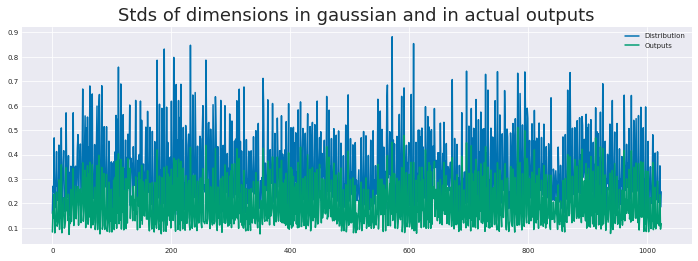

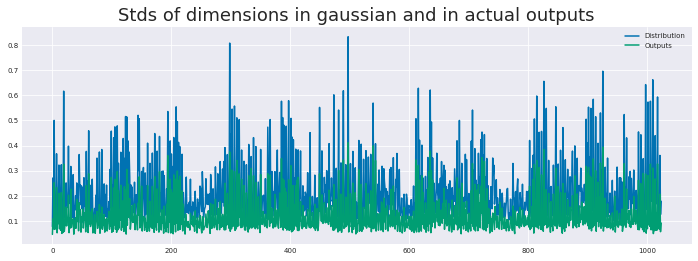

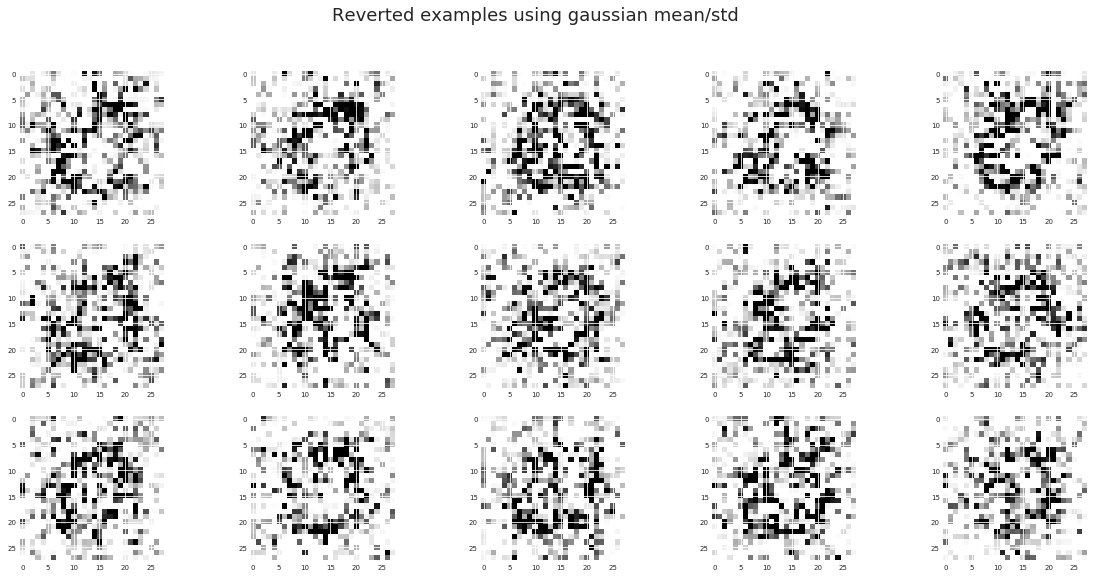

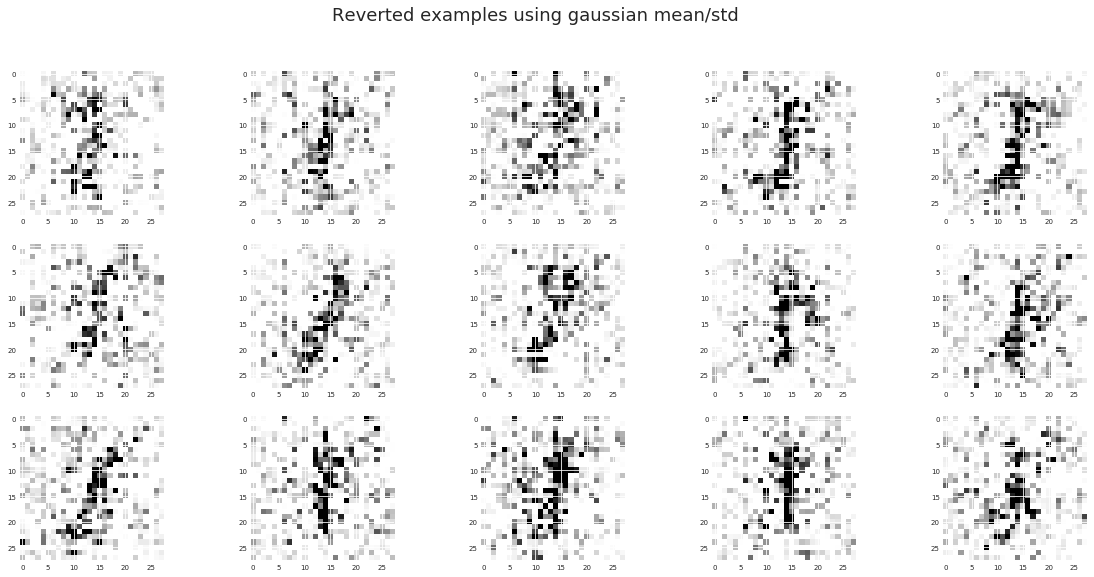

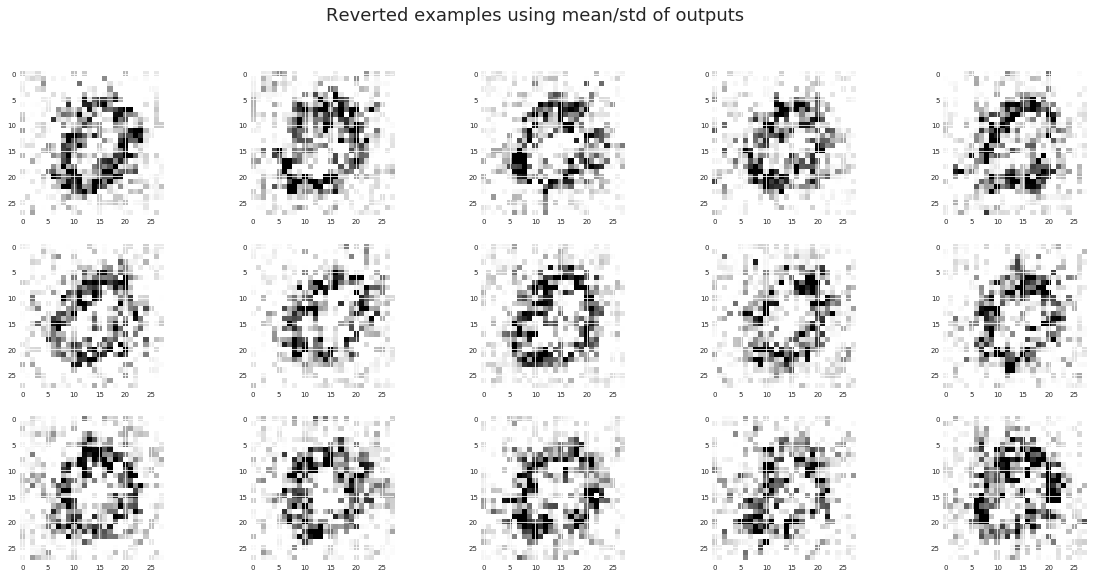

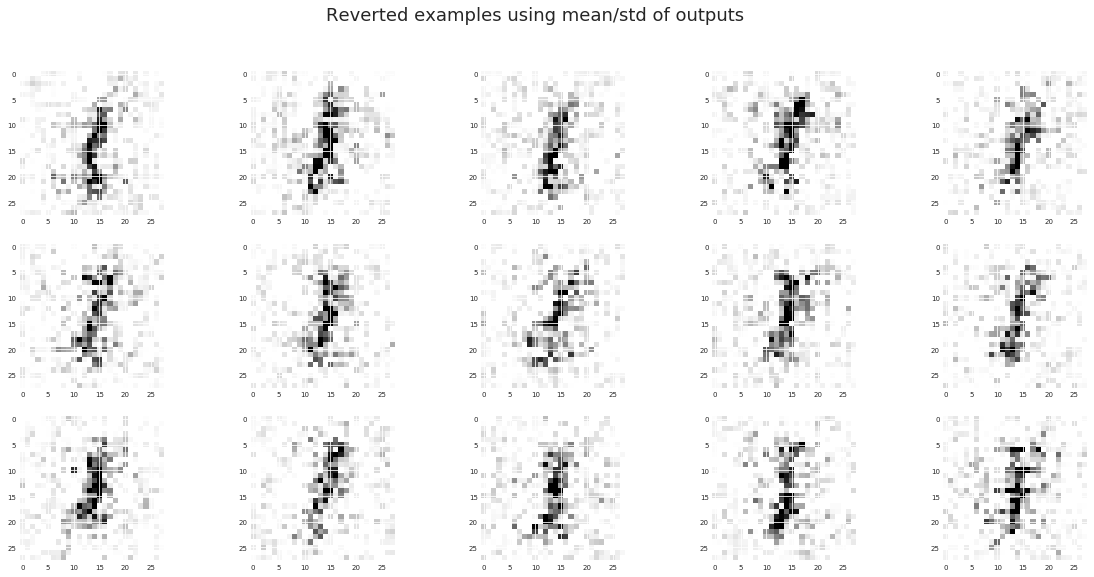

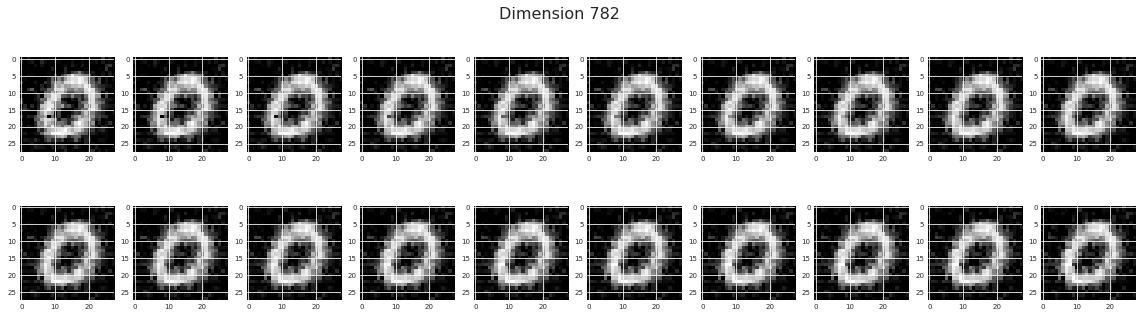

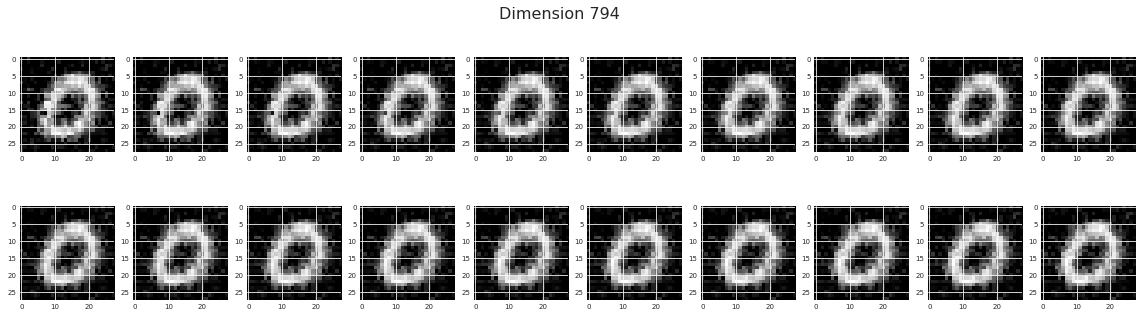

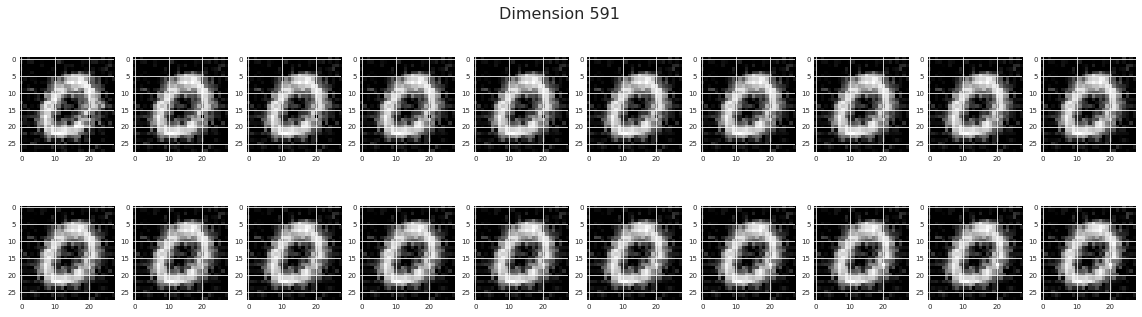

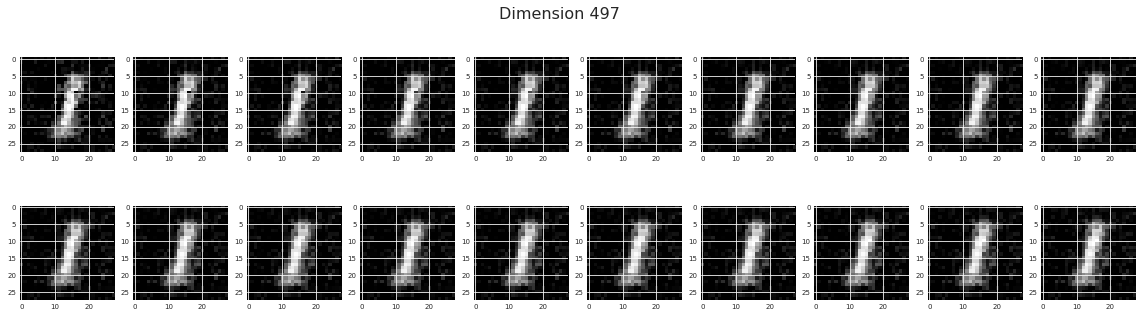

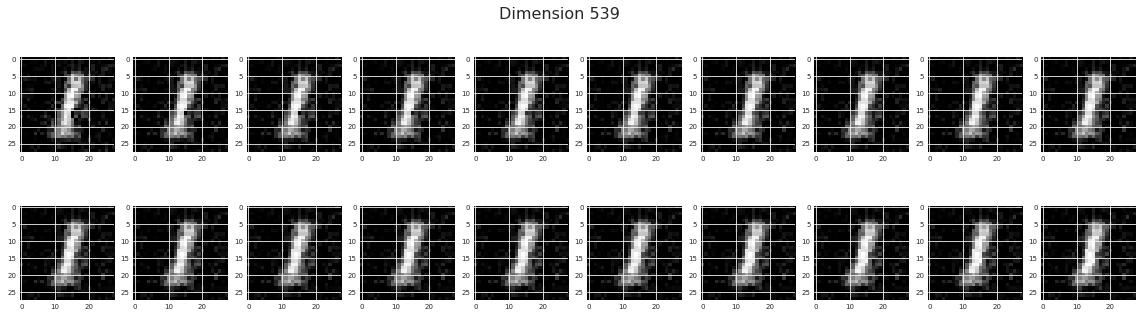

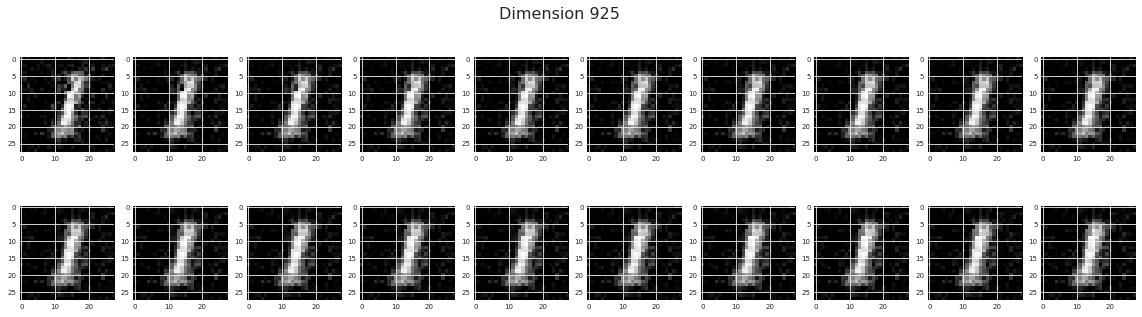

total_loss
10    7.146565

total_loss
20     4.06128

total_loss
30    3.098246

total_loss
40    2.661607

total_loss
50    2.388819

total_loss
60    2.143349

total_loss
70    2.000911

total_loss
80    1.868312

total_loss
90    1.822222

total_loss
100    1.689873

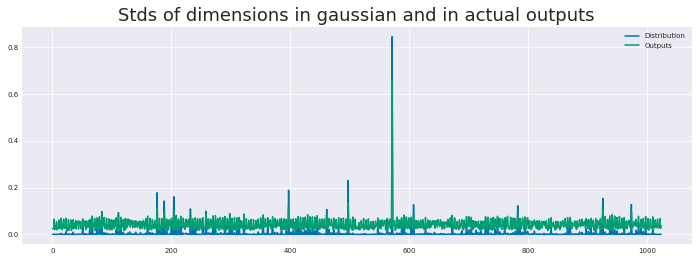

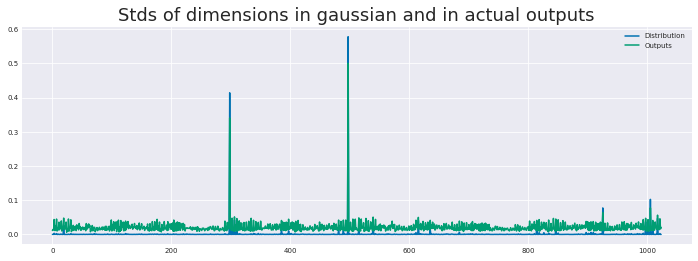

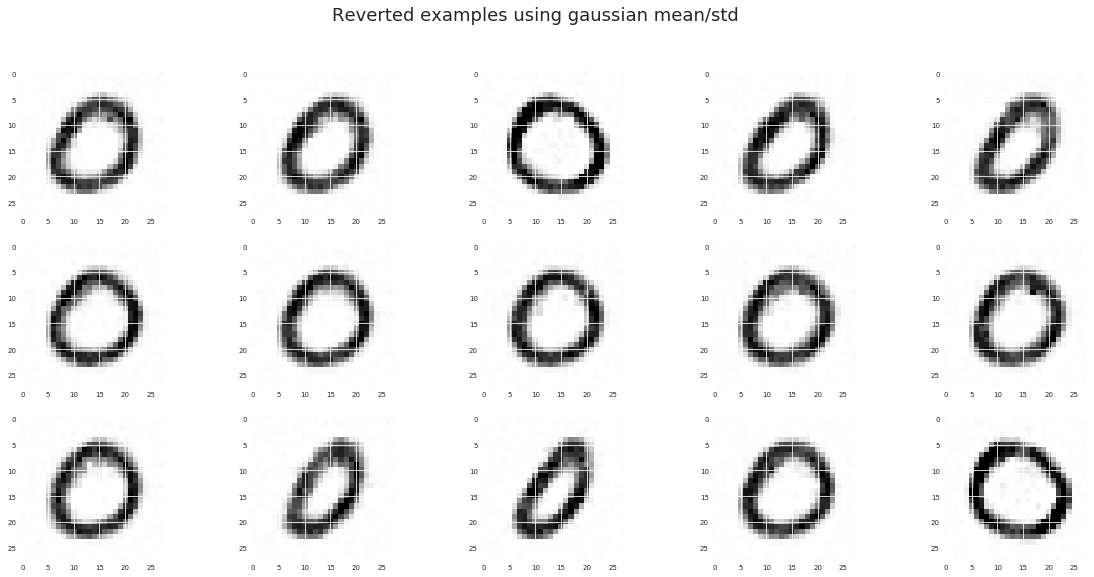

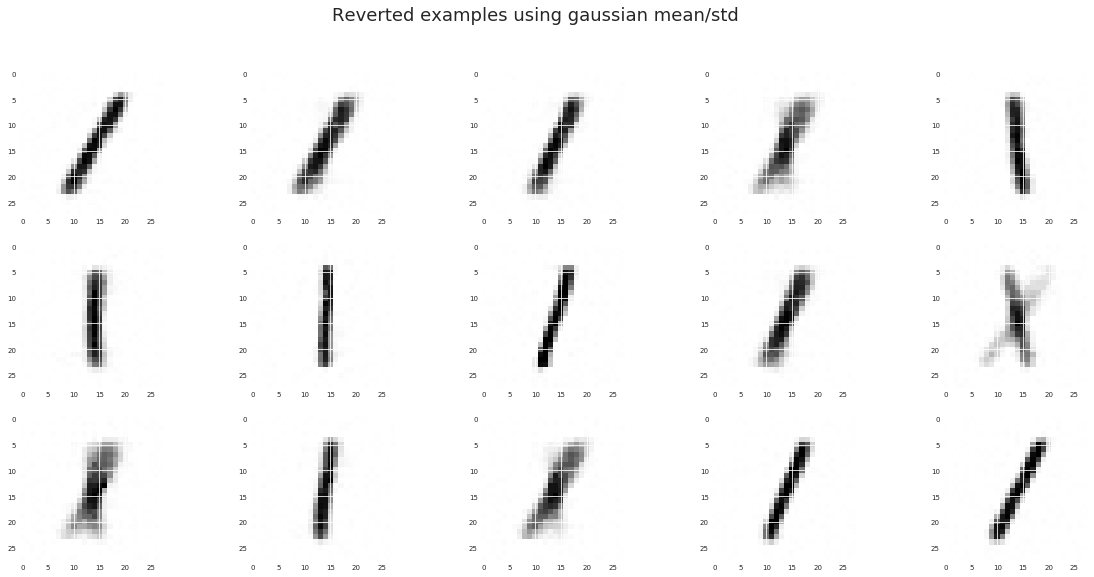

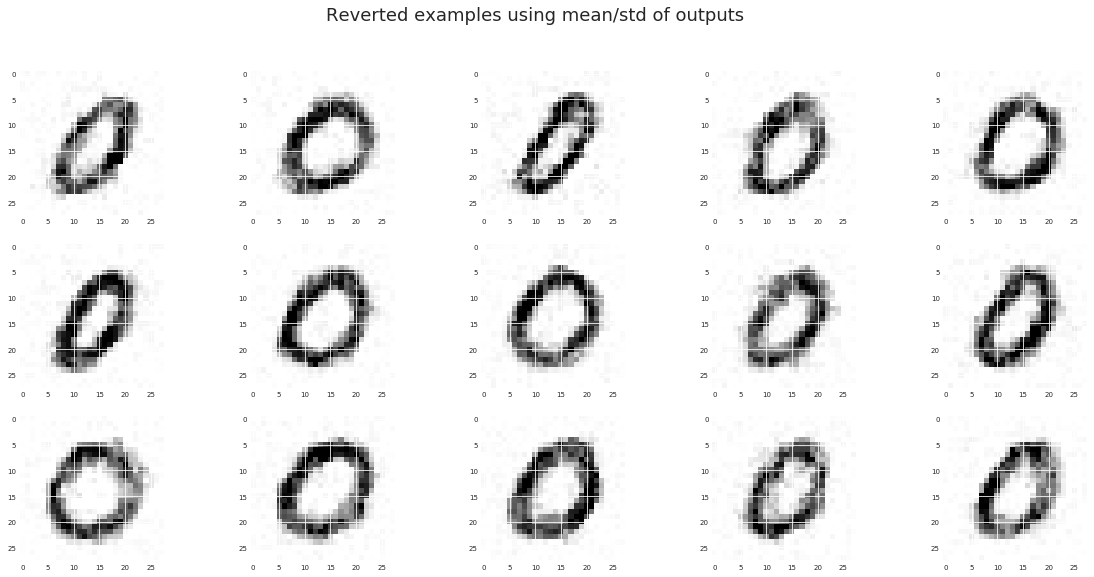

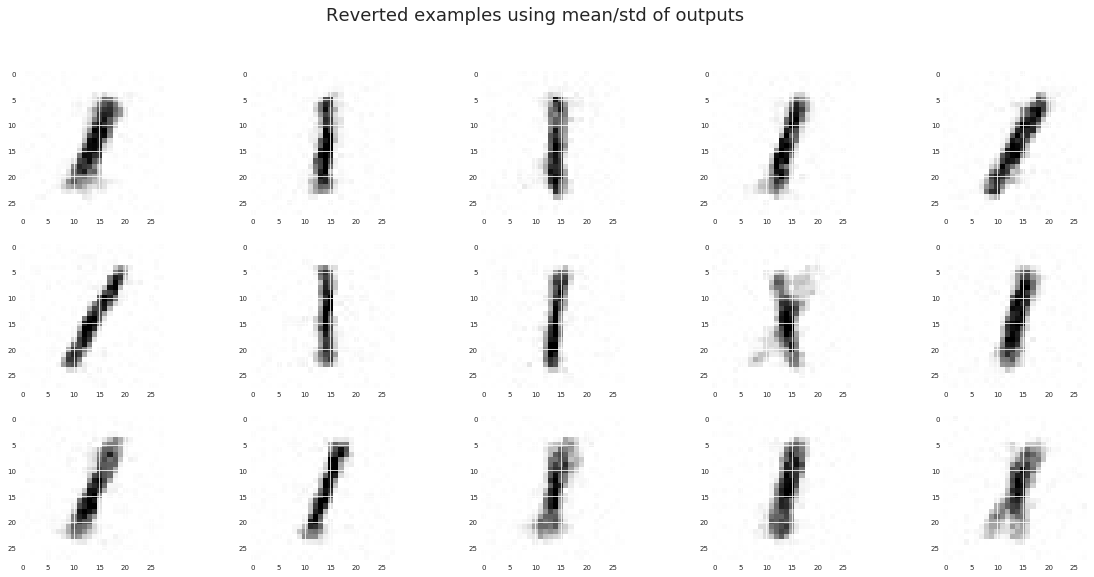

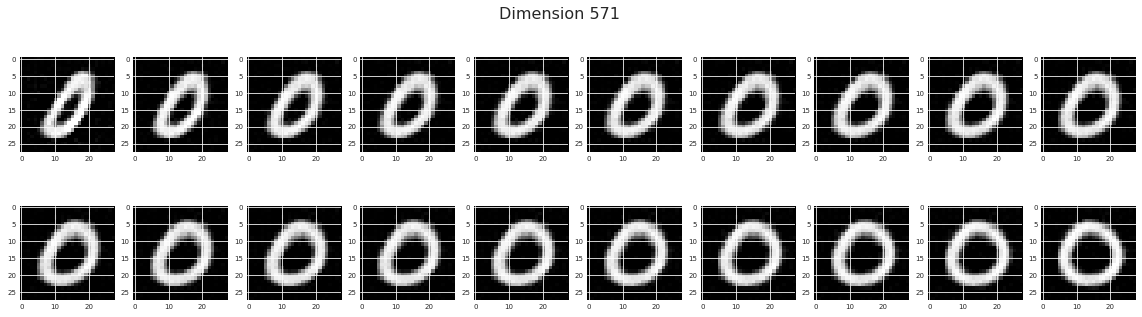

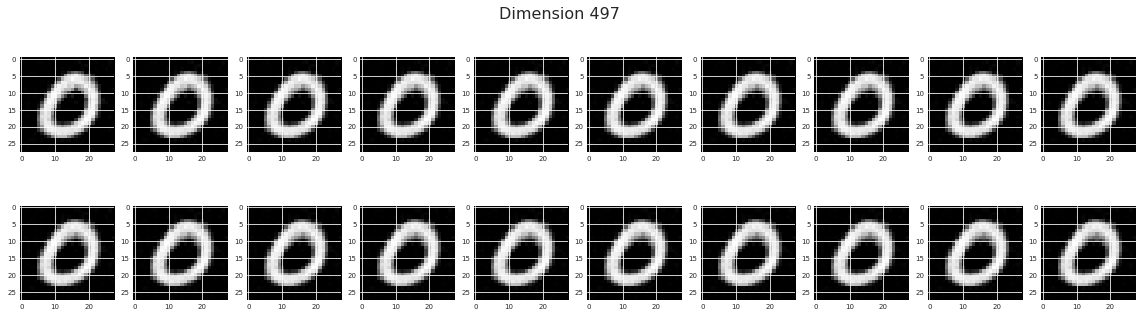

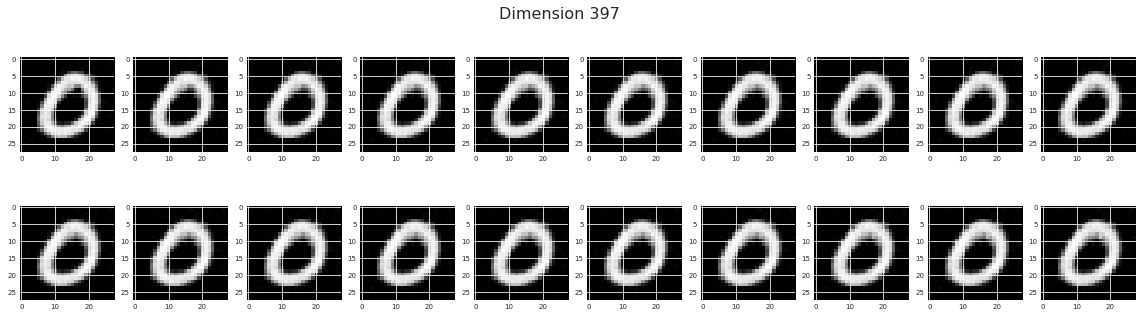

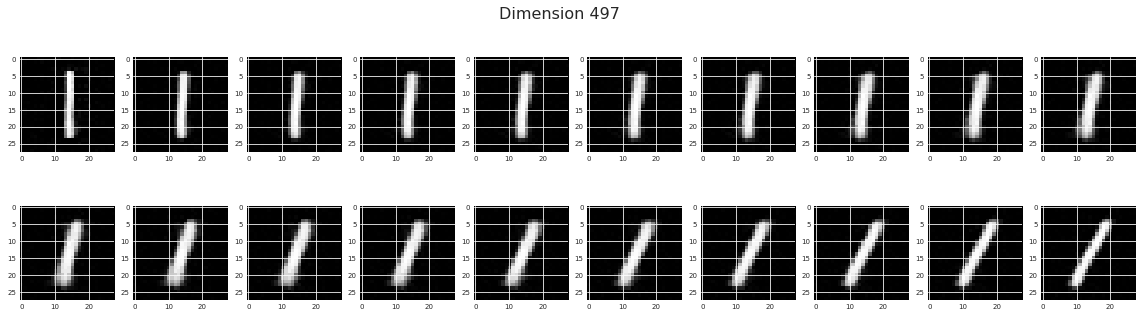

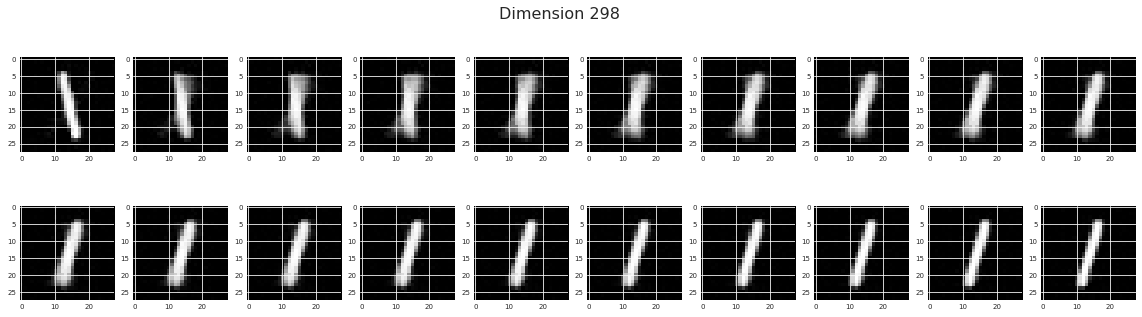

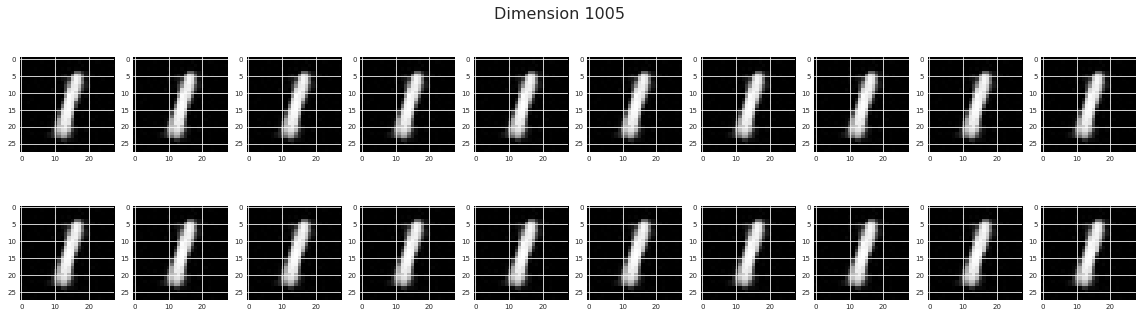

total_loss
110    1.687882

total_loss
120    1.640467

total_loss
130    1.646703

total_loss
140    1.541263

total_loss
150    1.513447

total_loss
160    1.526266

total_loss
170    1.462286

total_loss
180    1.465838

total_loss
190    1.490527

total_loss
200    1.351675

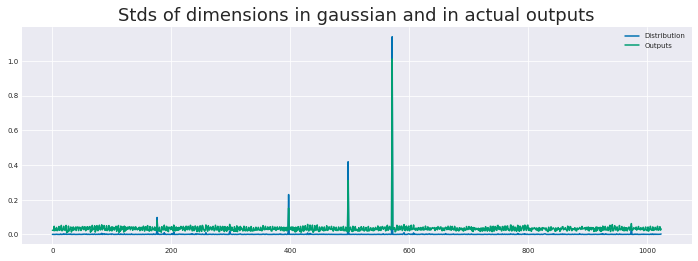

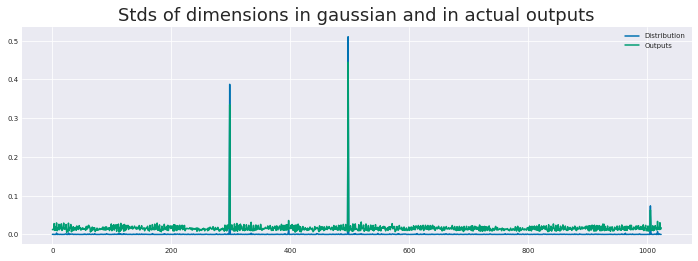

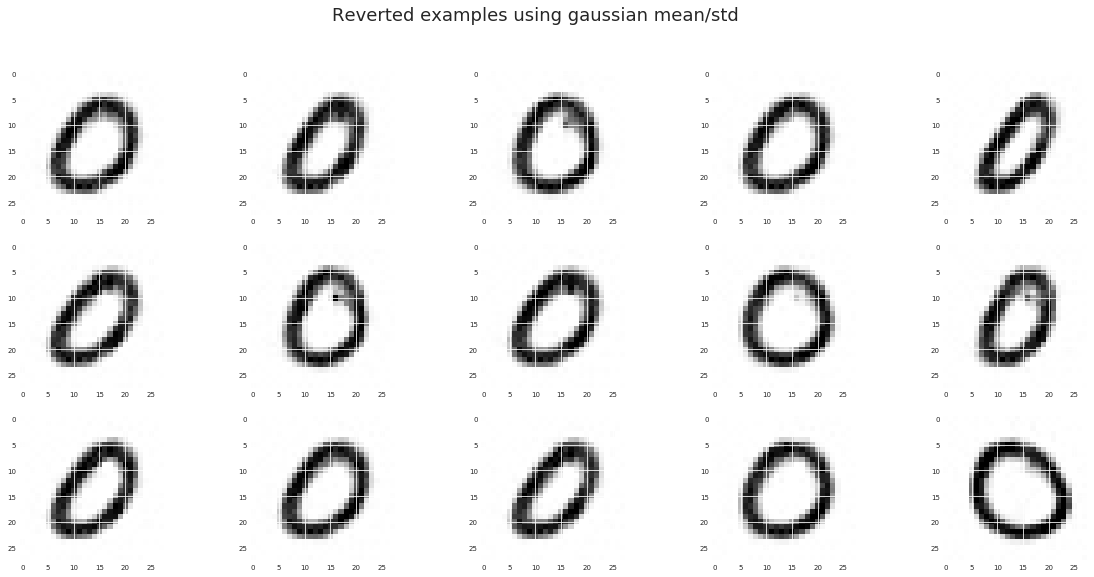

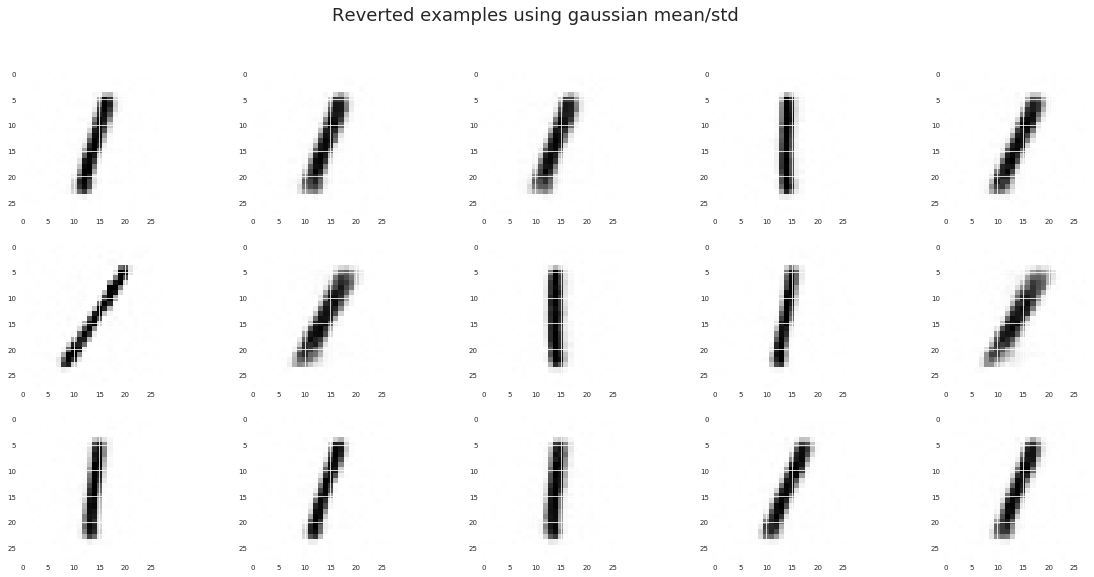

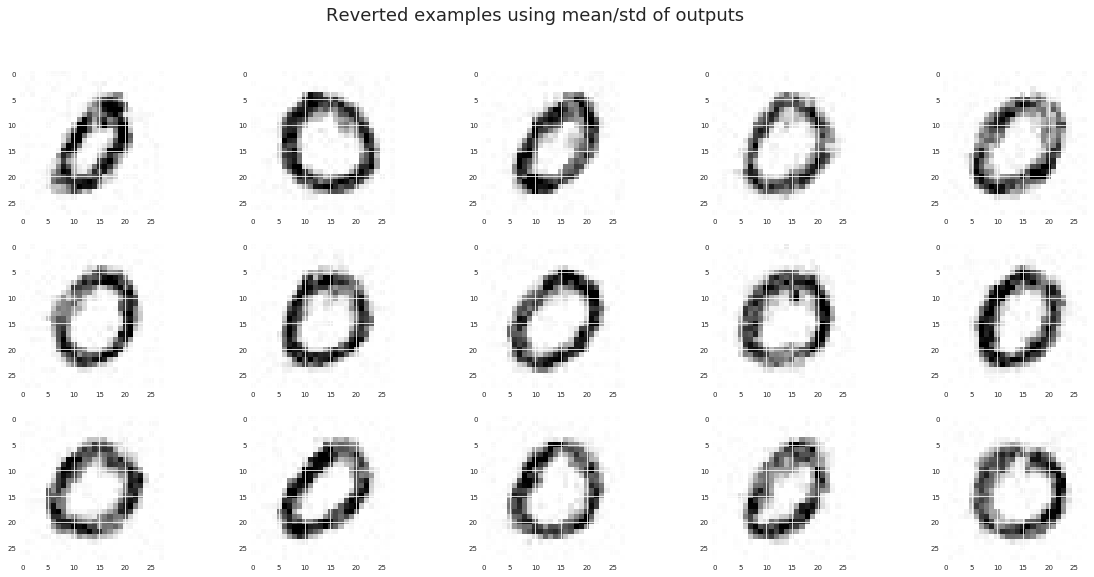

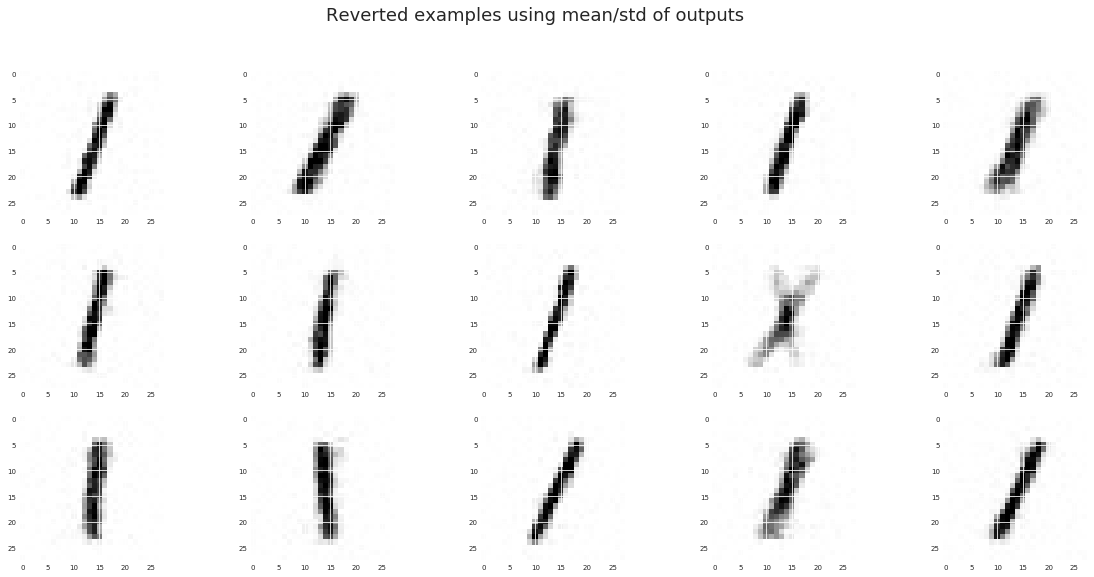

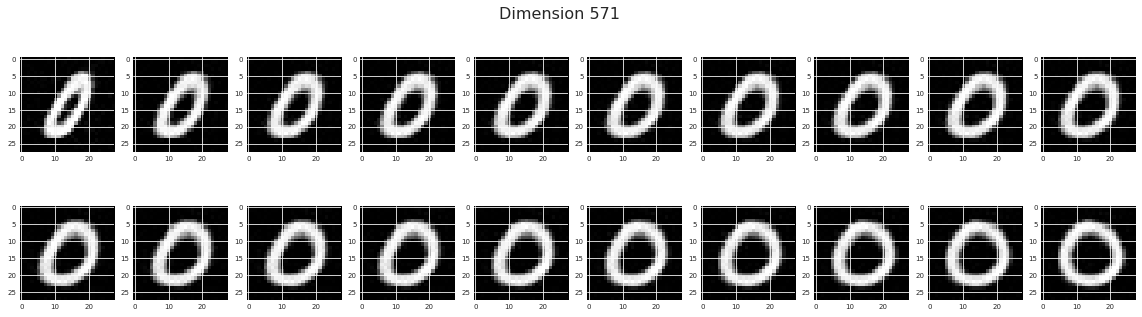

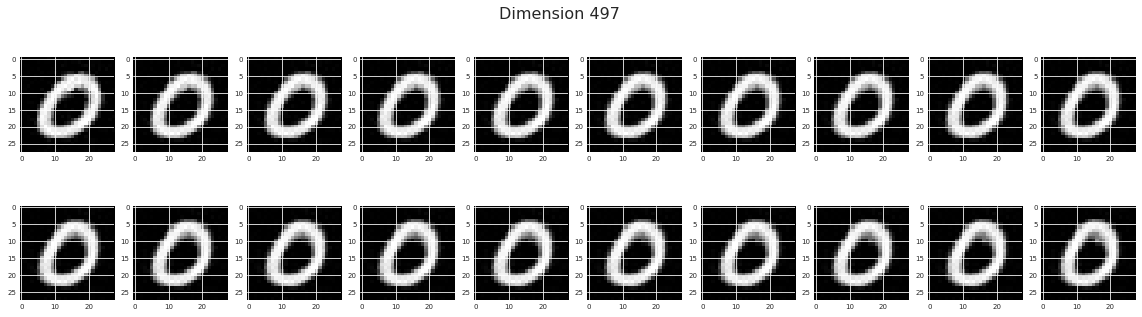

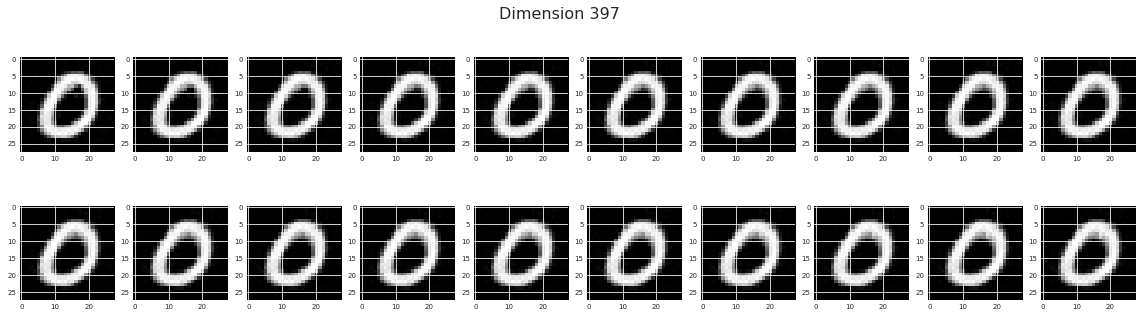

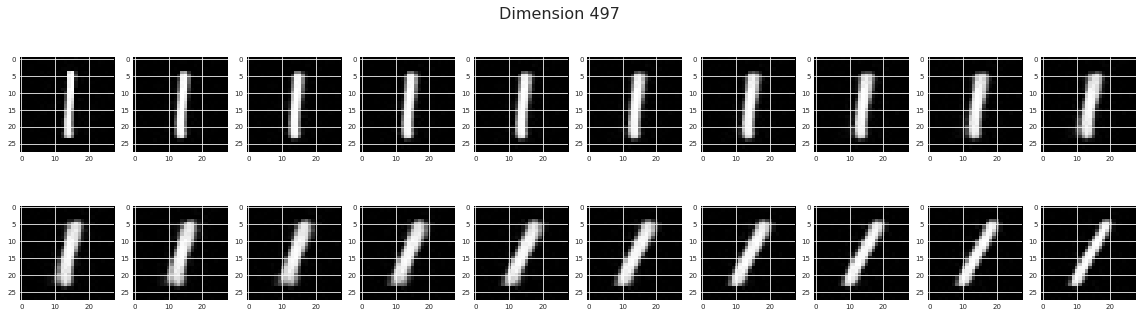

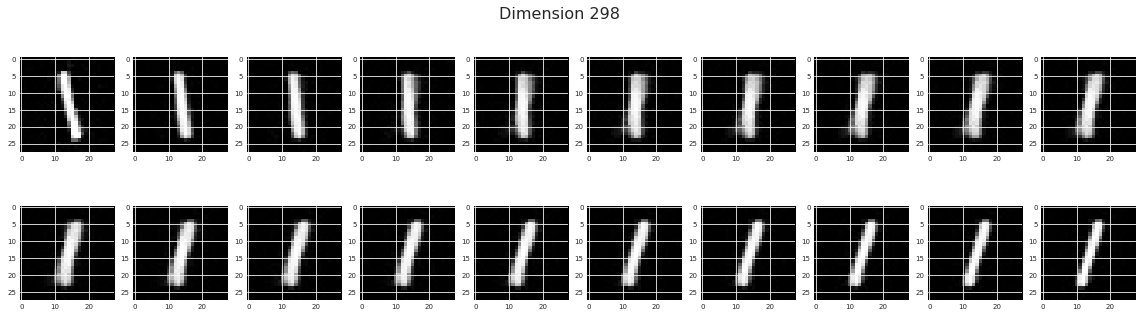

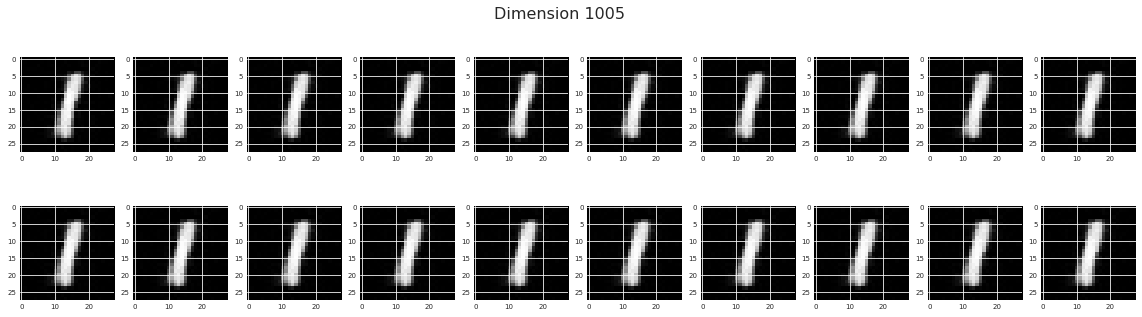

total_loss
210    1.375528

total_loss
220    1.404357

total_loss
230    1.378315

total_loss
240     1.34119

total_loss
250    1.343507

total_loss
260    1.385456

total_loss
270    1.390746

total_loss
280    1.260128

total_loss
290     1.28385

total_loss
300    1.245777

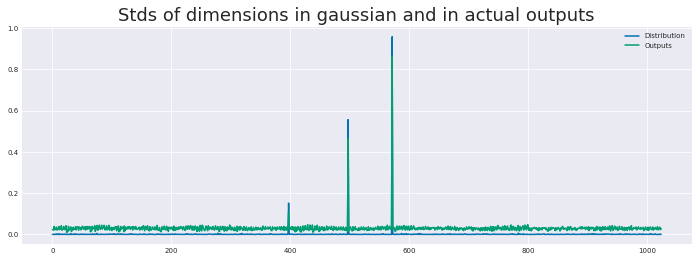

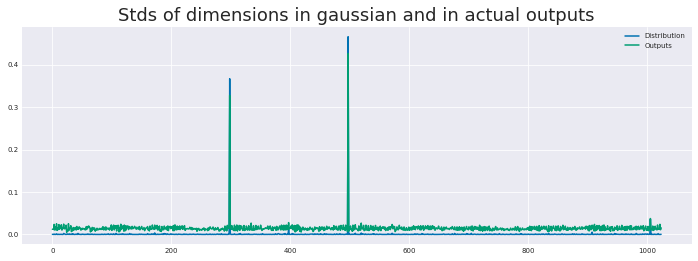

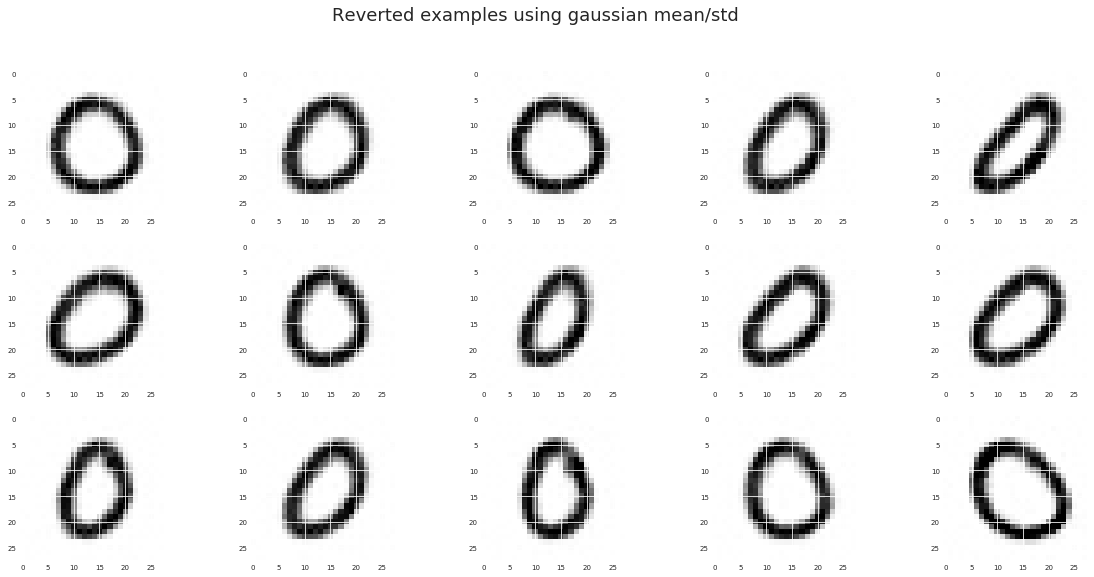

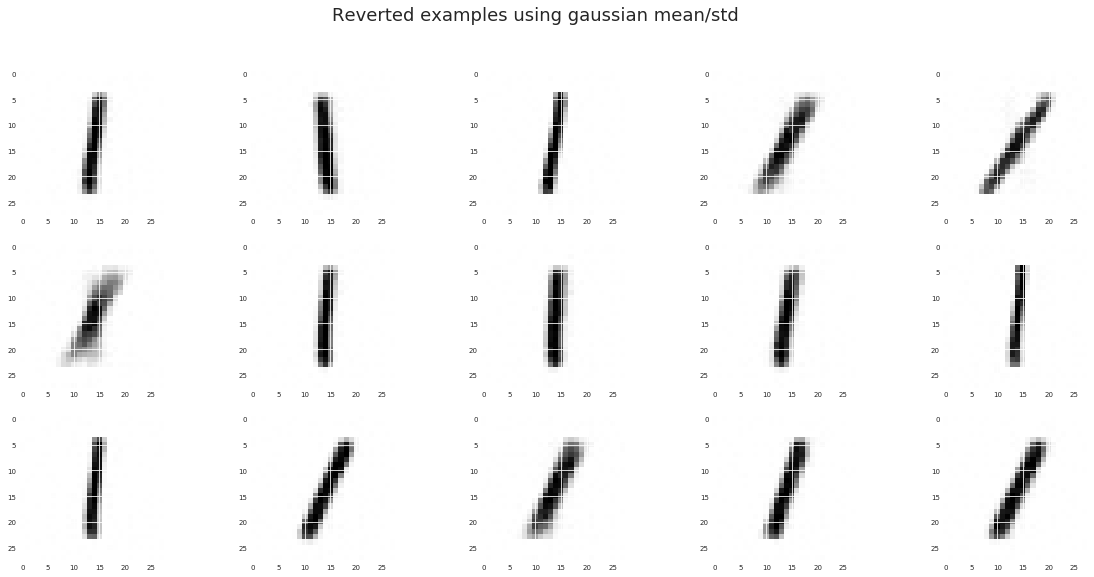

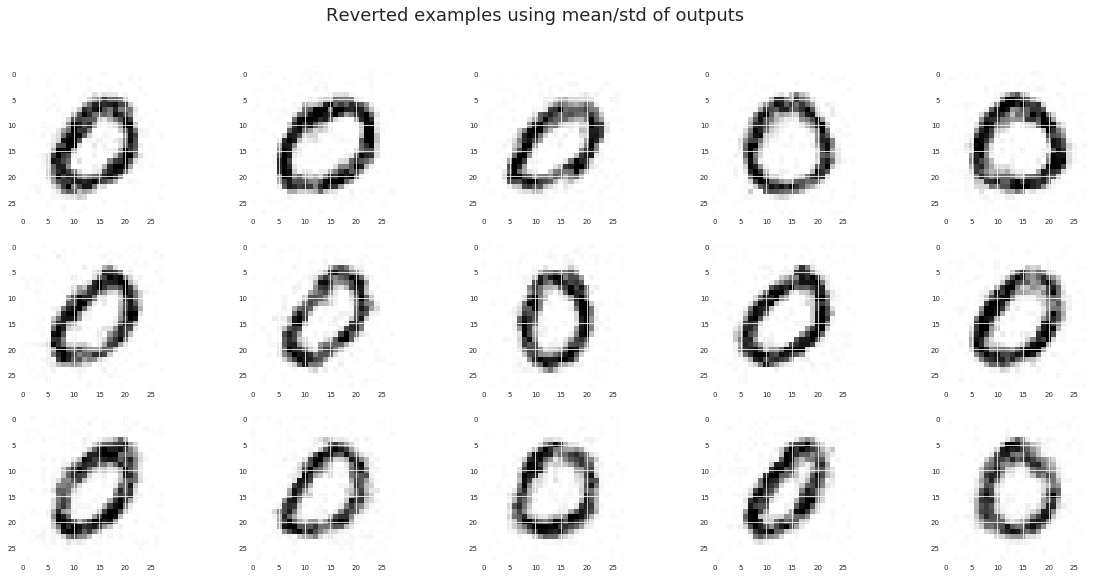

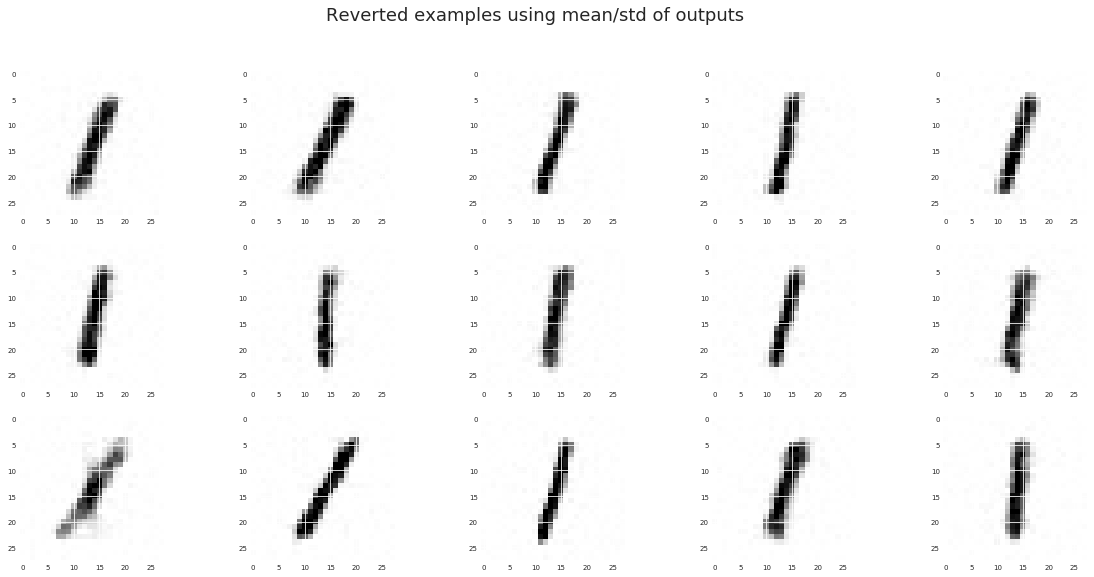

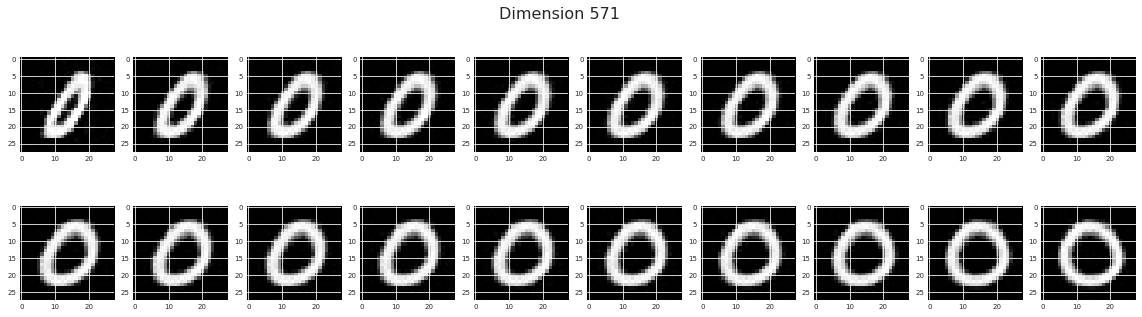

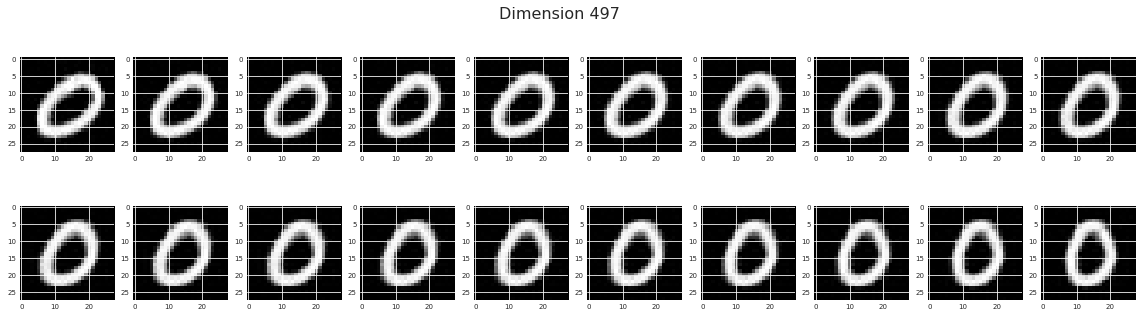

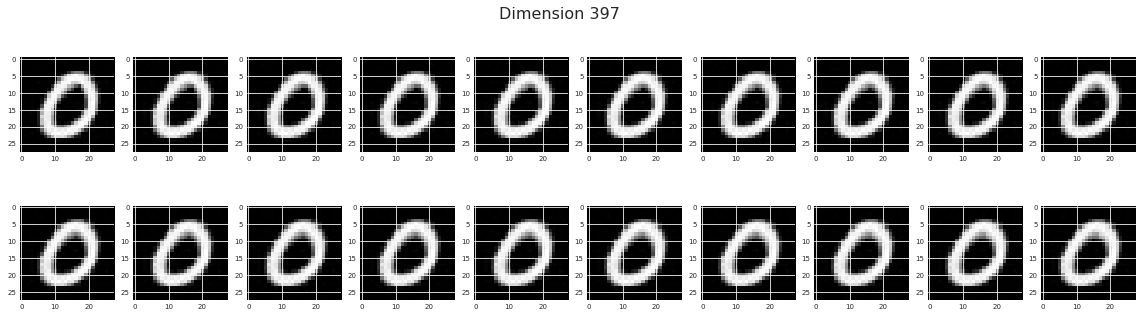

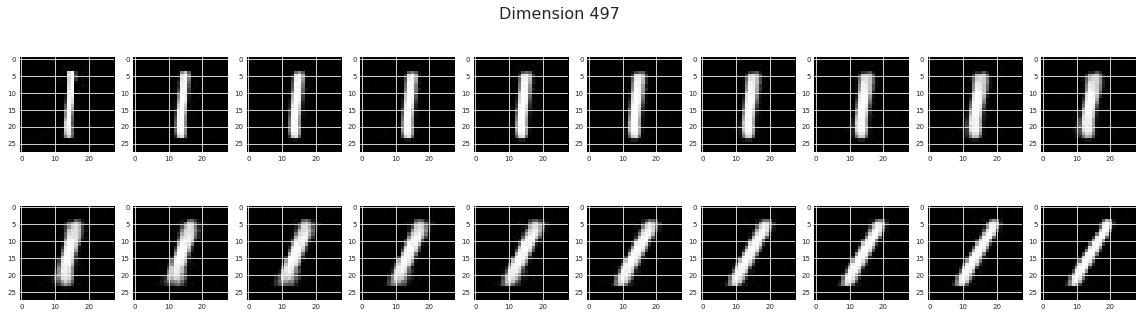

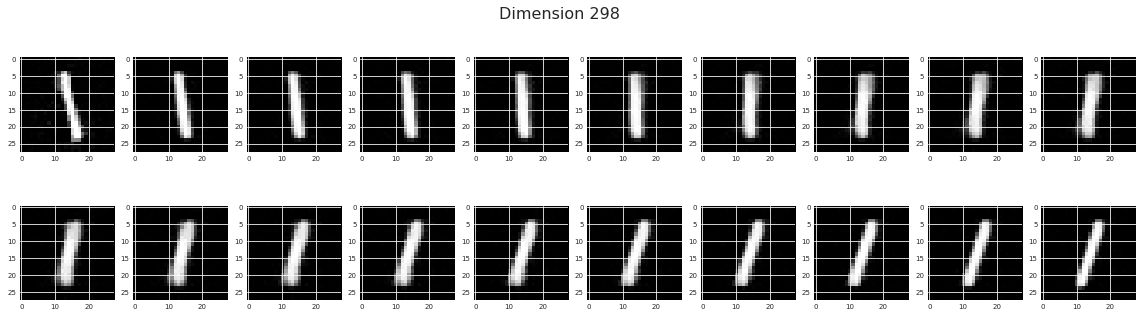

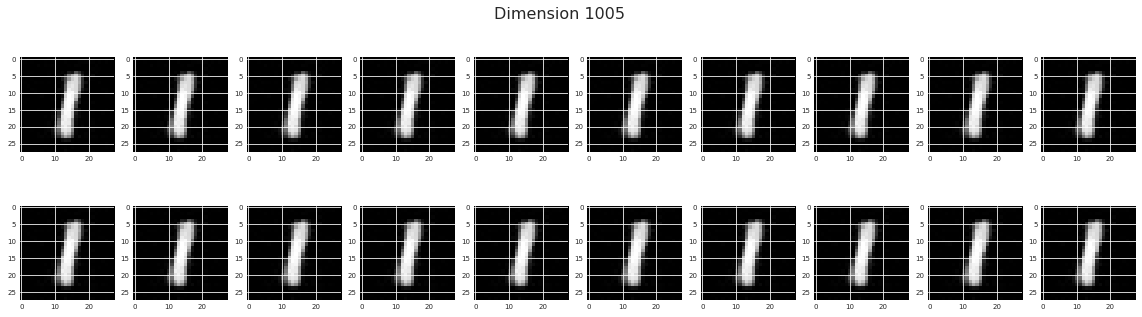

total_loss
310    1.231957

total_loss
320    1.395788

total_loss
330    1.174828

total_loss
340     1.26526

total_loss
350    1.235493

total_loss
360    1.282451

total_loss
370    1.217045

total_loss
380     1.20381

total_loss
390    1.312185

total_loss
400    1.240912

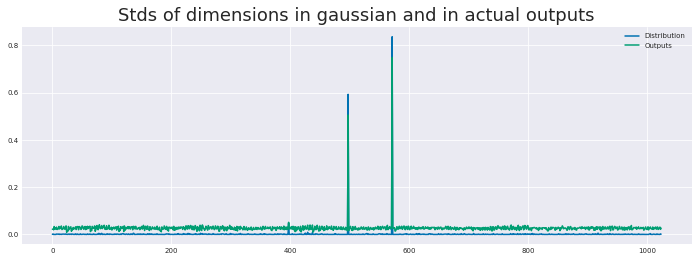

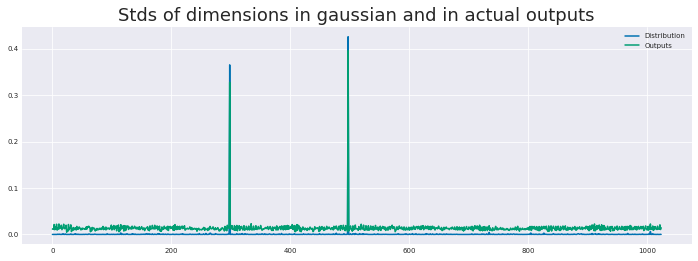

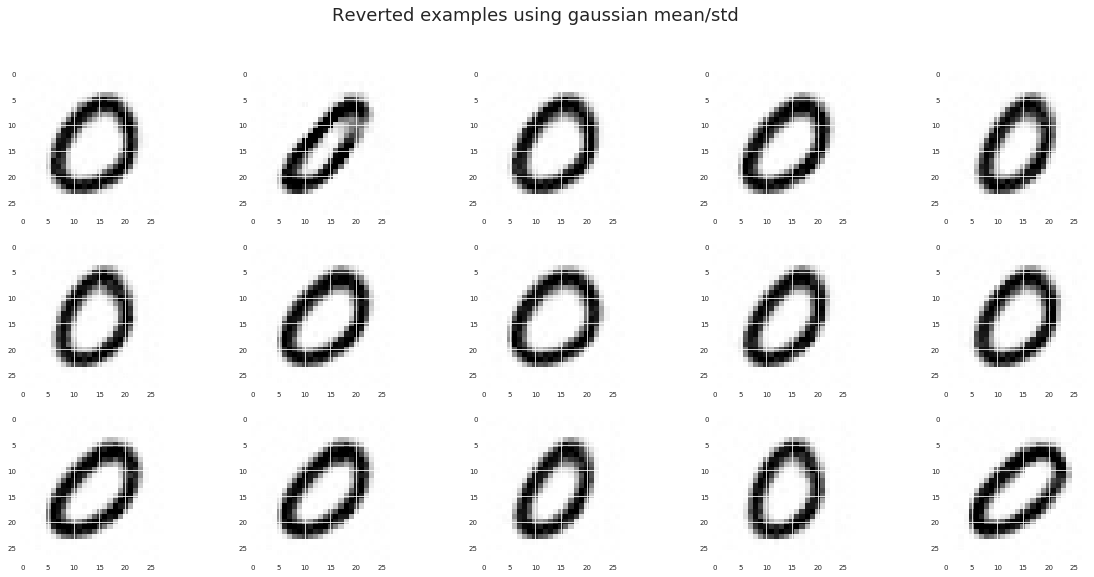

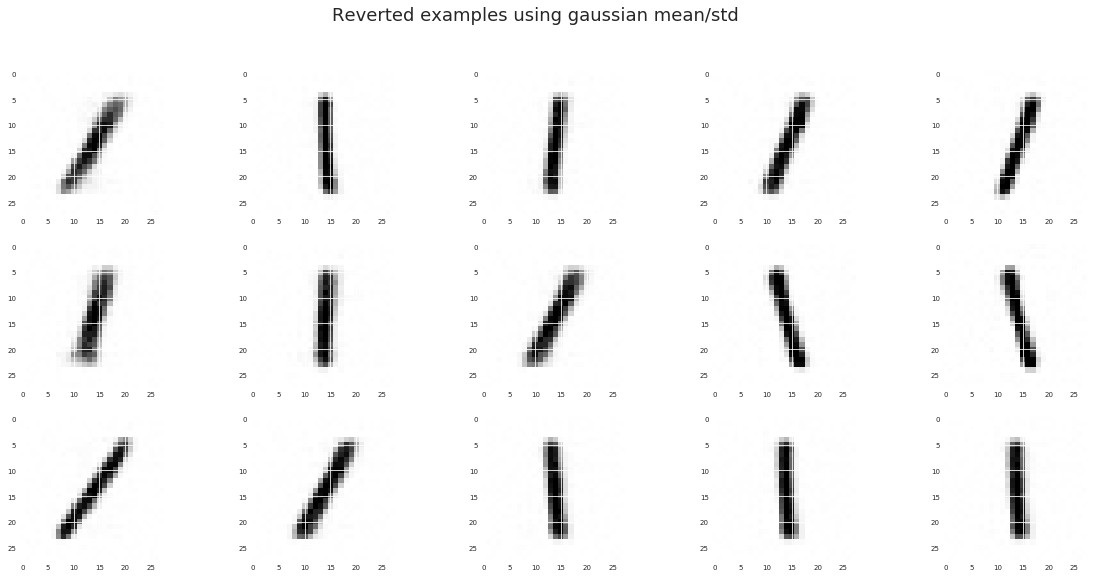

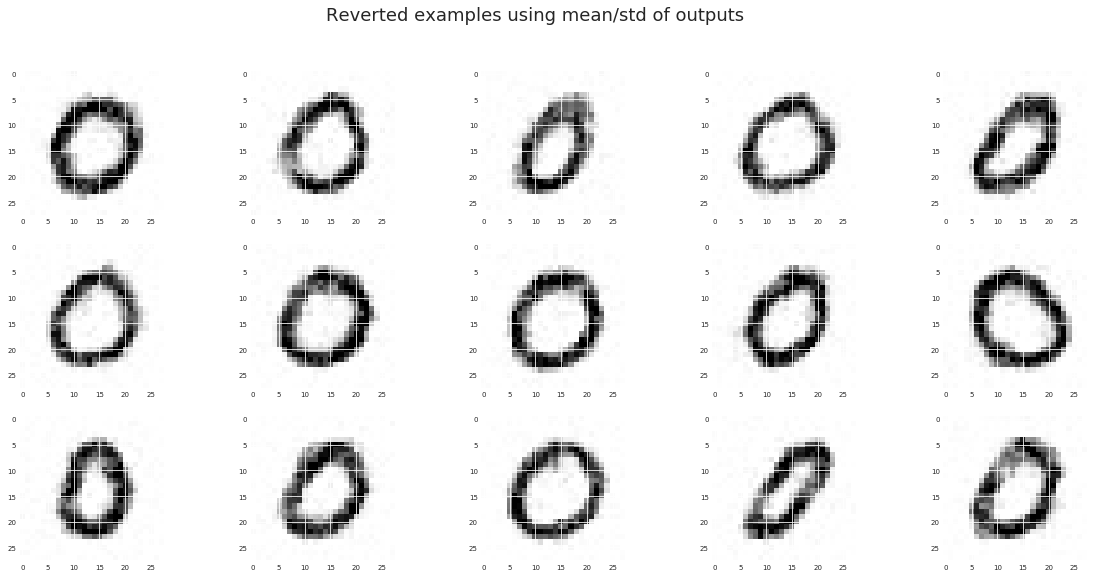

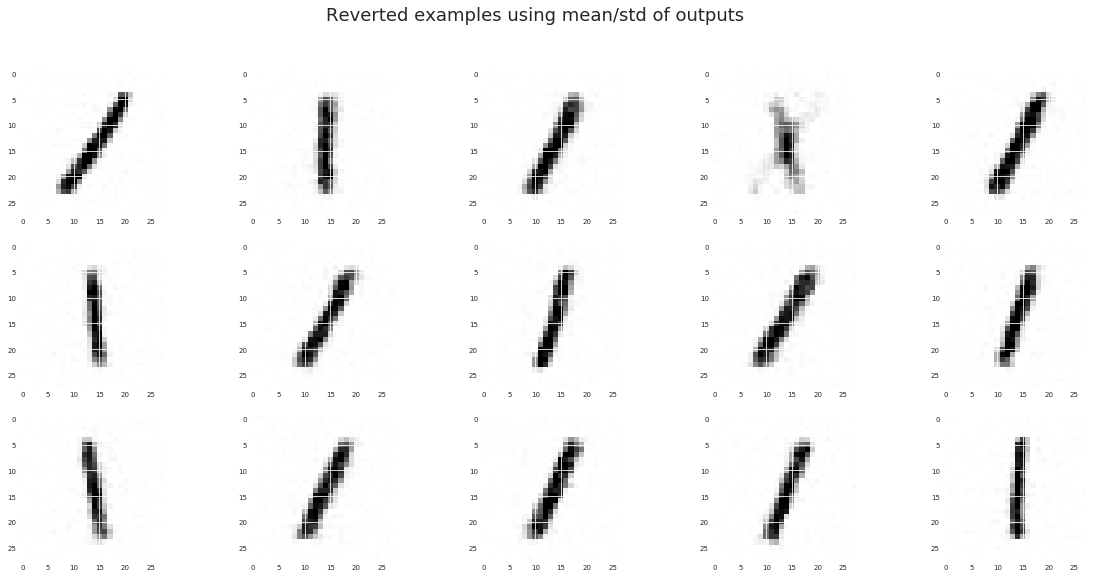

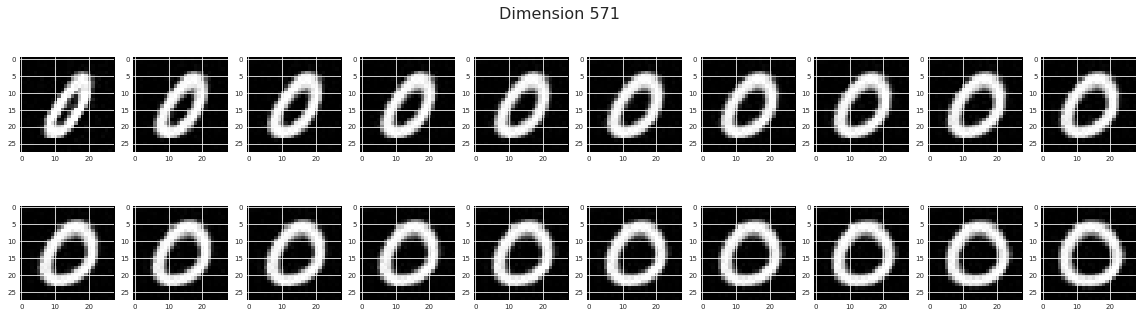

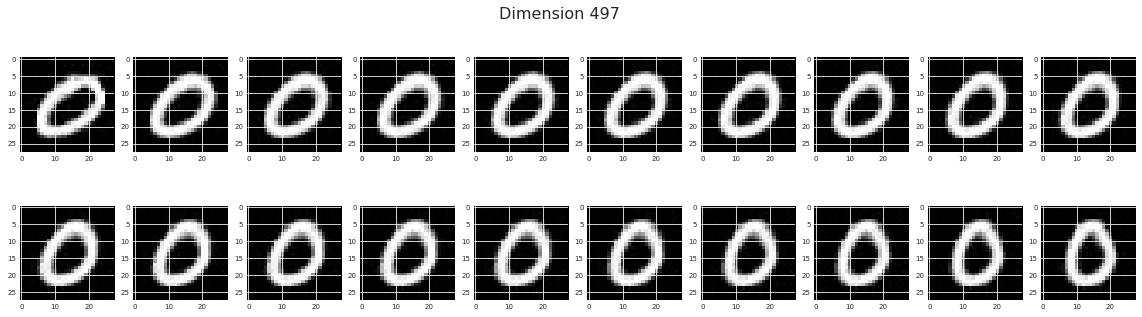

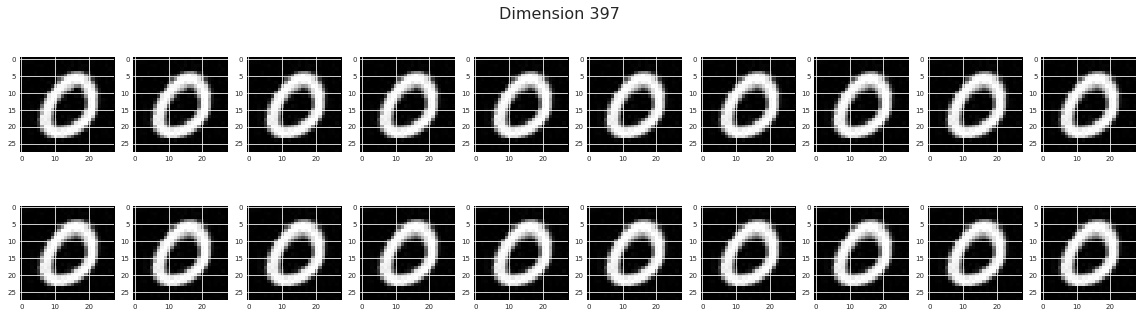

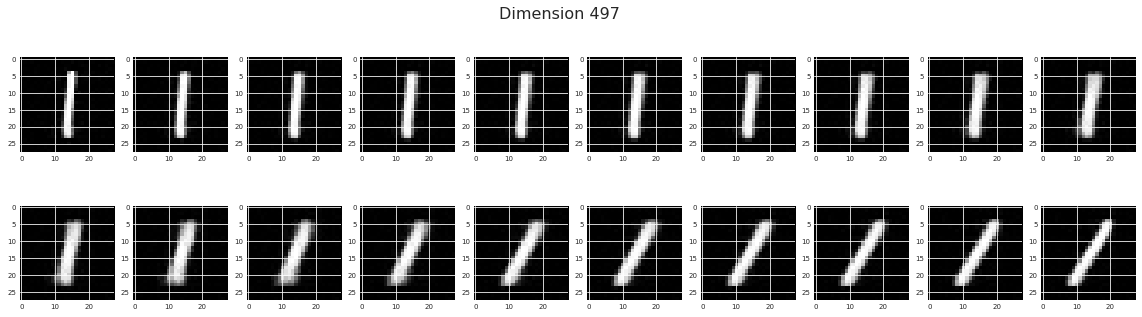

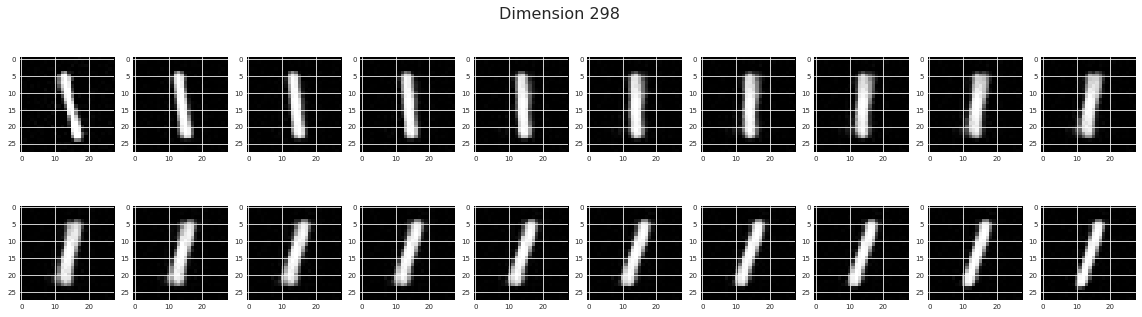

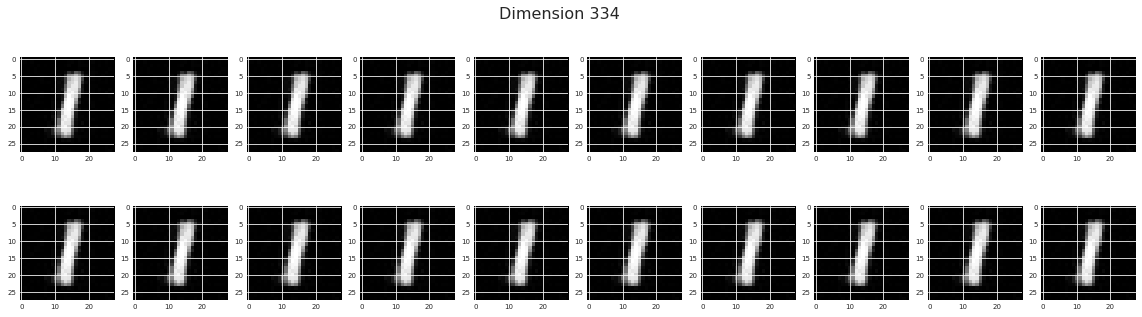

total_loss
410    1.240025

total_loss
420    1.199733

total_loss
430    1.126089

total_loss
440    1.137922

total_loss
450    1.165814

total_loss
460    1.137893

total_loss
470    1.256751

total_loss
480    1.141919

total_loss
490    1.158837

total_loss
500    1.166025

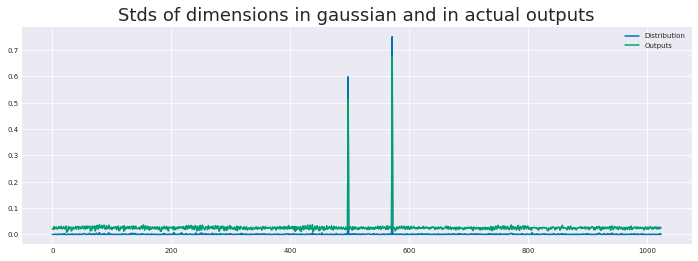

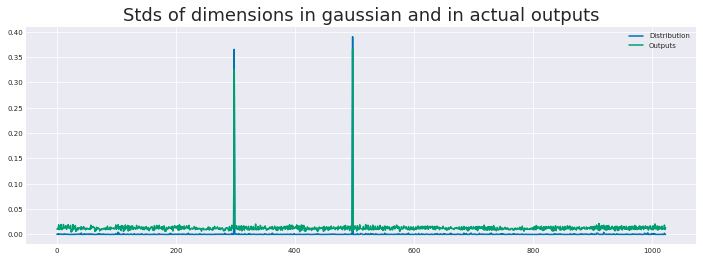

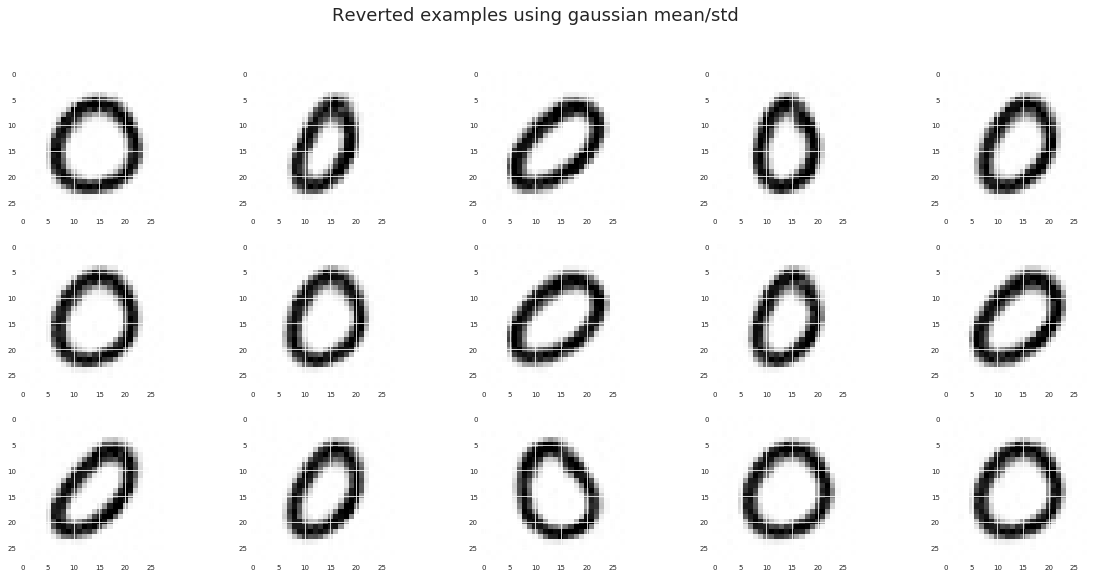

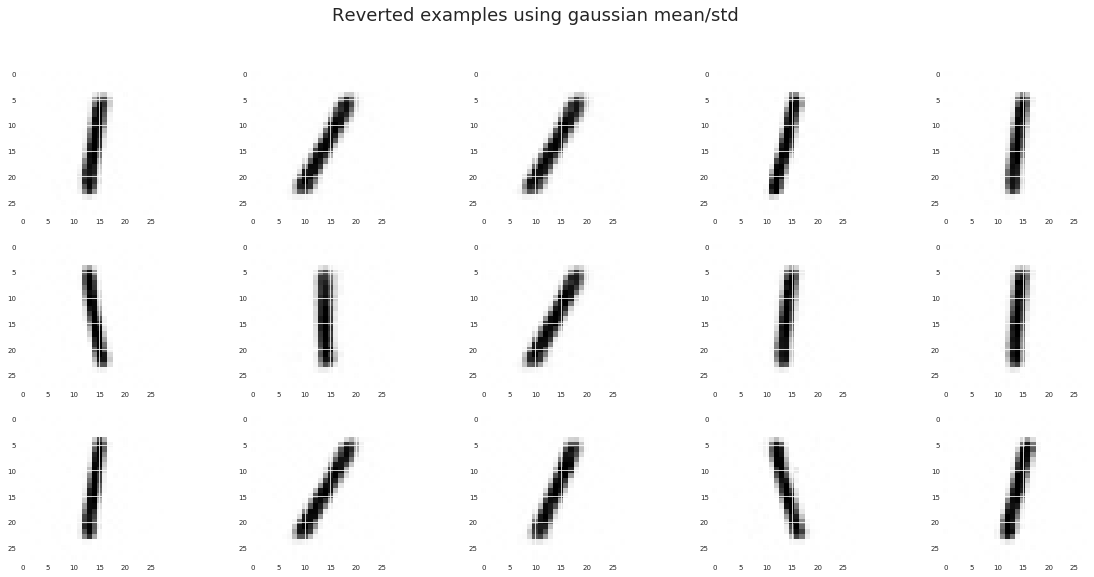

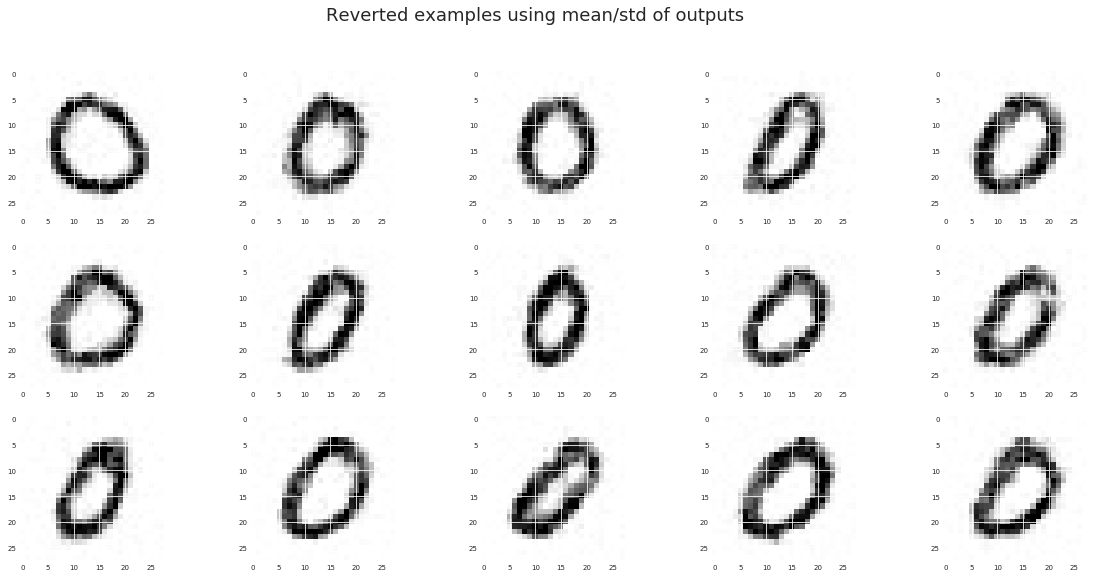

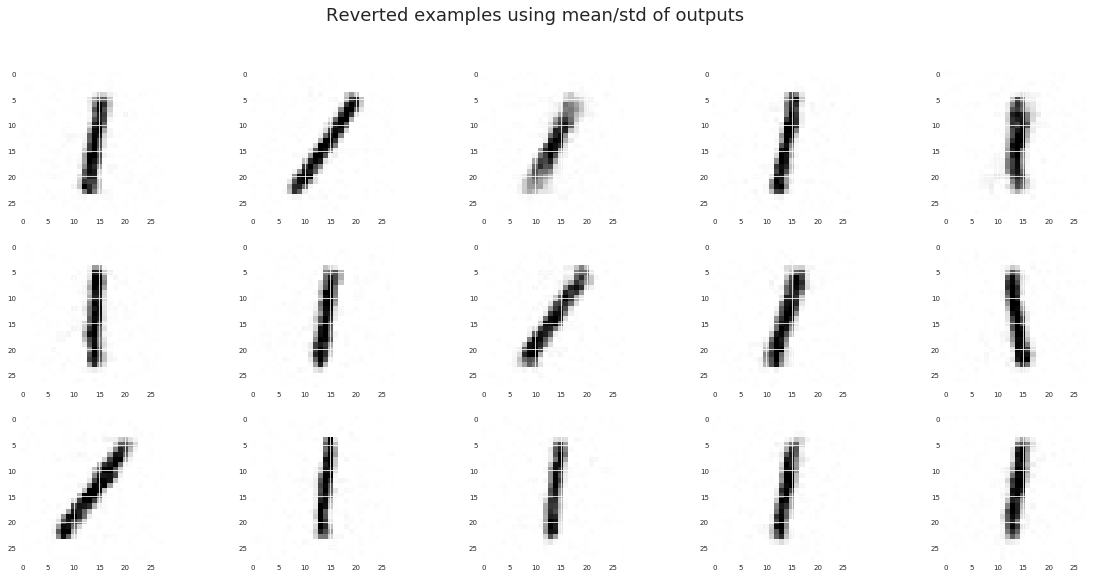

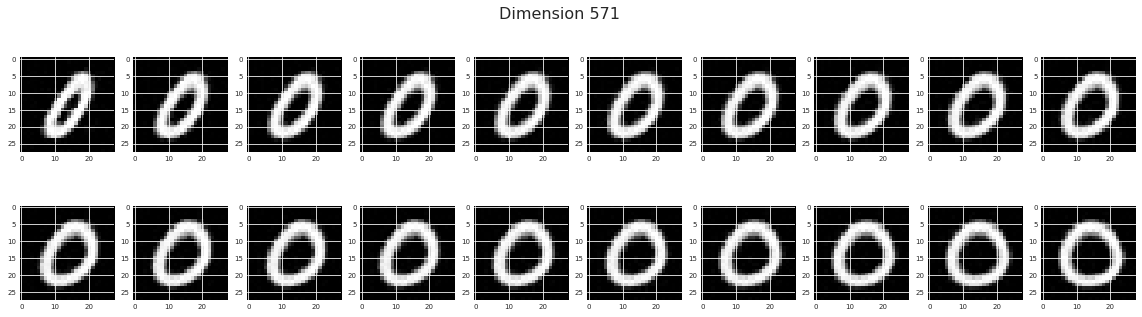

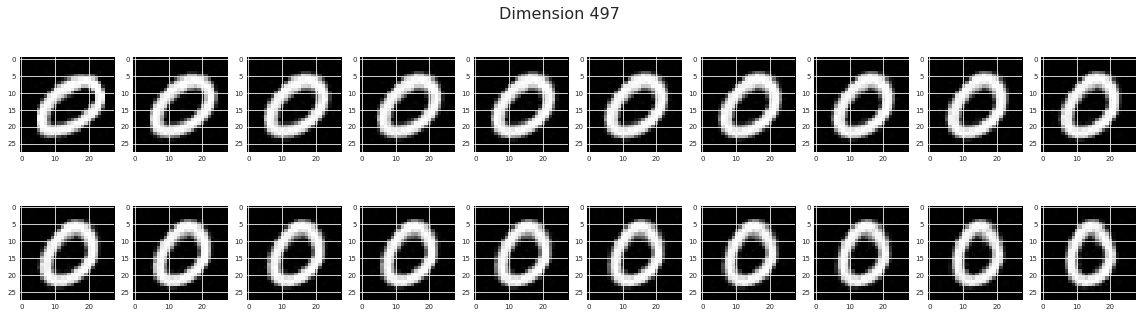

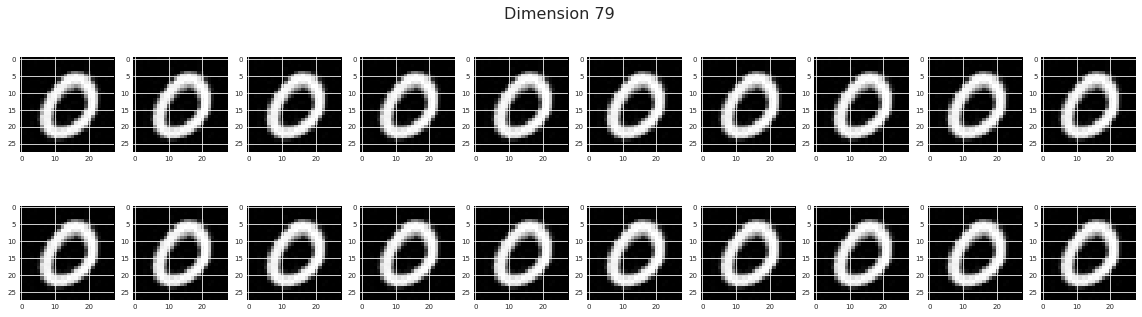

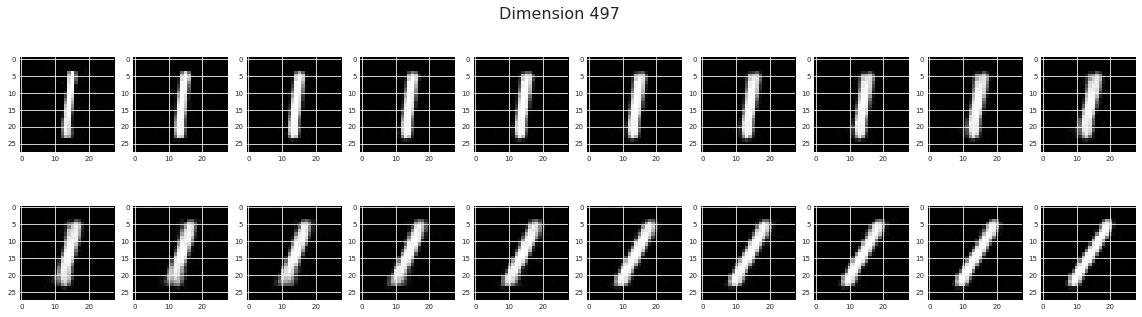

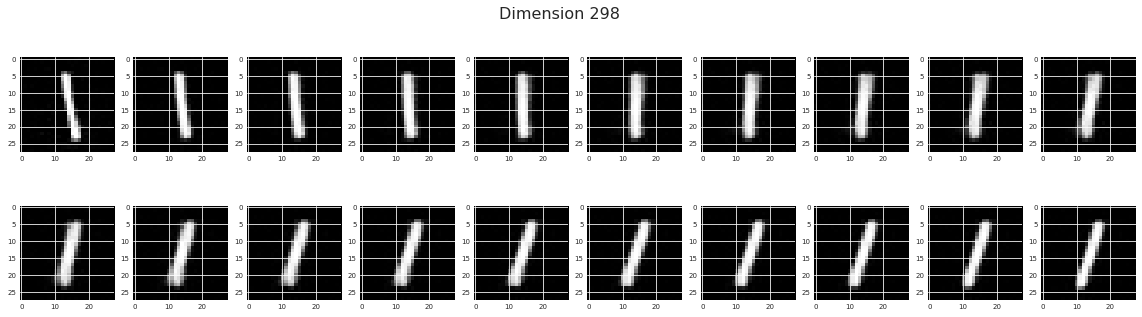

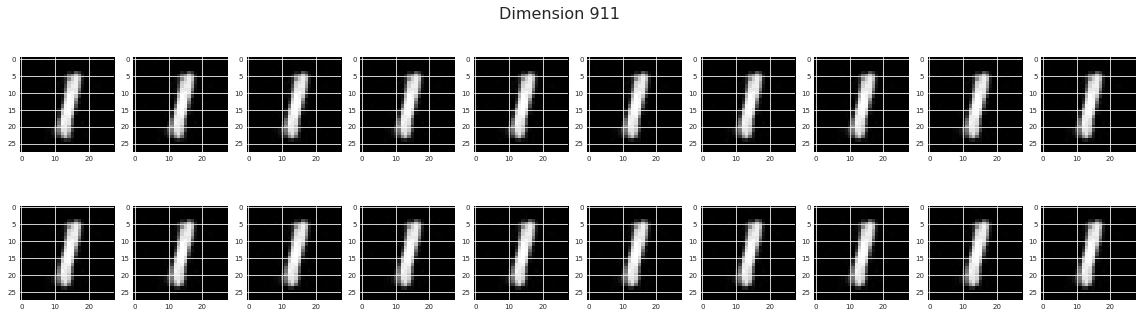

total_loss
510     1.18045

total_loss
520     1.15701

total_loss
530    1.122992

total_loss
540    1.141716

total_loss
550     1.10542

total_loss
560    1.206153

total_loss
570    1.101714

total_loss
580    1.156479

total_loss
590    1.109692

total_loss
600    1.135385

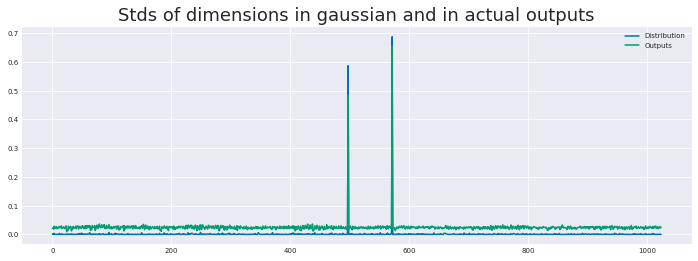

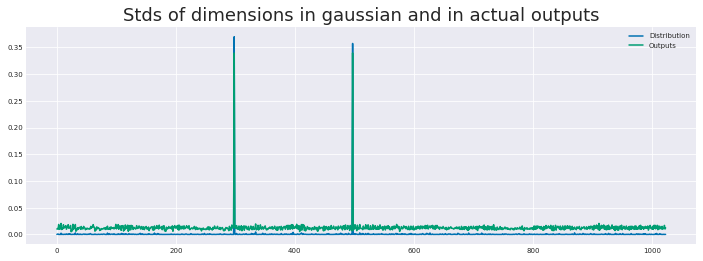

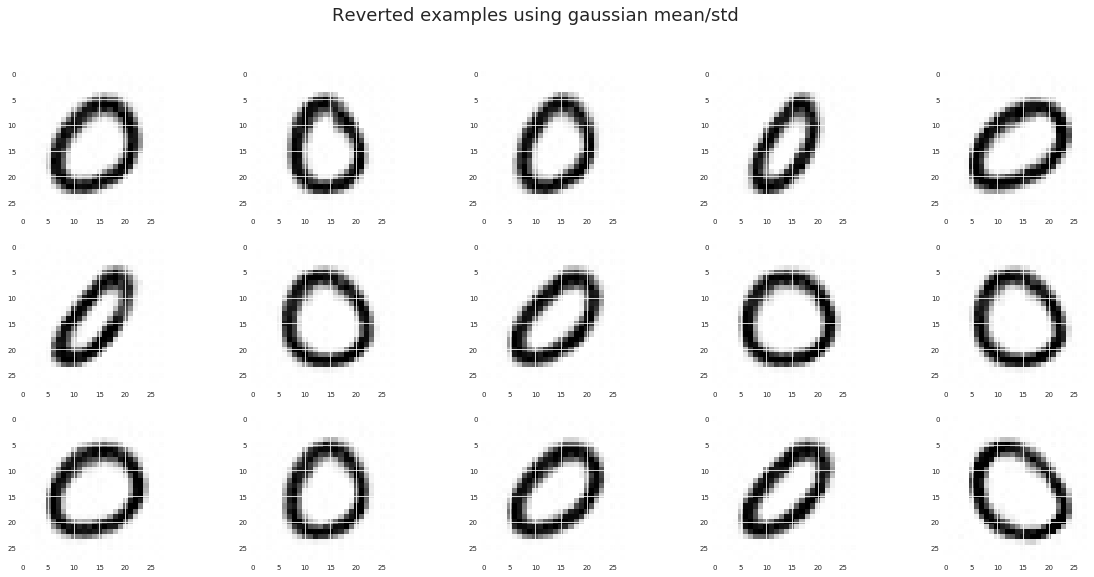

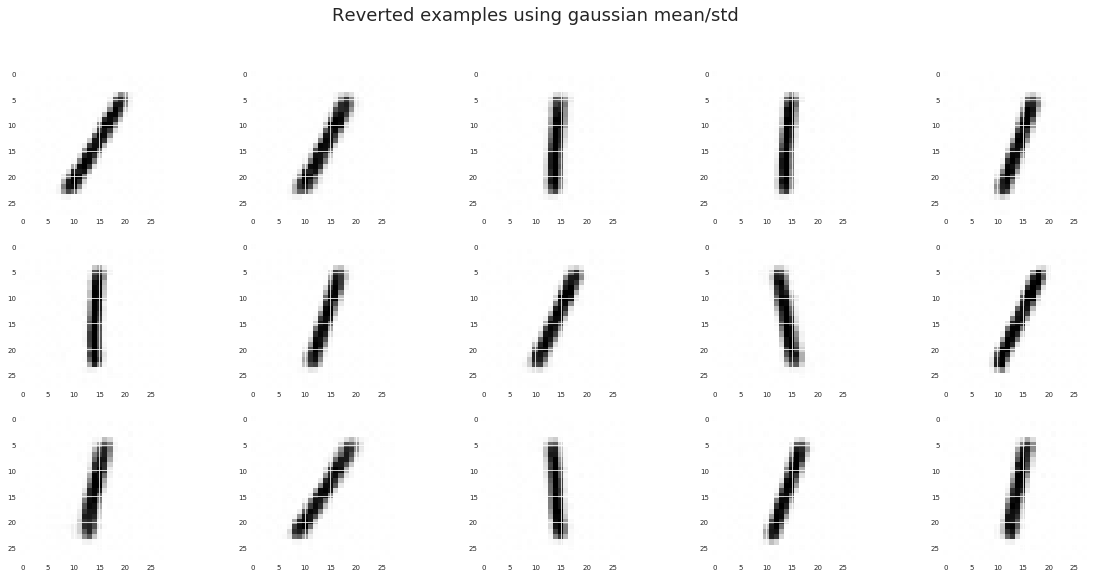

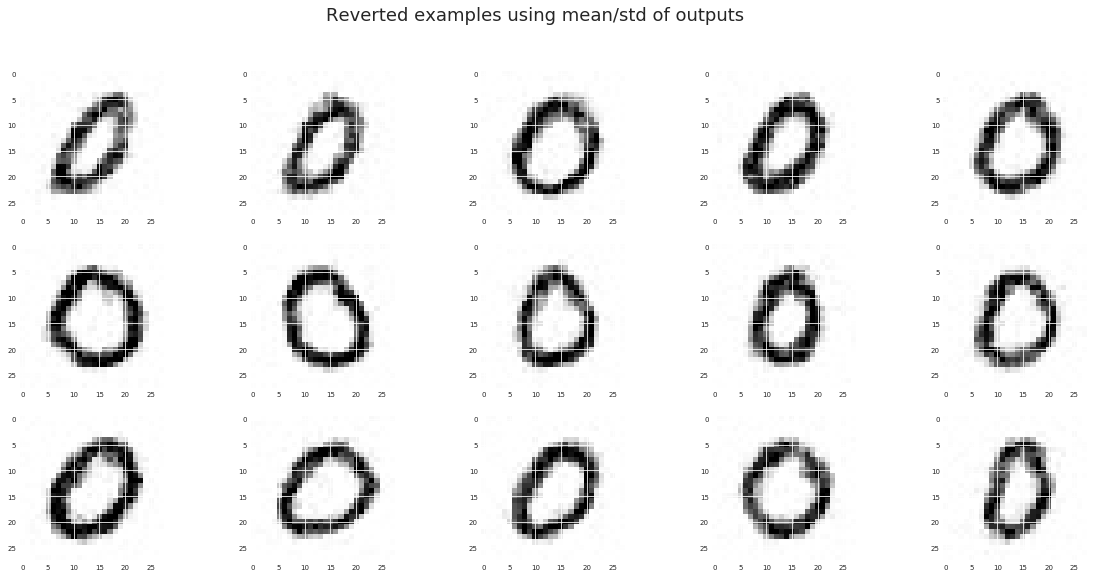

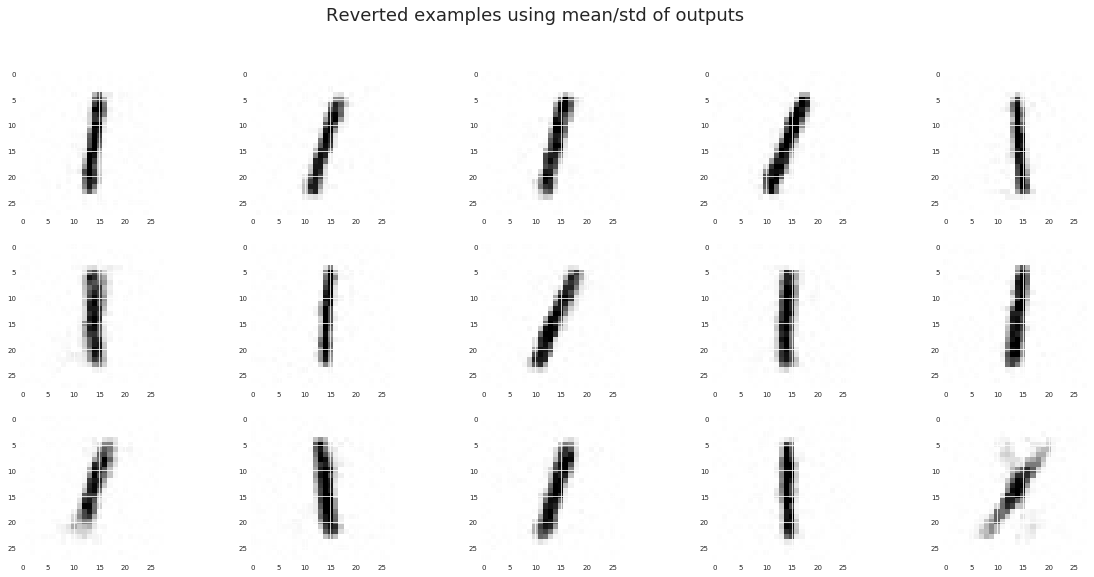

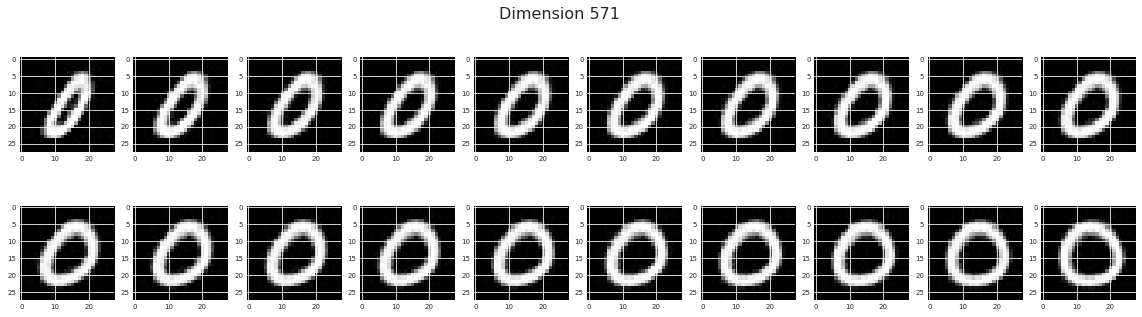

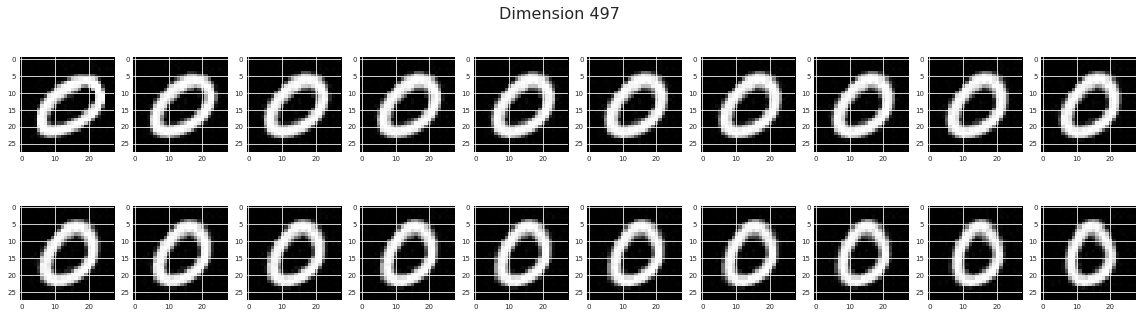

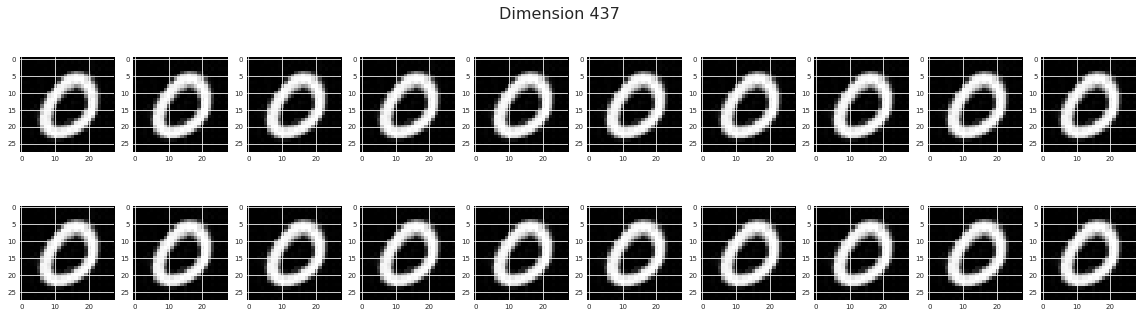

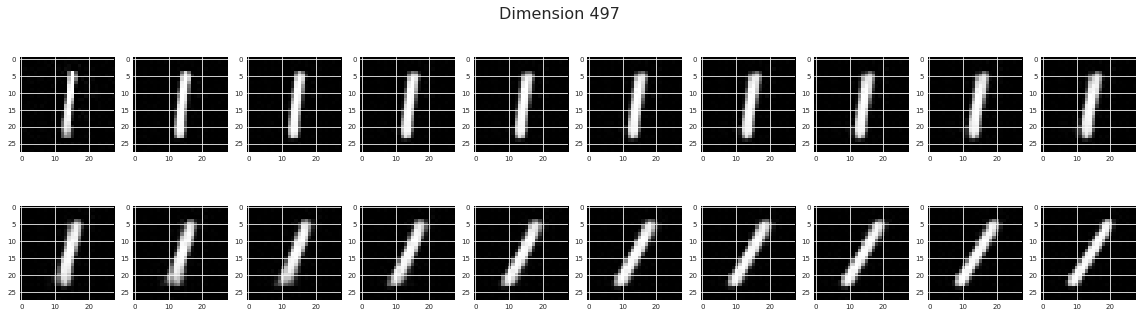

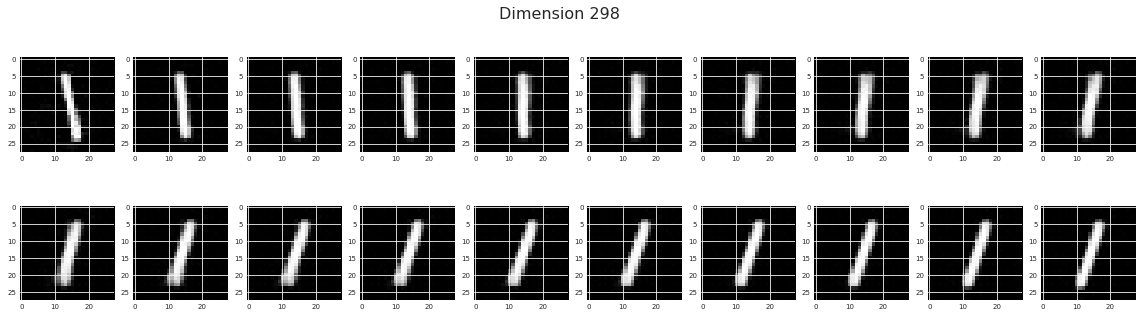

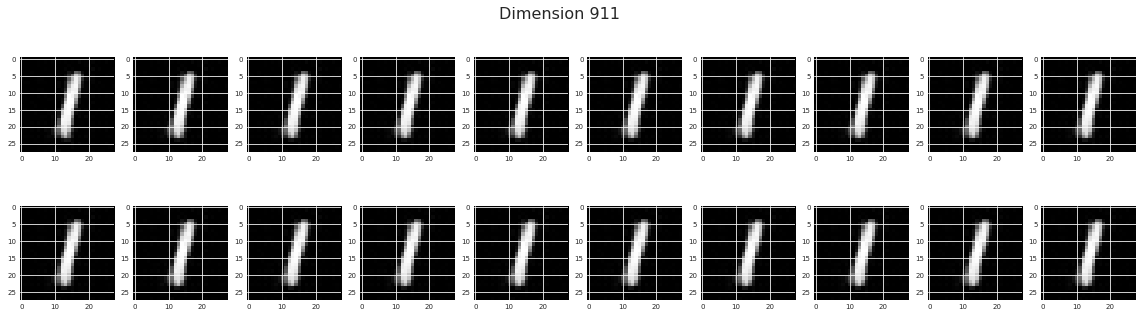

total_loss
610    1.131931

total_loss
620    1.119826

total_loss
630    1.119911

total_loss
640    1.114402

total_loss
650    1.109475

total_loss
660    1.096444

total_loss
670    1.110553

total_loss
680    1.142985

total_loss
690    1.072486

total_loss
700    1.097107

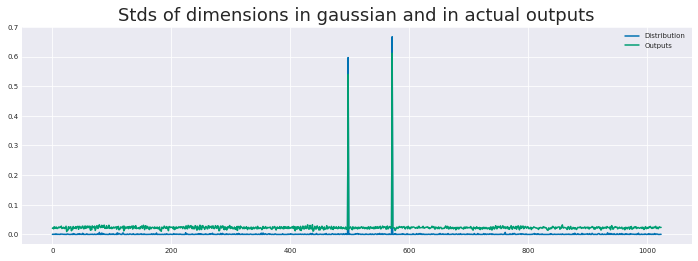

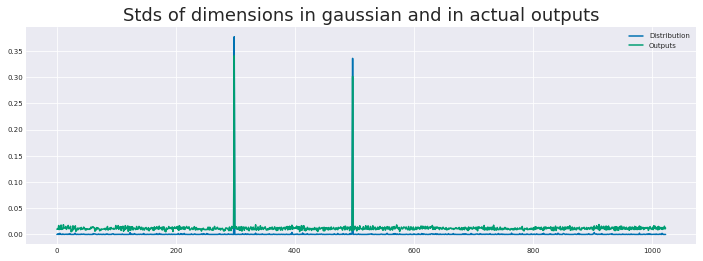

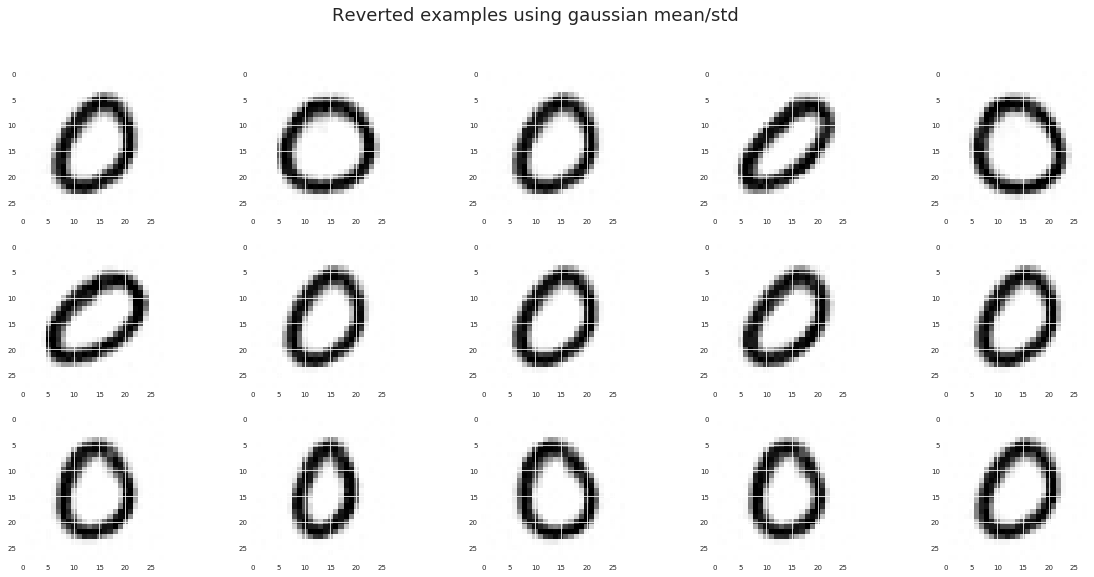

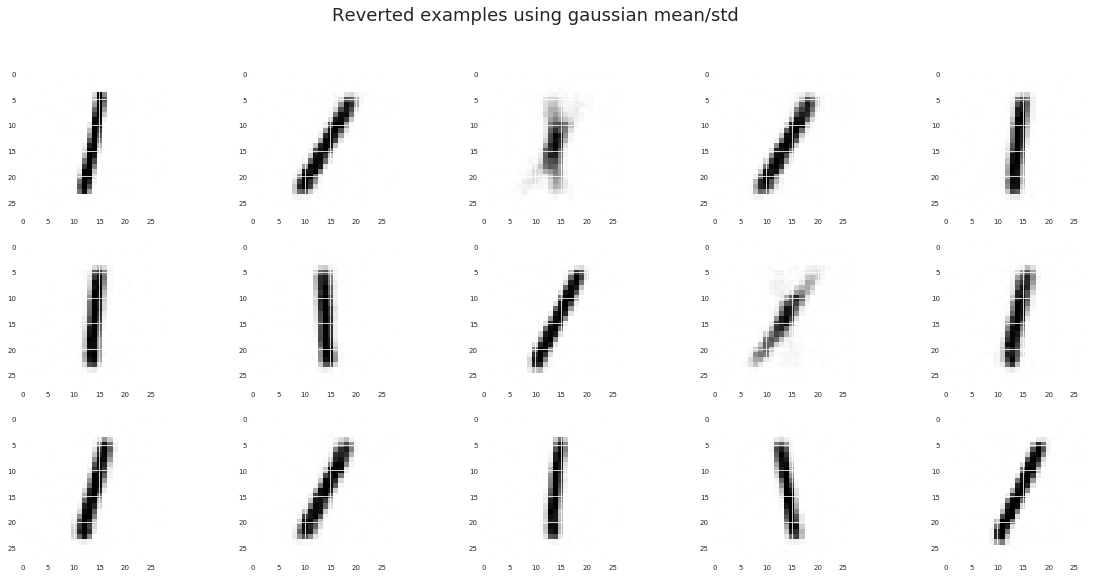

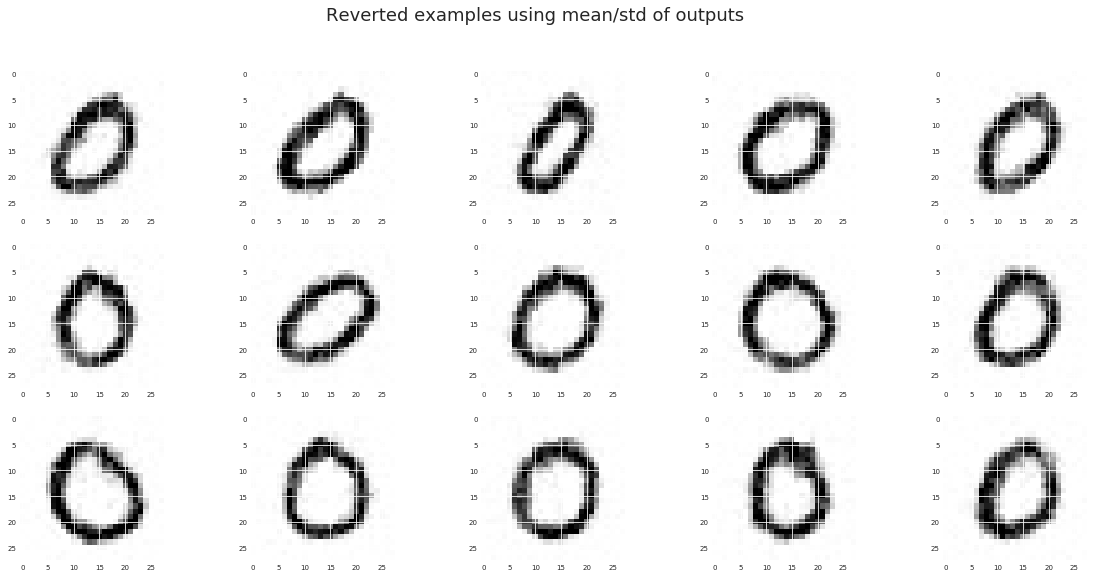

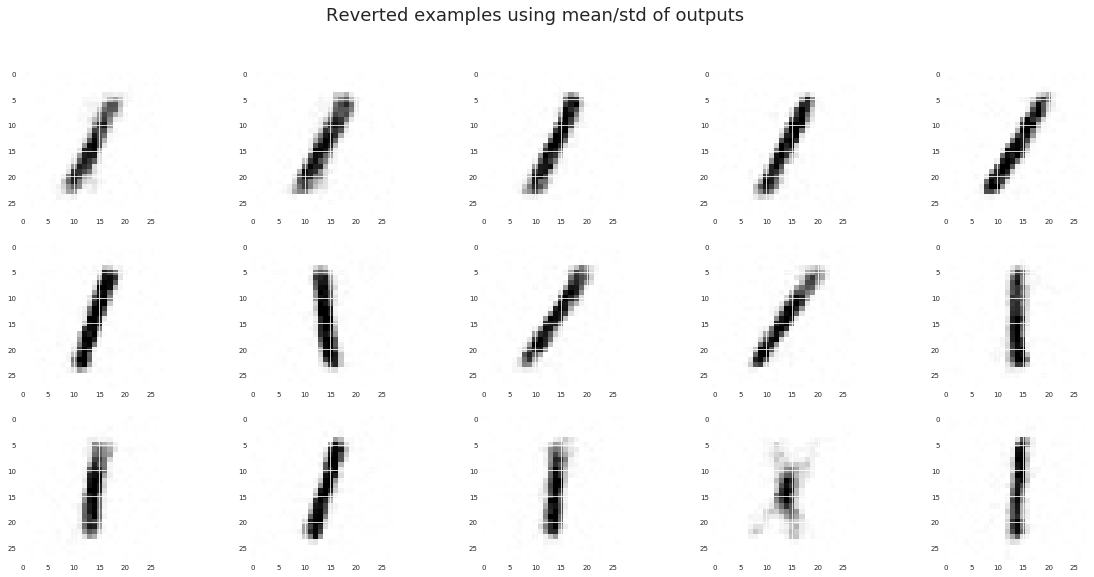

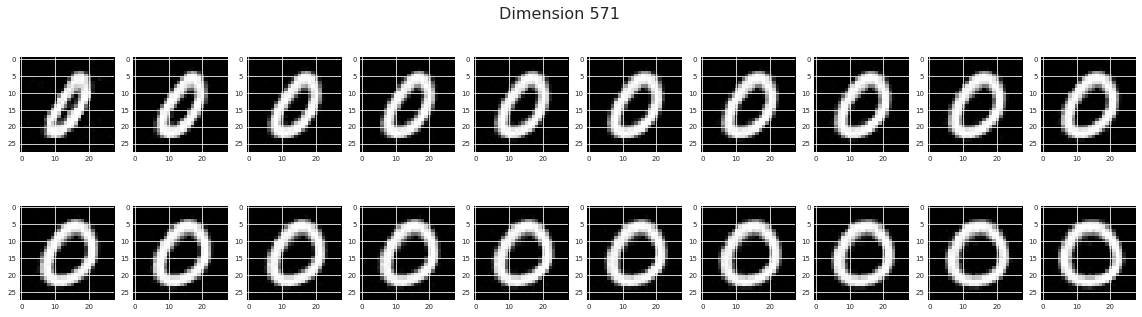

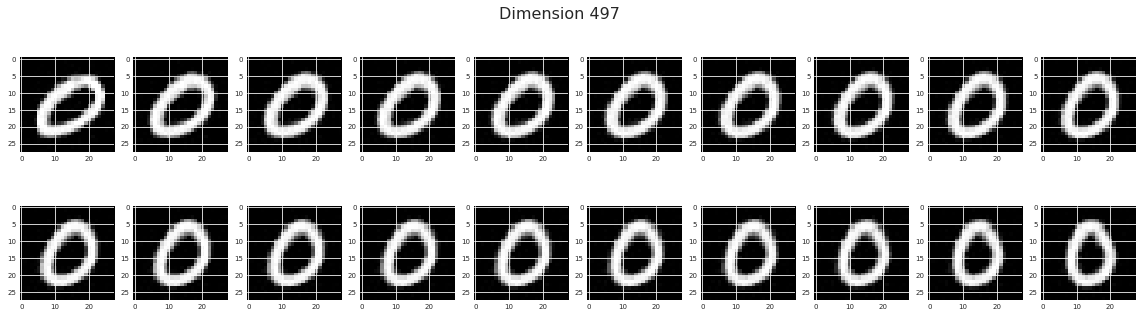

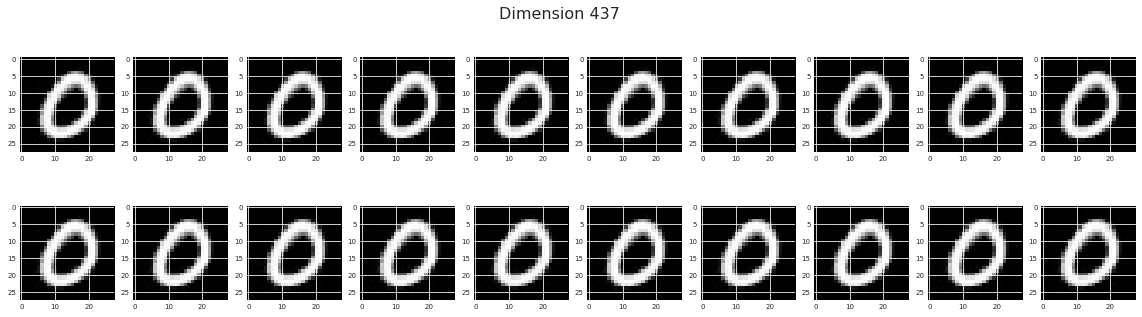

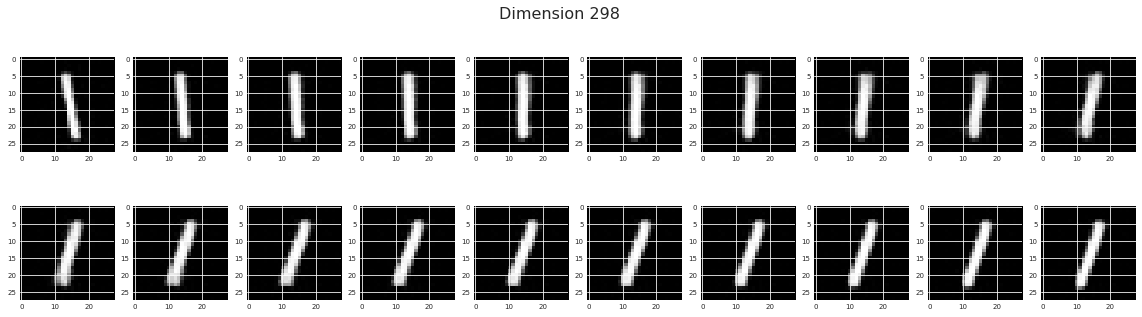

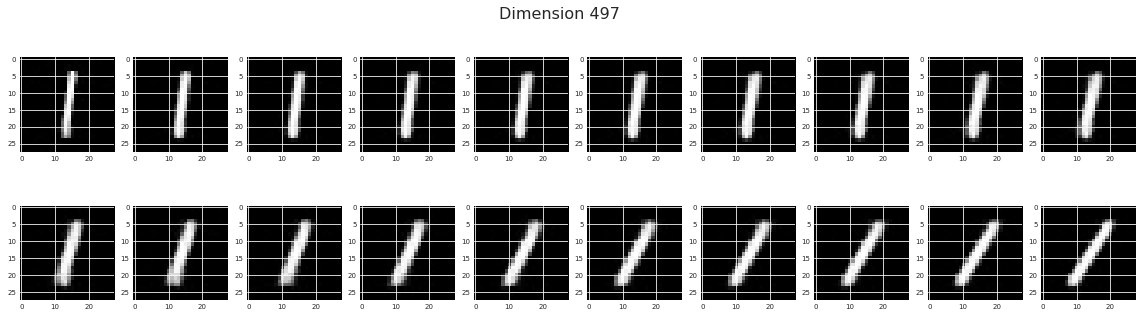

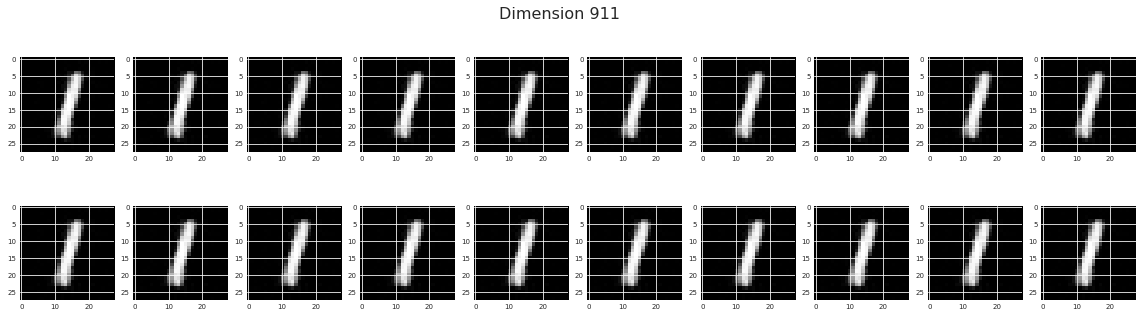

total_loss
710    1.065009

total_loss
720     1.10439

total_loss
730    1.077061

total_loss
740    1.131153

total_loss
750    1.076412

total_loss
760    1.097464

total_loss
770     1.07161

total_loss
780    1.066127

total_loss
790     1.05471

total_loss
800    1.048532

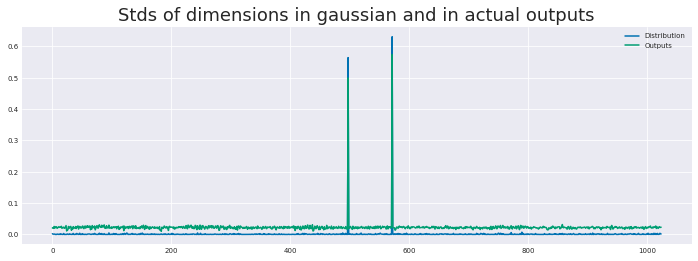

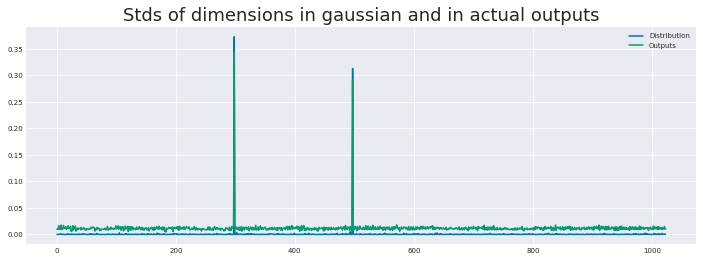

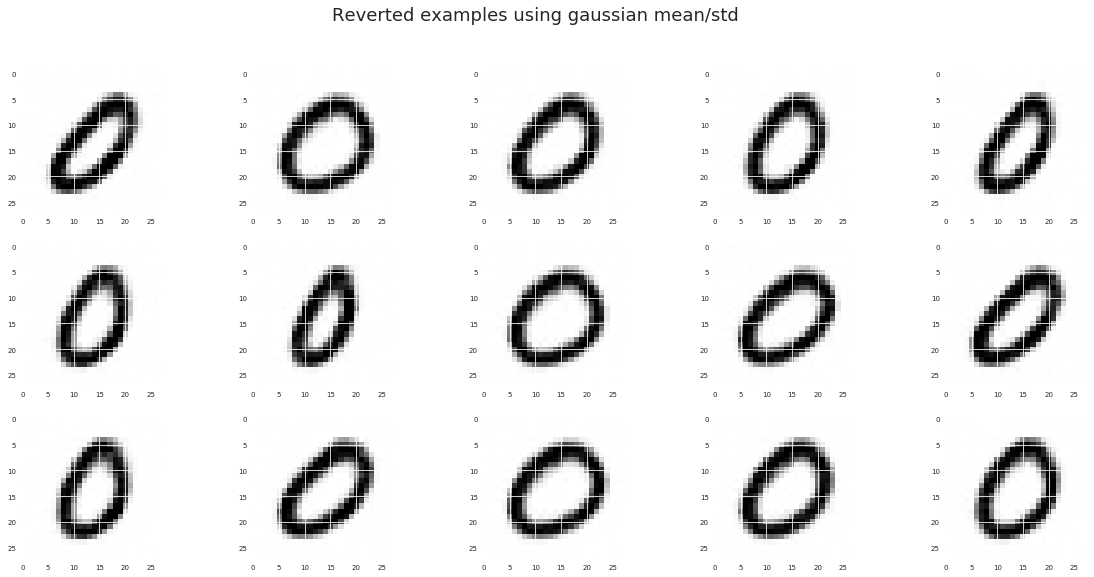

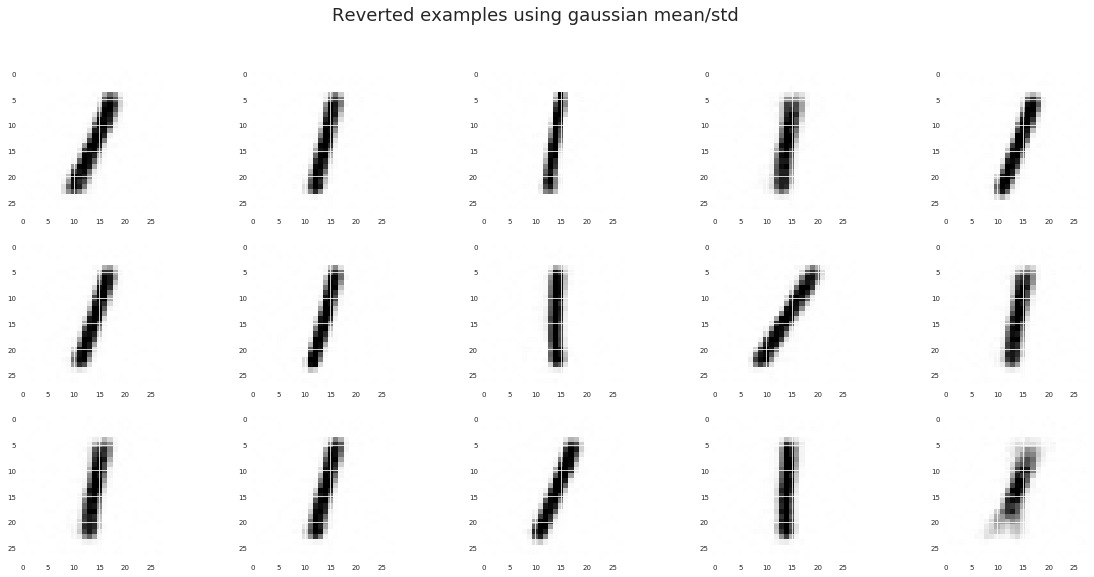

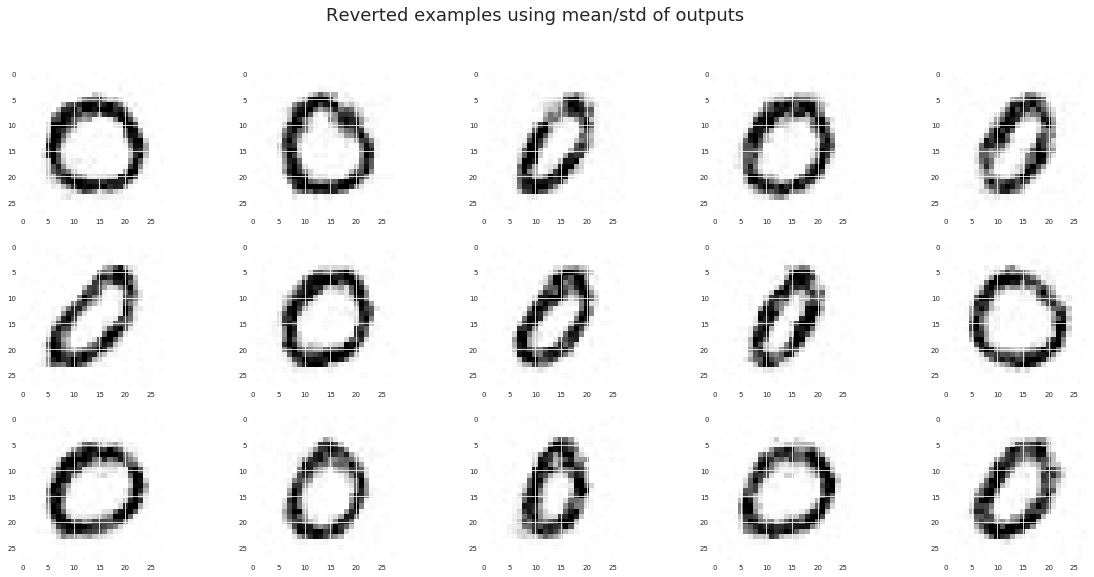

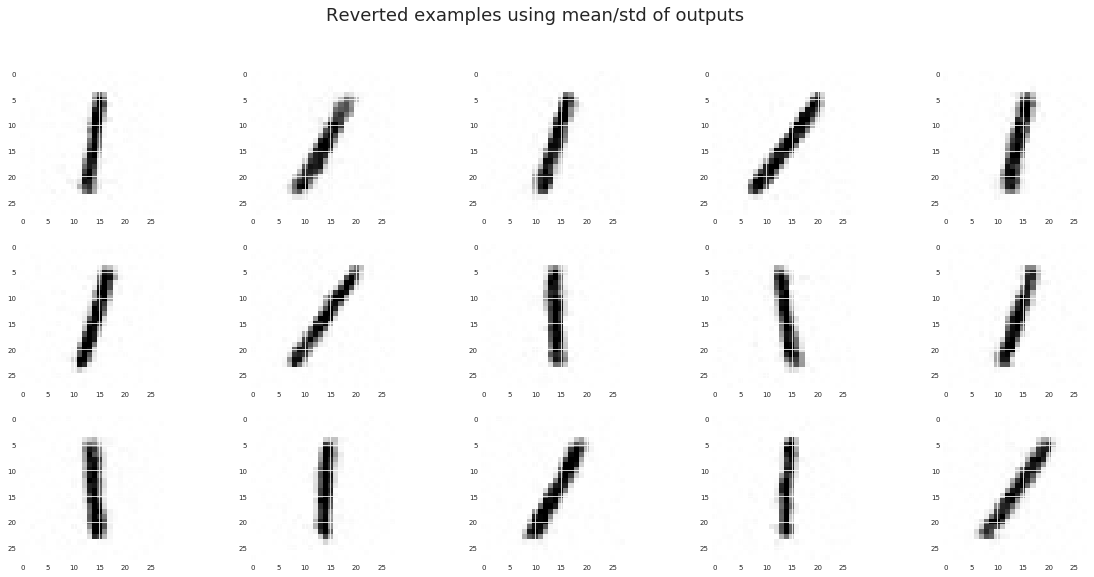

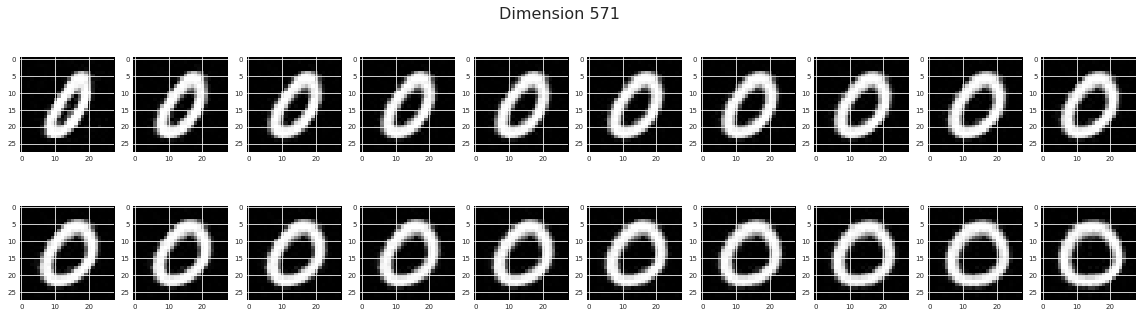

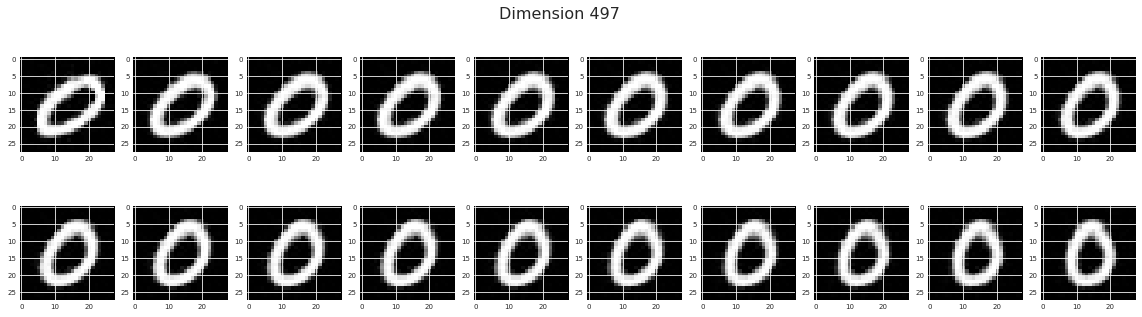

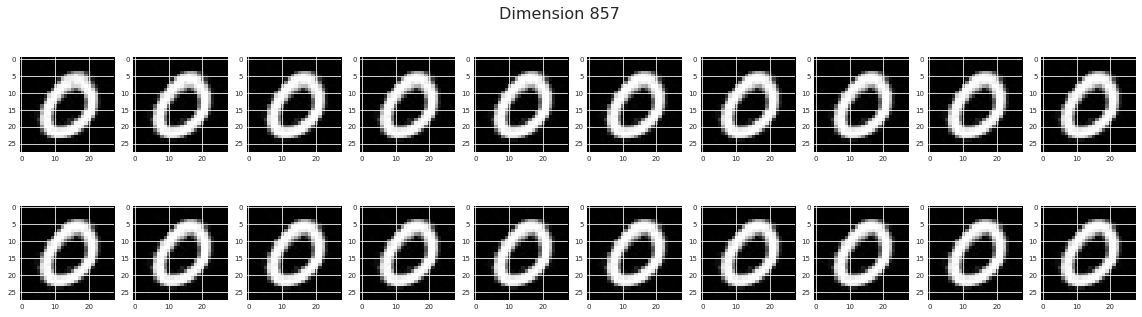

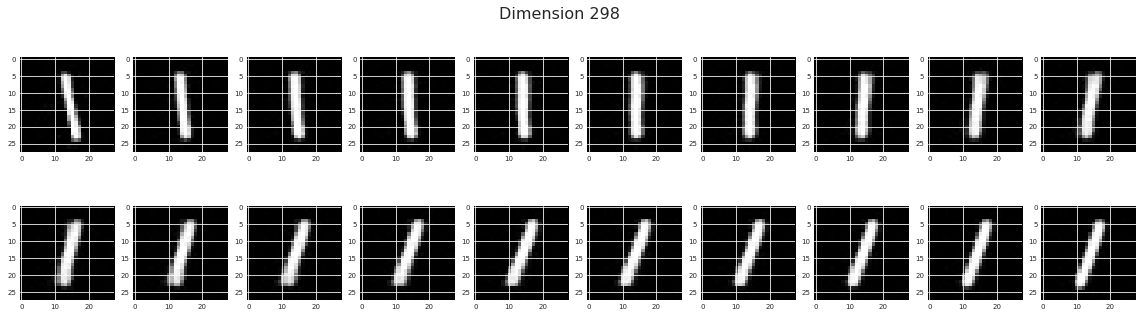

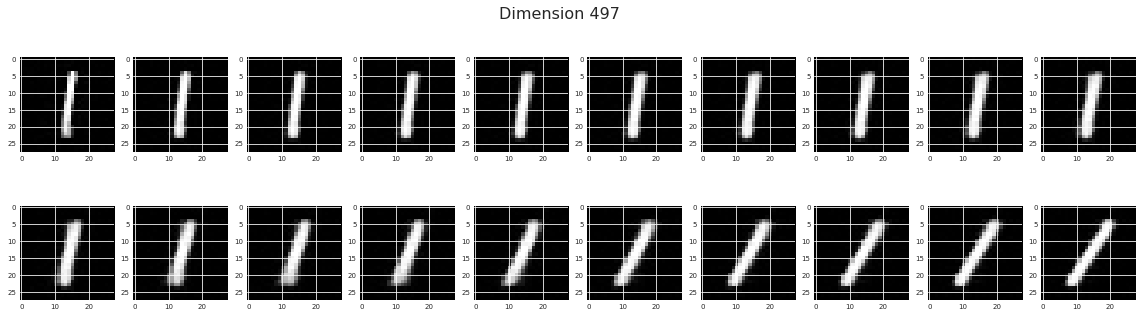

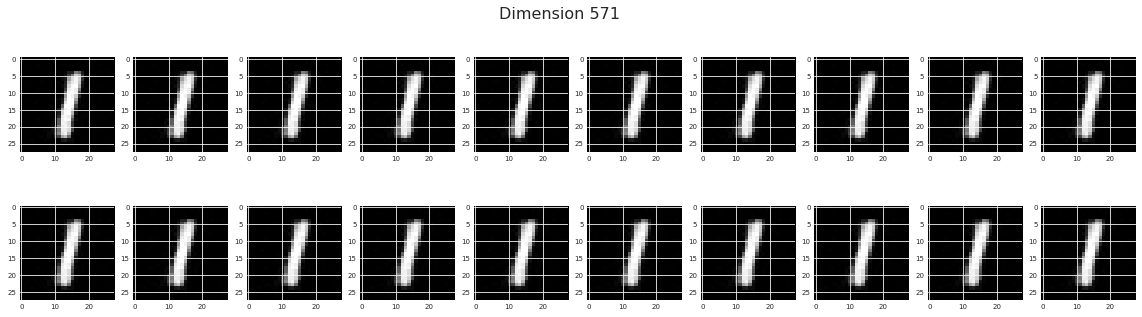

total_loss
810    1.066197

total_loss
820    1.082357

total_loss
830    1.717453

total_loss
840     1.04578

total_loss
850    1.049026

total_loss
860    1.071008

total_loss
870    1.074389

total_loss
880    1.055234

total_loss
890    1.060846

total_loss
900    1.075479

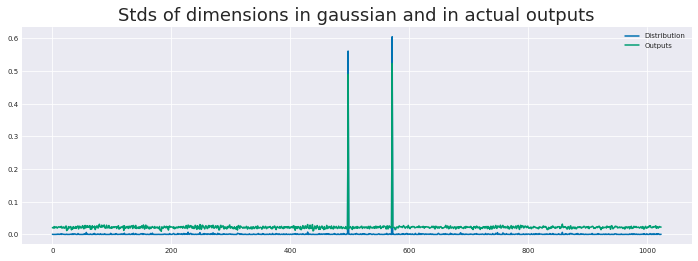

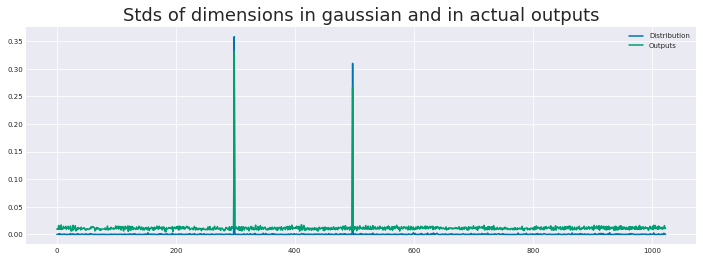

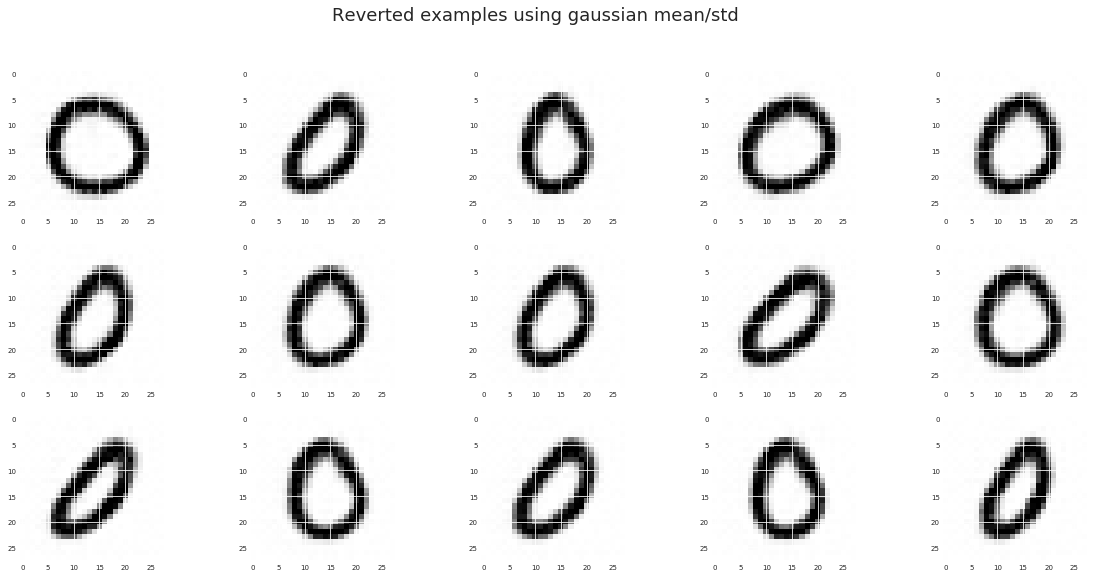

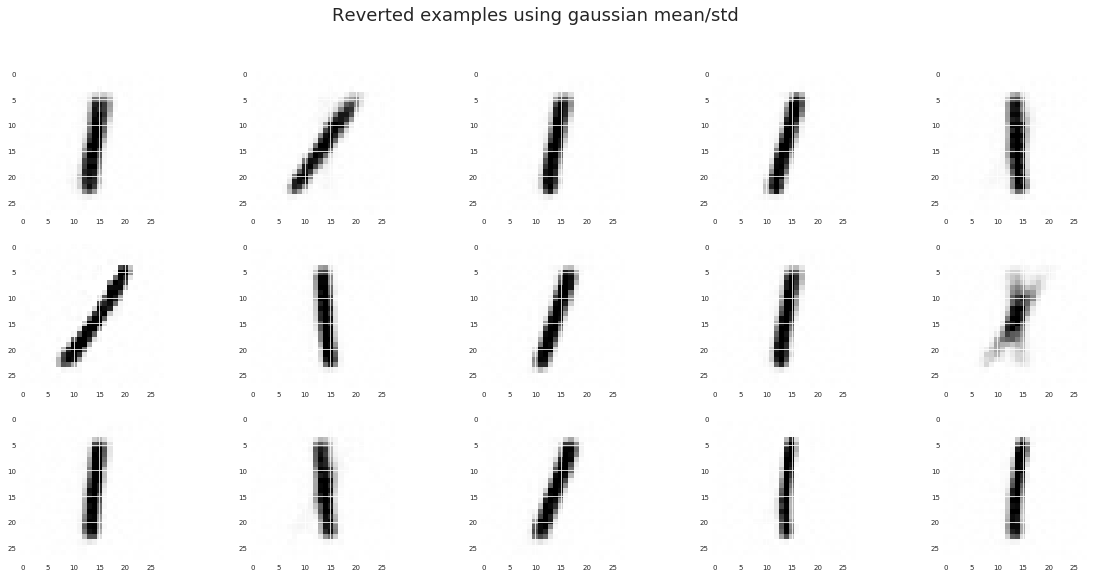

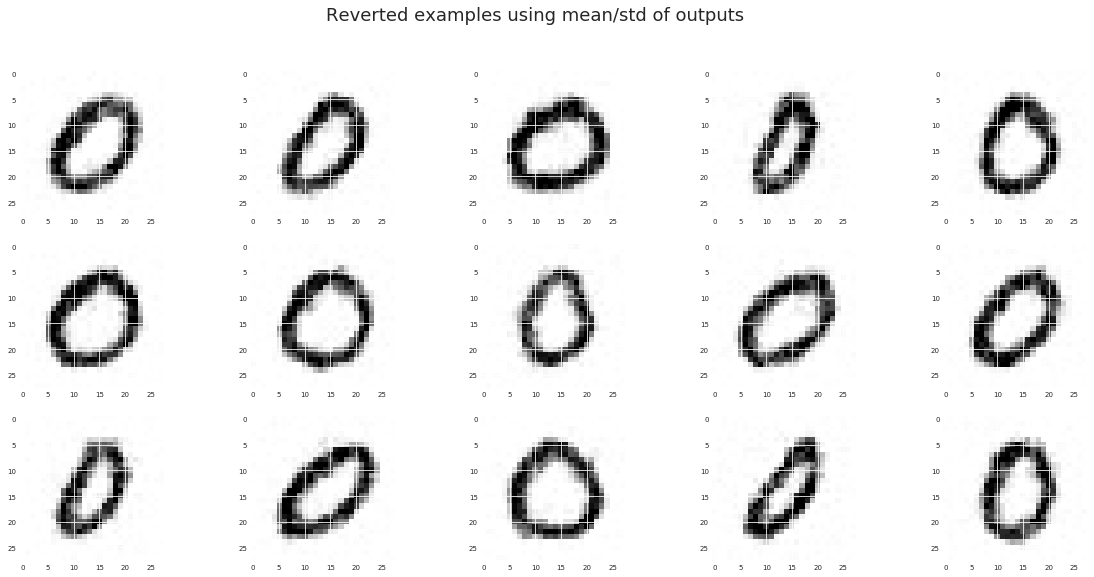

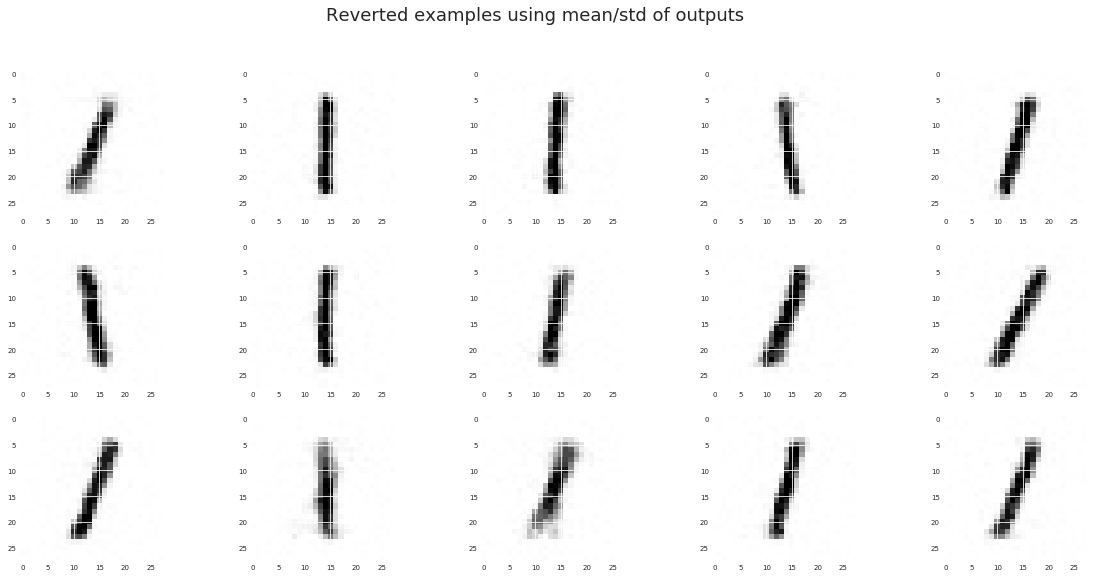

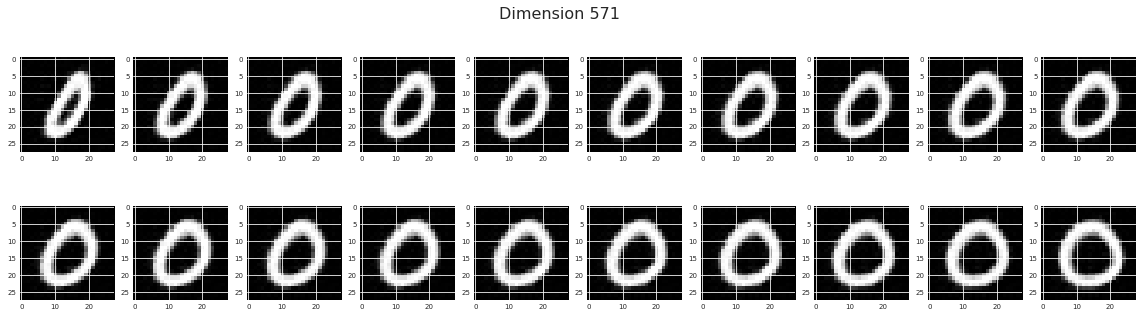

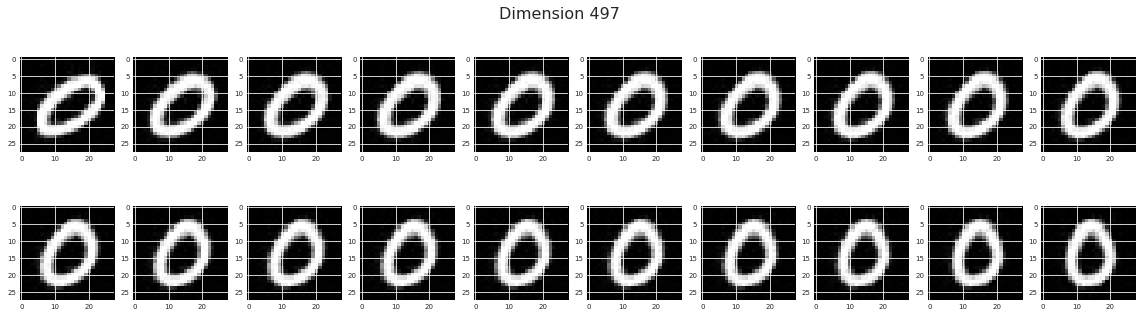

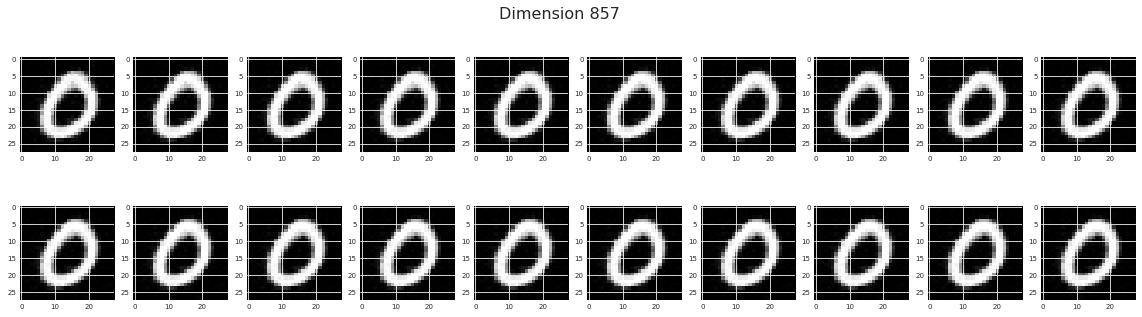

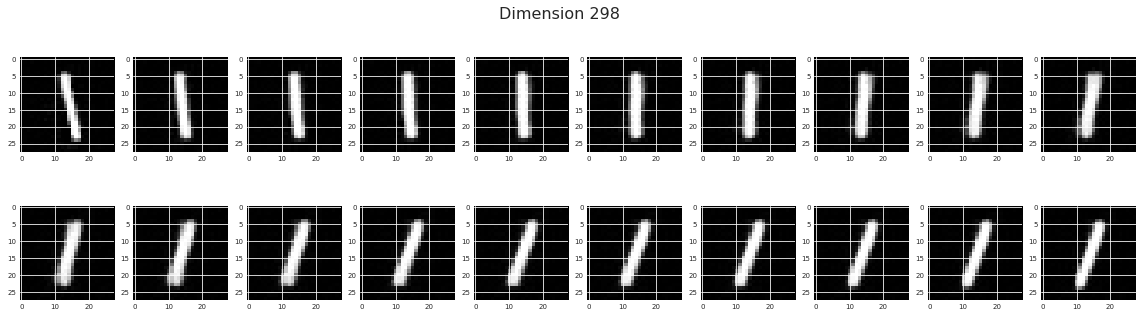

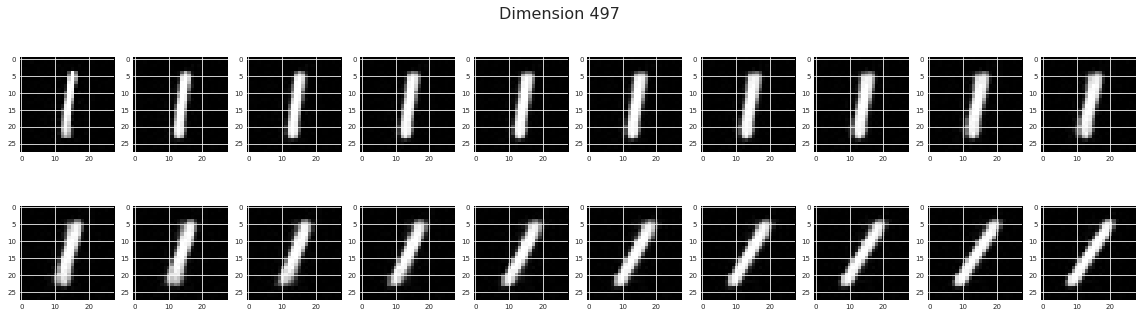

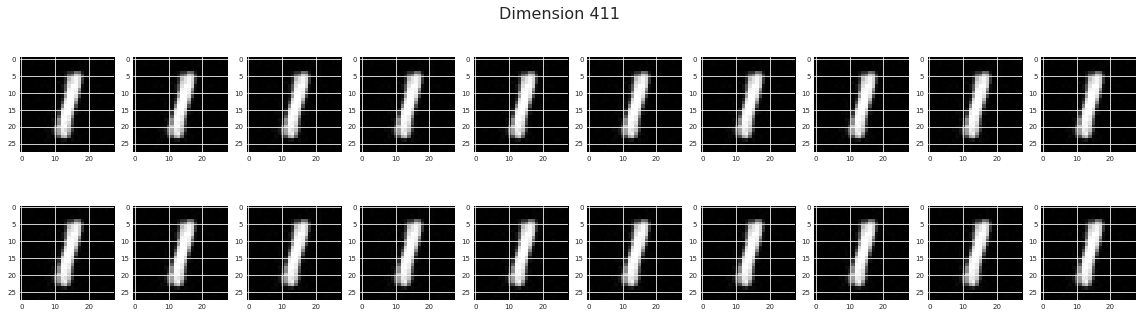

total_loss
910    1.083125

total_loss
920    1.090391

total_loss
930    1.081077

total_loss
940    1.158959

total_loss
950    1.062313

total_loss
960    1.072602

total_loss
970     1.06272

total_loss
980    1.083969

total_loss
990    1.057744

total_loss
1000    1.058676

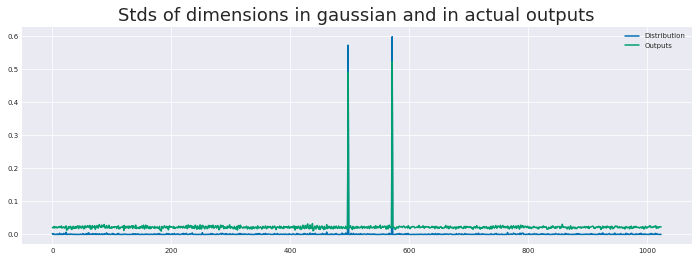

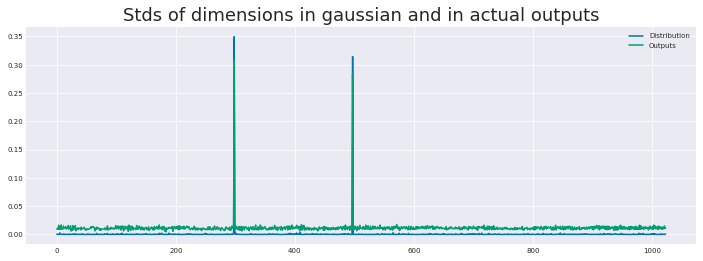

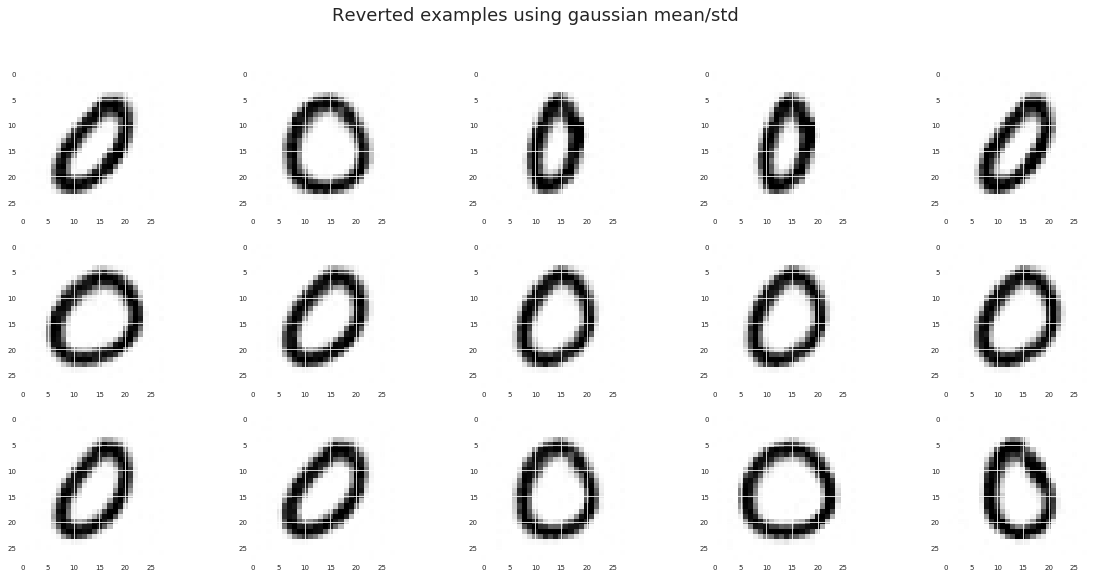

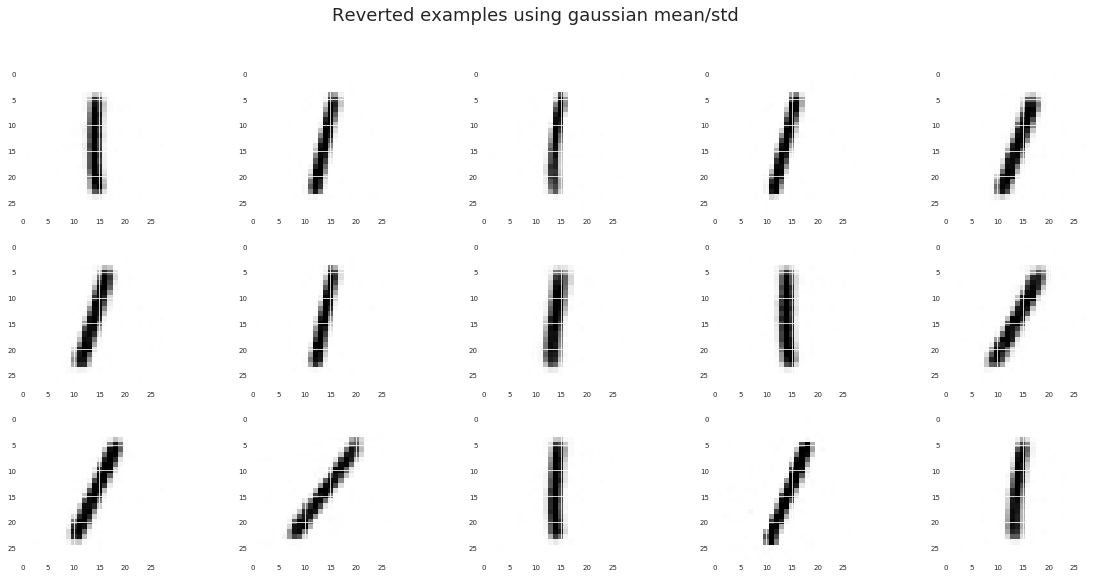

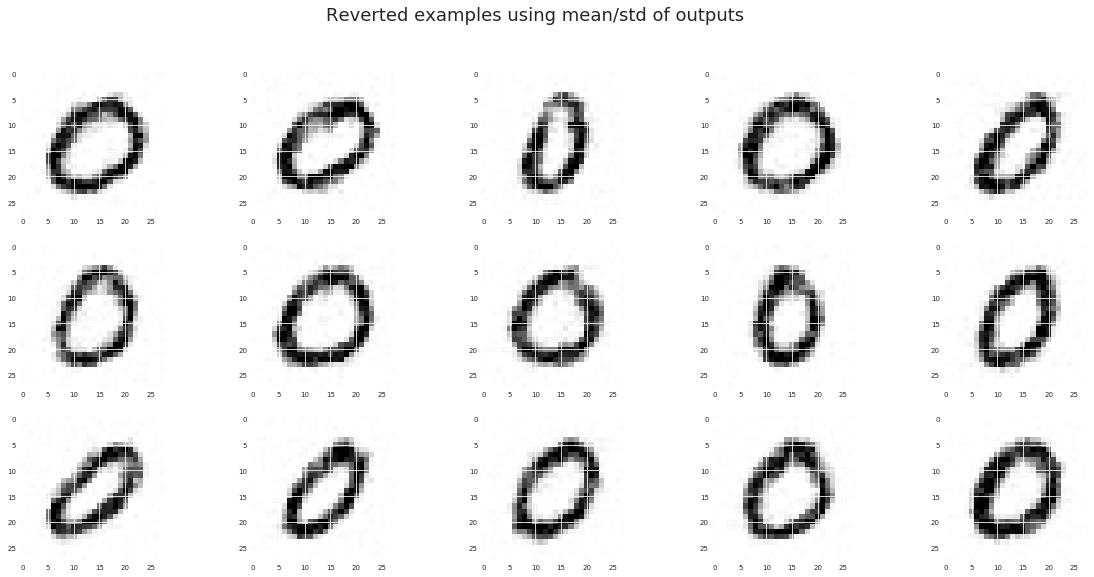

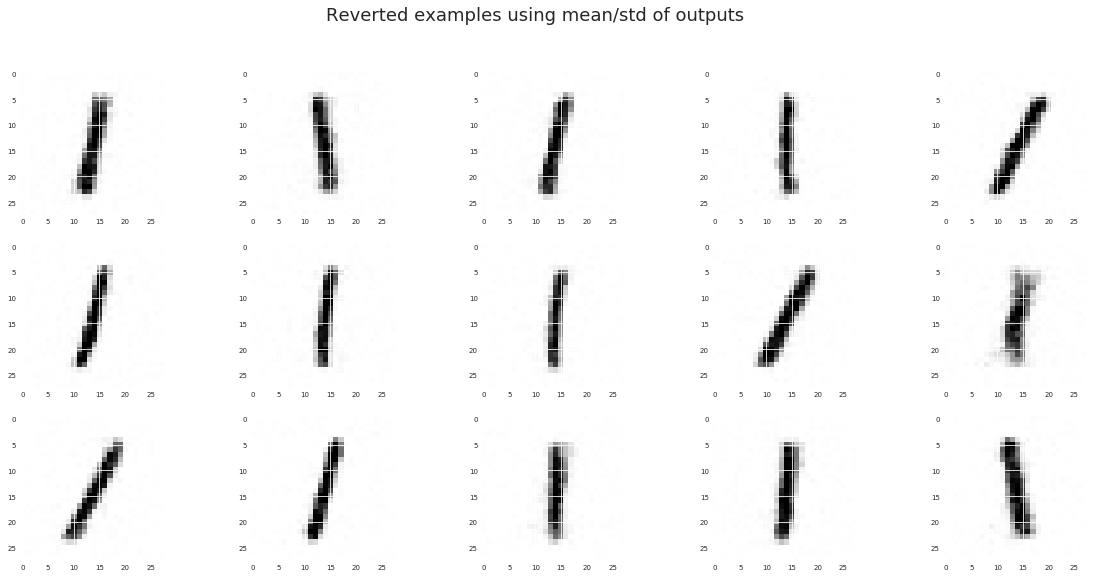

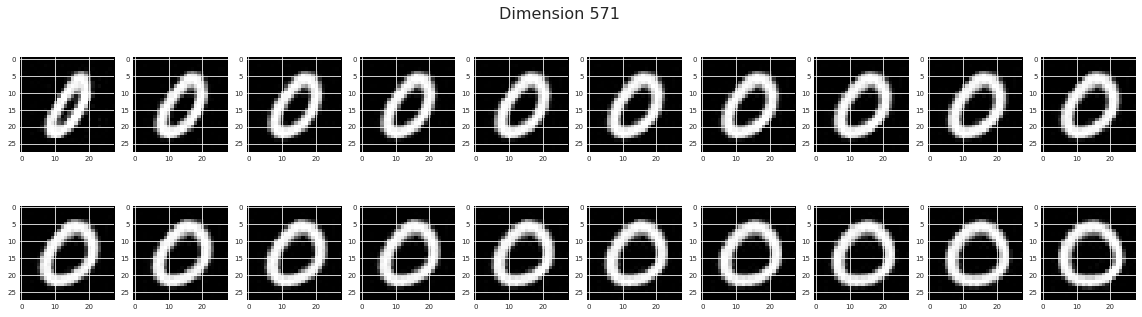

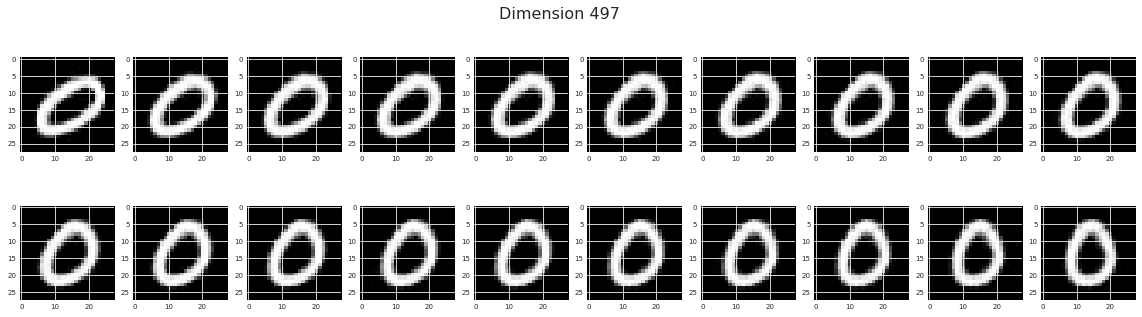

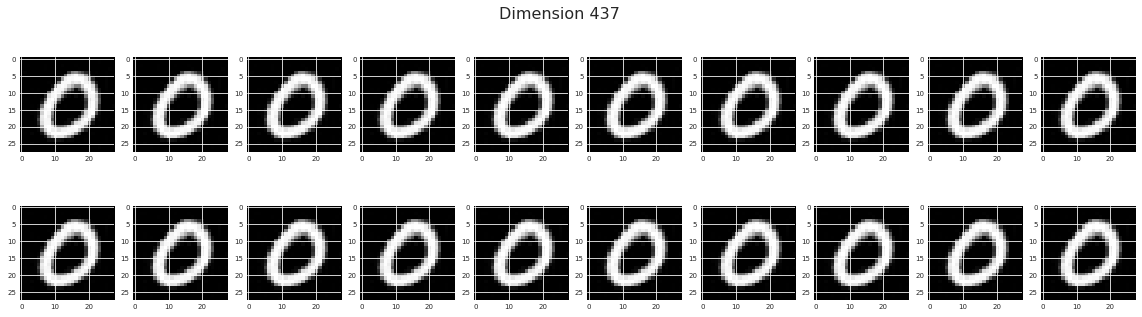

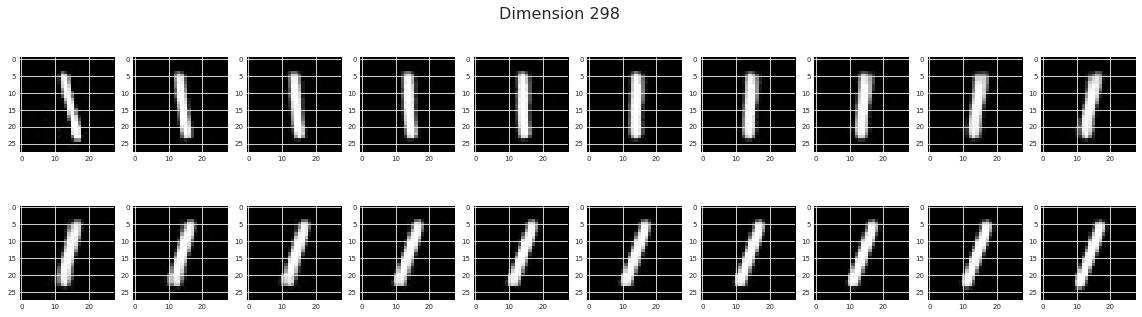

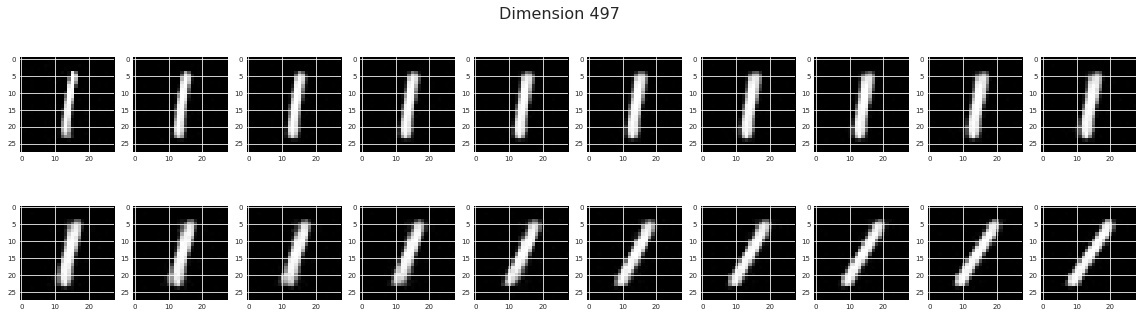

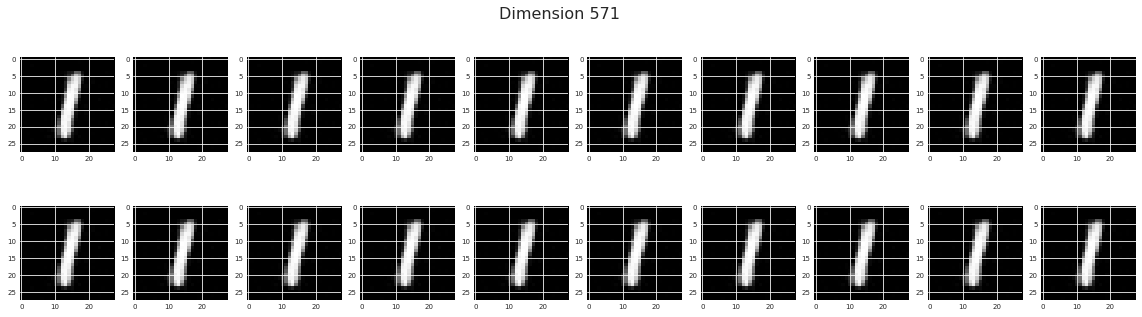

total_loss
1010    1.070713

total_loss
1020    1.243405

total_loss
1030    1.051674

total_loss
1040    1.111605

total_loss
1050    1.061482

total_loss
1060    1.084098

total_loss
1070    1.098214

total_loss
1080    1.053605

total_loss
1090    1.073634

total_loss
1100    1.046402

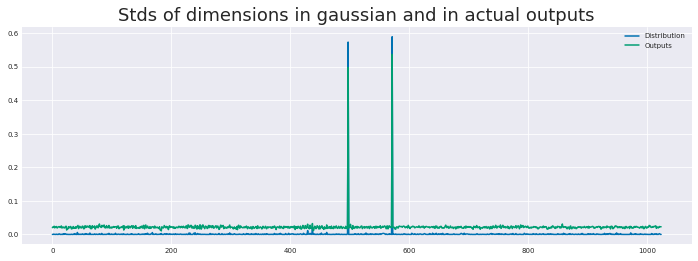

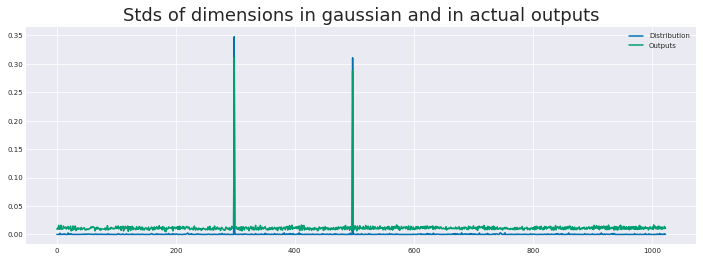

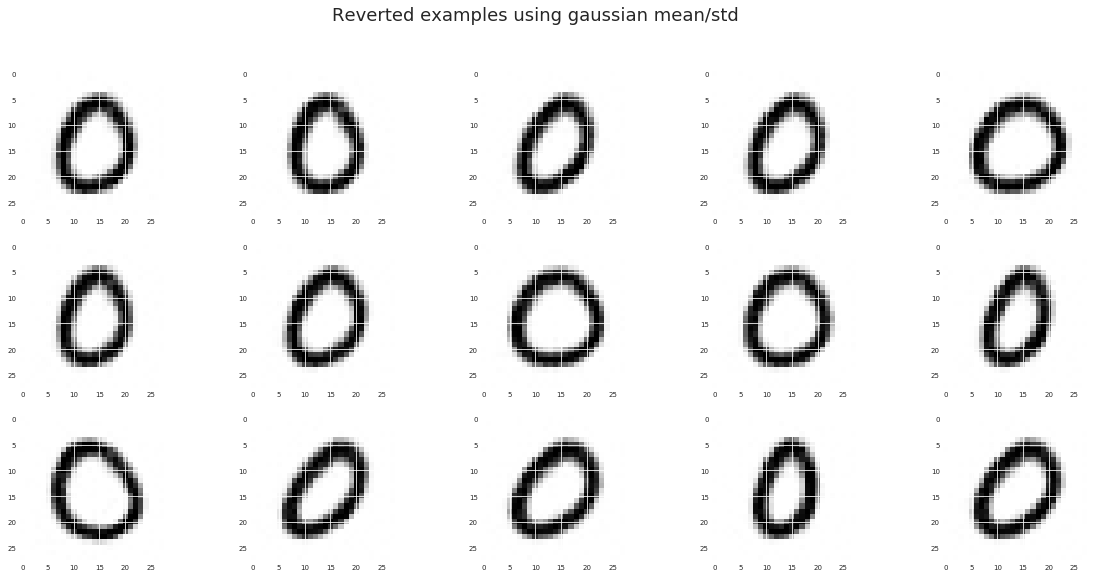

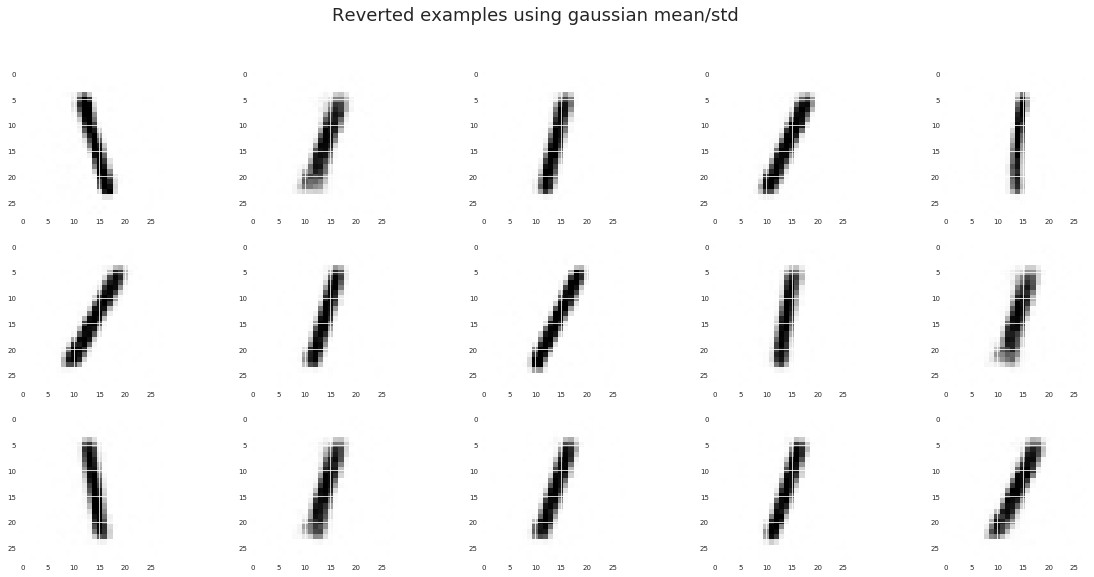

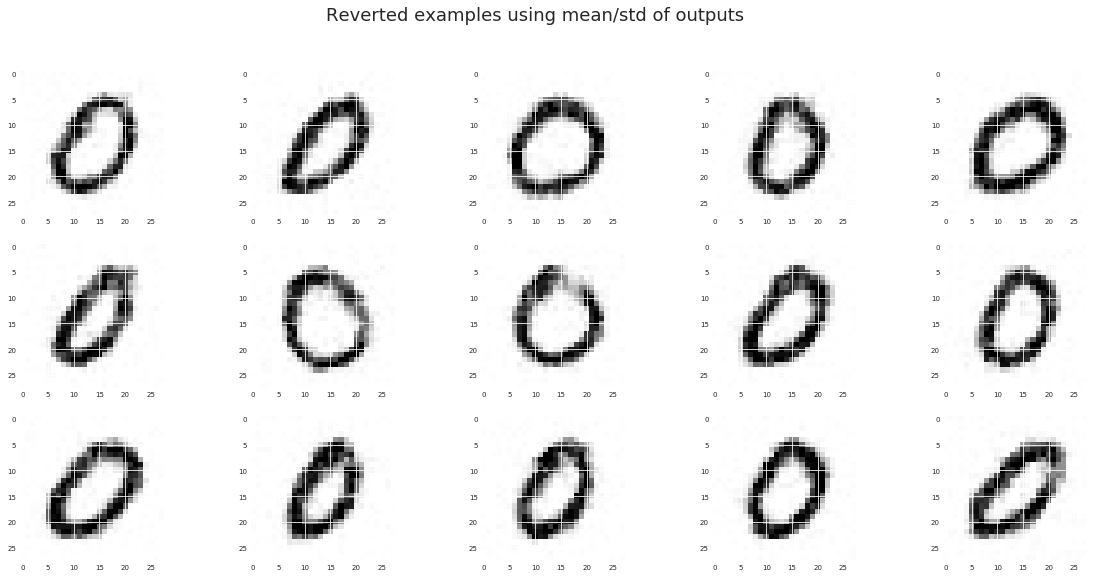

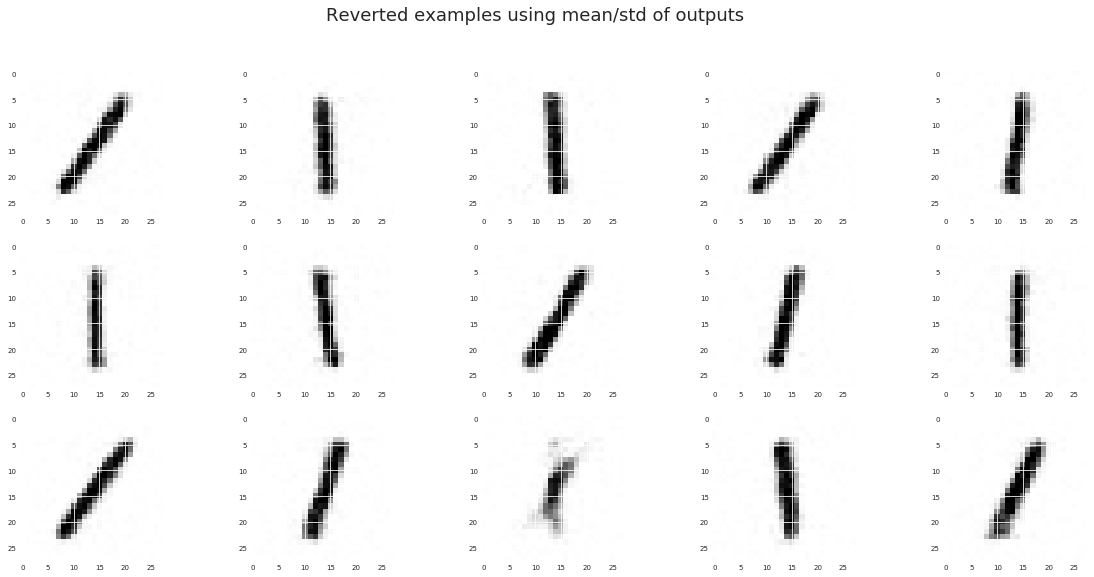

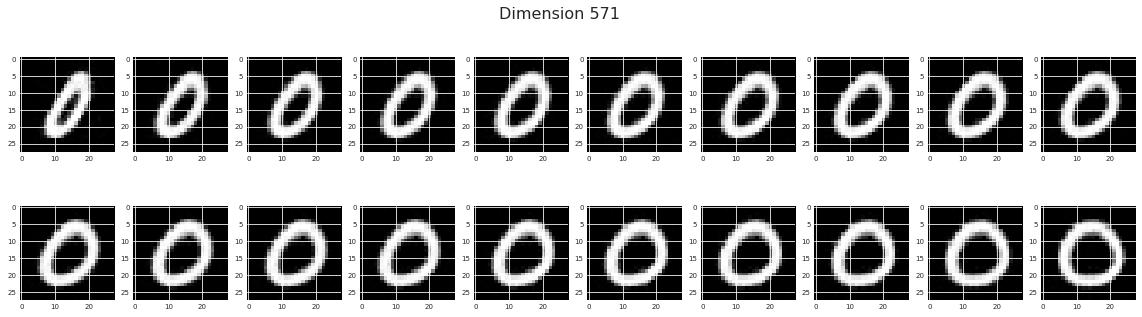

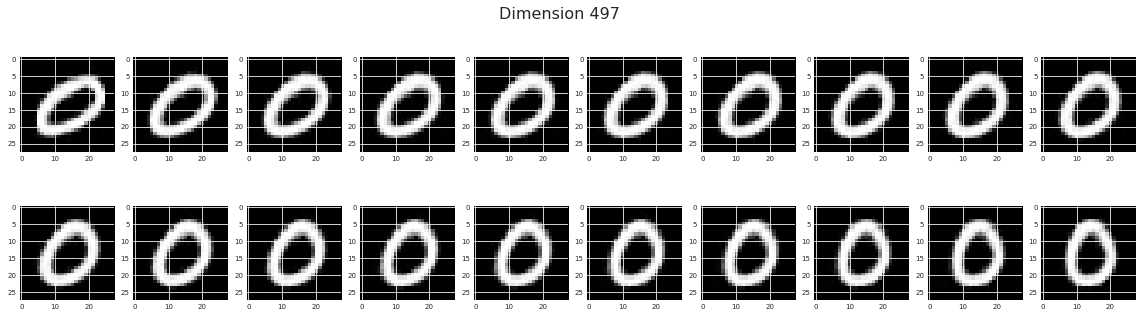

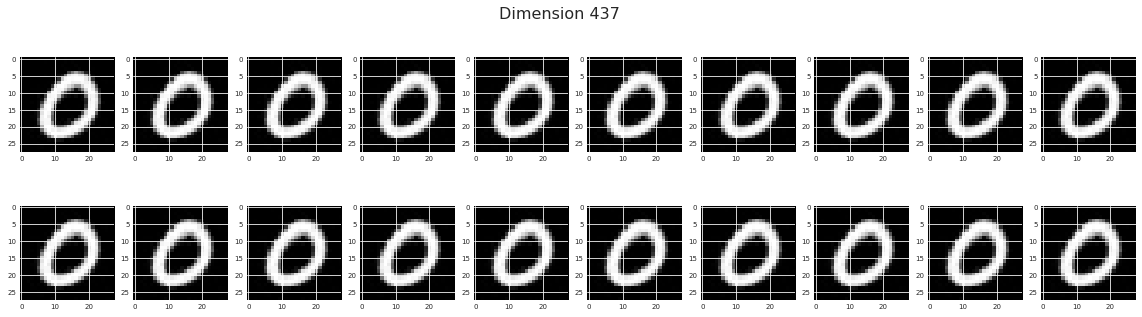

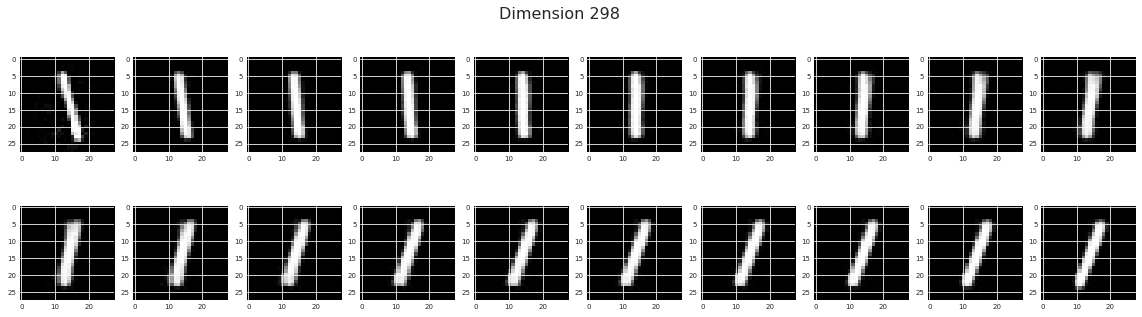

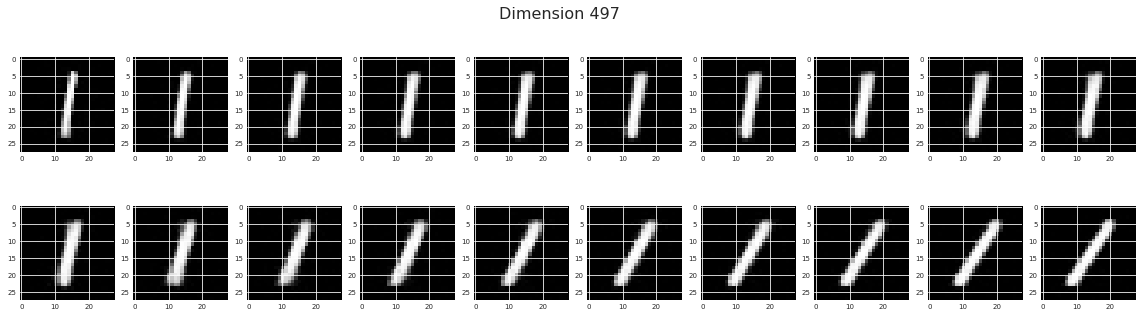

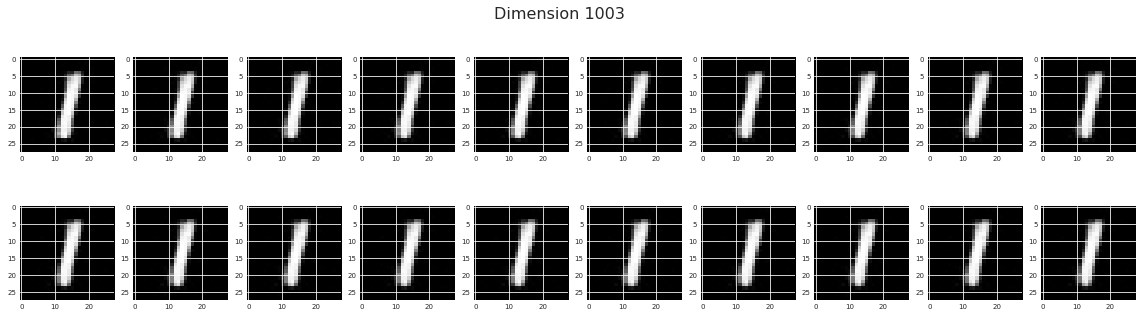

total_loss
1110     1.01003

total_loss
1120    1.074396

total_loss
1130    1.065643

total_loss
1140    1.080339

total_loss
1150    1.191262

total_loss
1160    1.260145

total_loss
1170     1.04088

total_loss
1180    1.013155

total_loss
1190    1.046548

total_loss
1200    1.037372

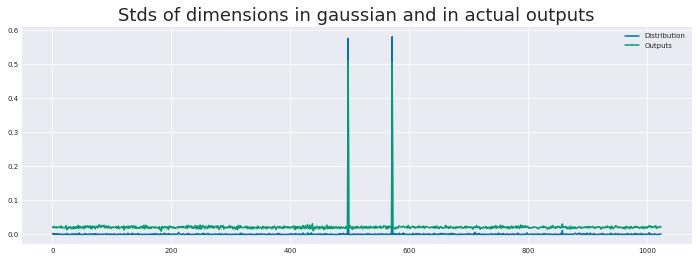

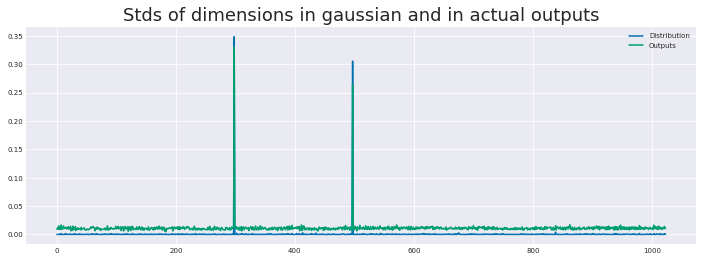

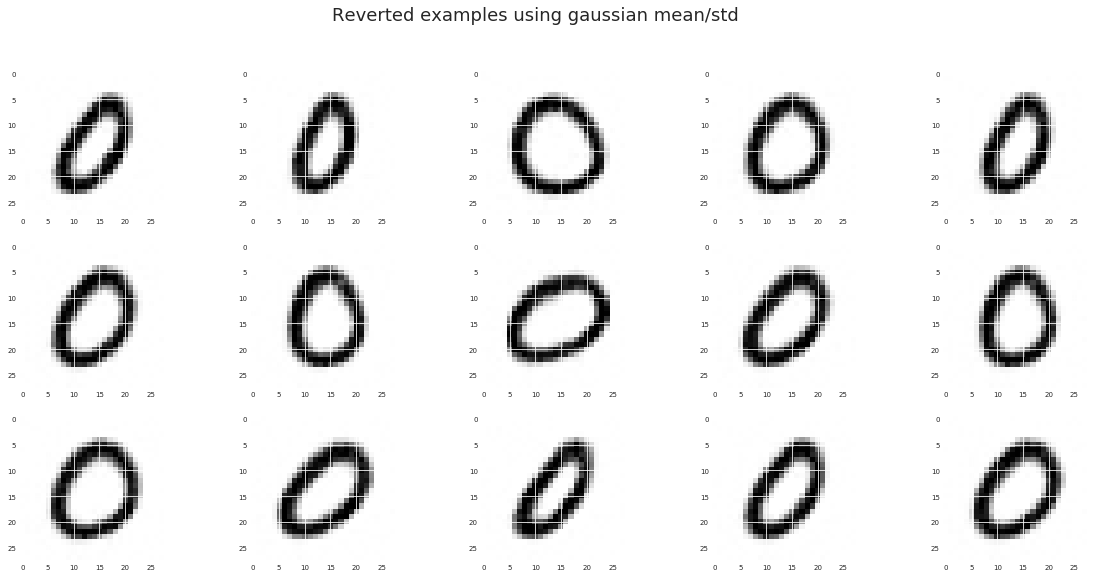

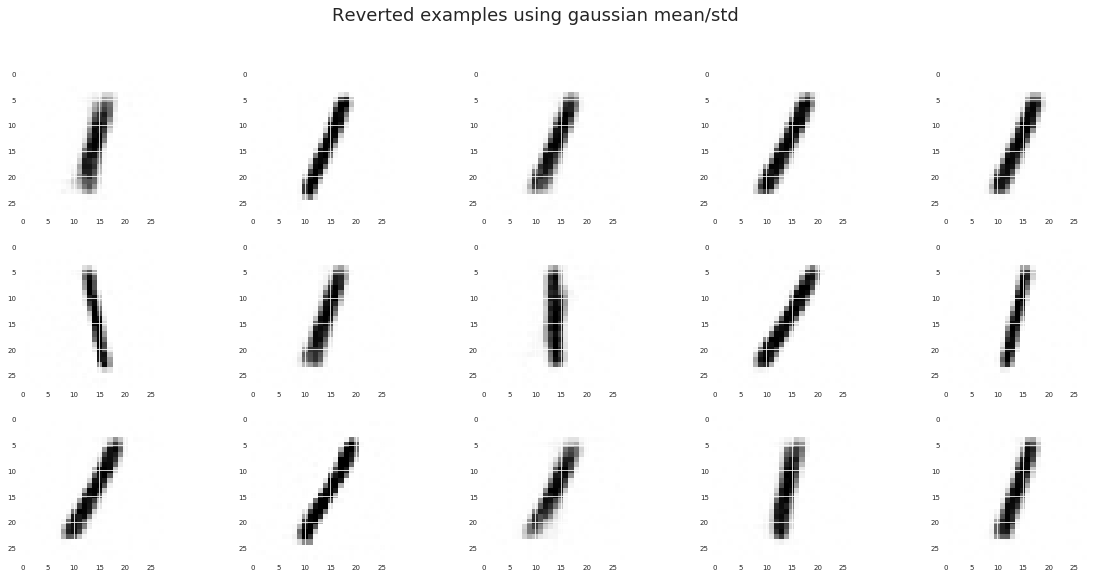

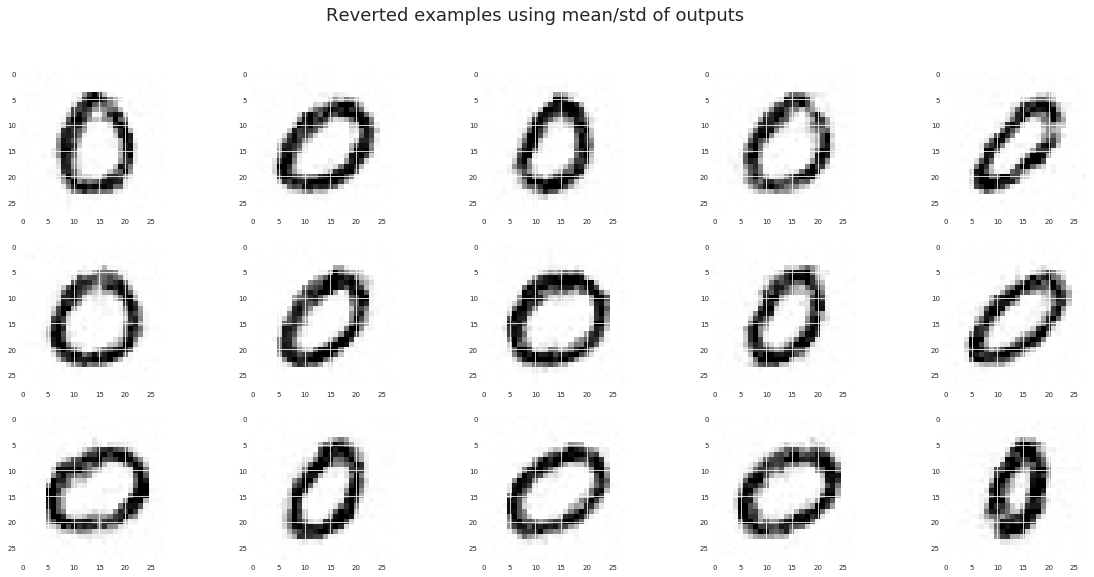

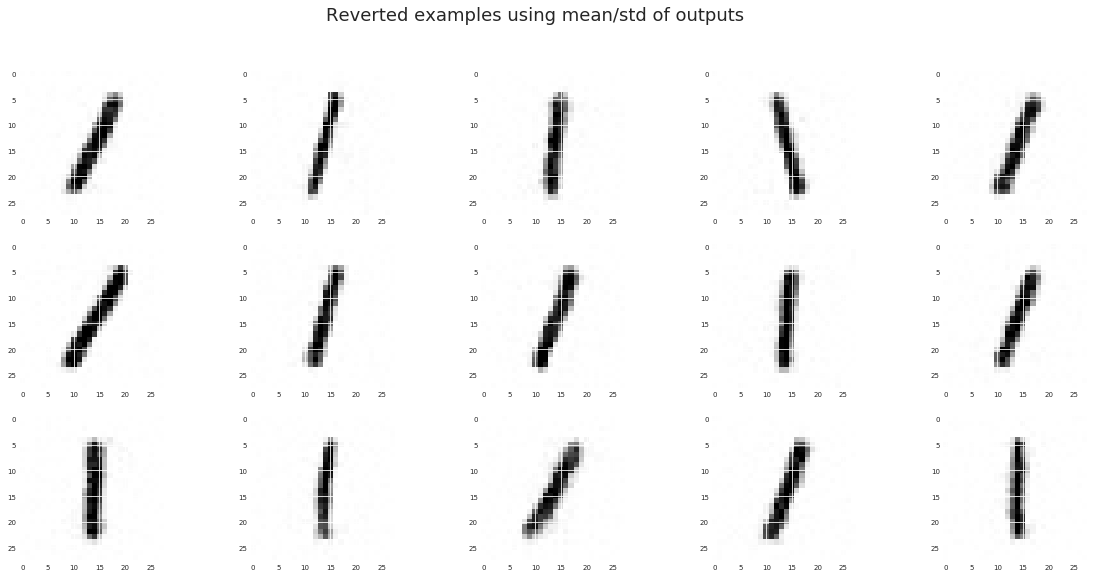

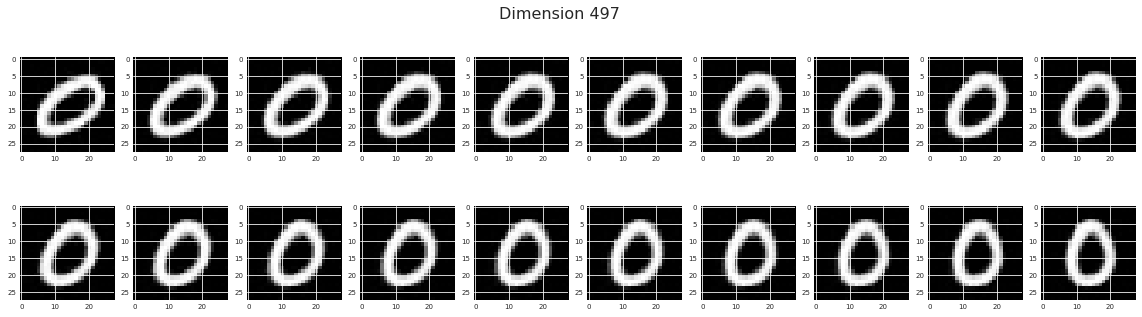

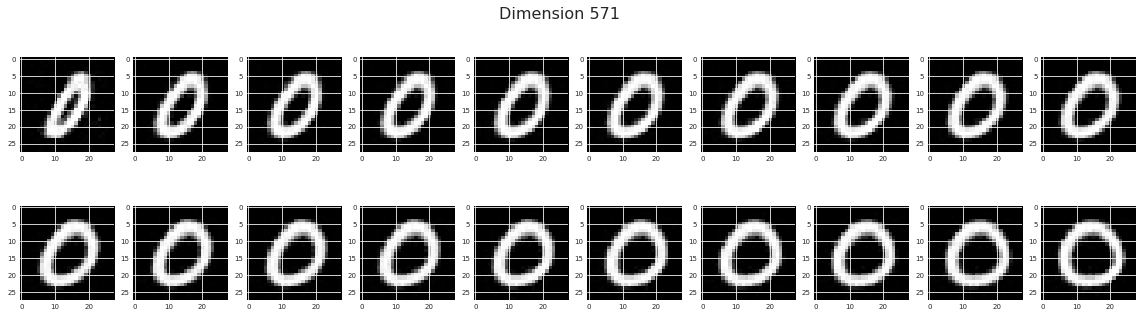

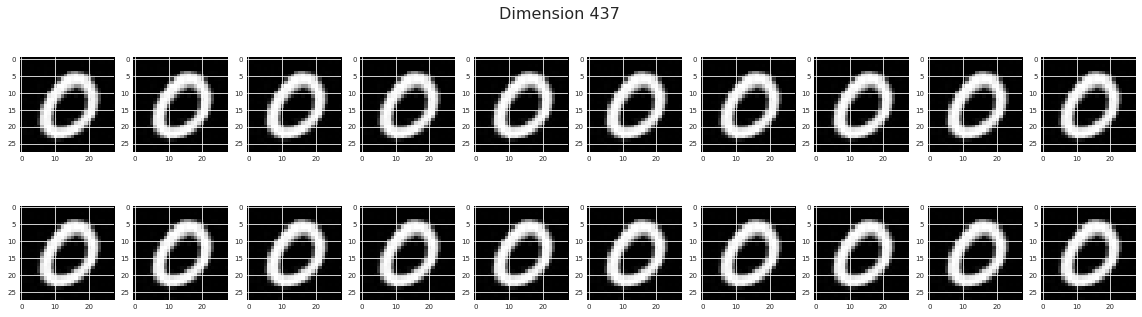

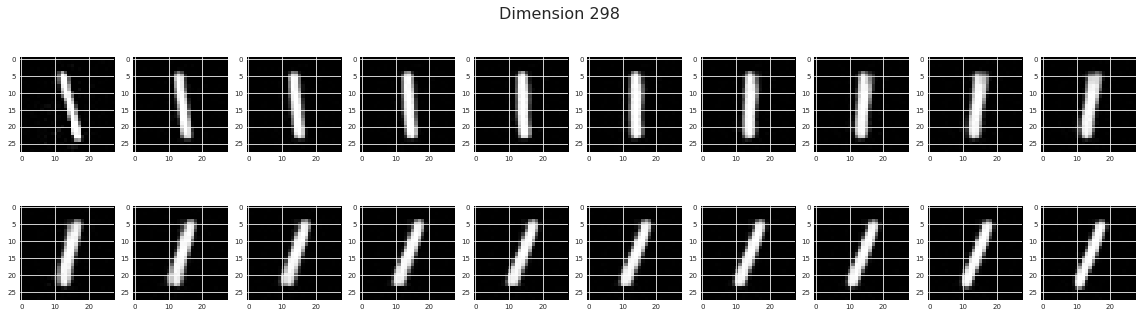

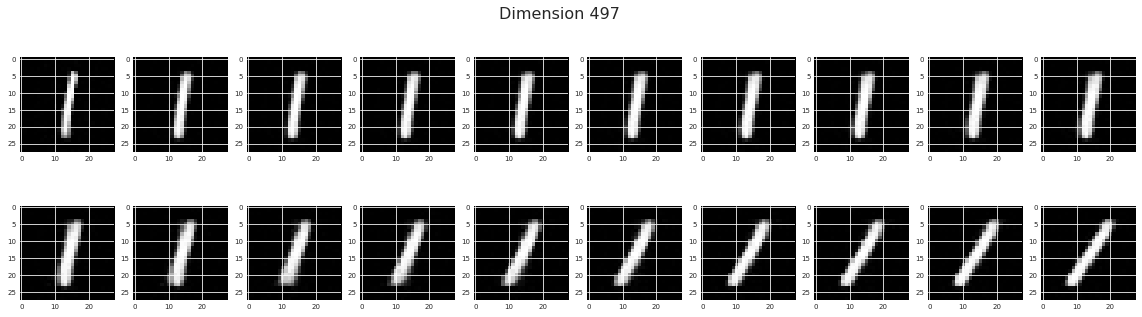

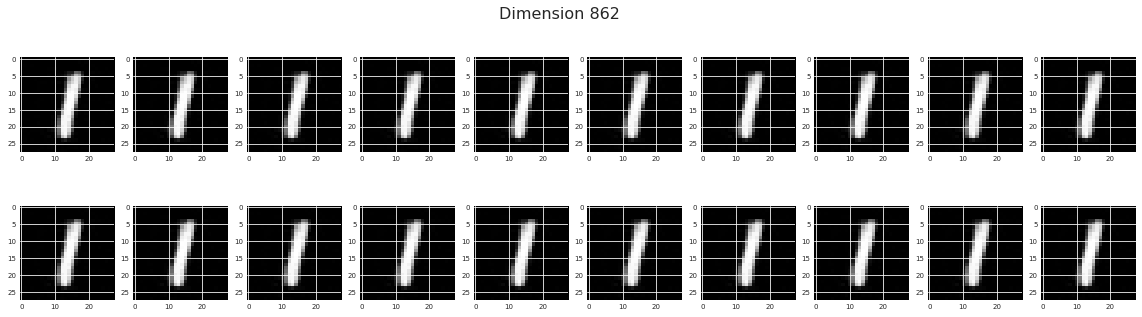

total_loss
1210    1.043832

total_loss
1220    1.064643

KeyboardInterrupt: 

In [13]:
import pandas as pd
from reversible.util import var_to_np
from reversible.revnet import get_inputs_from_reverted_samples

rng = RandomState(1)
epochs_dataframe = pd.DataFrame()
for i_epoch in range(100001):
    feature_model.train()
    for i_update in range(n_updates_per_epoch):
        if i_update % (n_critic_updates + 1) == n_critic_updates:
            # now run generator
            loss = train_one_batch(iterator, feature_model, loss_fn, means_per_dim, stds_per_dim, optimizer)
            stds_per_dim.data.clamp_(min=0)
        else:
            loss = train_one_batch(iterator, feature_model, loss_fn_adv, means_per_dim, stds_per_dim, optimizer_adv)
            stds_per_dim.data.clamp_(min=0) # should not be necessary...
    feature_model.eval()
    epochs_dataframe = epochs_dataframe.append({
        'total_loss': np.mean(loss),
    },
        ignore_index=True)
    if i_epoch % 10 == 0:
        display(epochs_dataframe.iloc[-1:])
    if i_epoch % 100 == 0:
        
        all_outs = feature_model(inputs)
        all_outs = var_to_np(all_outs).squeeze()
        
        for i_cluster in range(2):
            fig = plt.figure()
            plt.plot(var_to_np(stds_per_dim[i_cluster]))
            plt.plot(np.std(all_outs[y == i_cluster], axis=0))
            plt.legend(('Distribution', 'Outputs'))
            plt.title("Stds of dimensions in gaussian and in actual outputs", fontsize=18)
            display(fig)
            plt.close(fig)
        
        for i_cluster in range(2):
            rec_examples, _ = get_inputs_from_reverted_samples(
                 15, means_per_dim[i_cluster:i_cluster+1], stds_per_dim[i_cluster:i_cluster+1],
                np_to_var([1,]), feature_model,
                to_4d=False)

            fig, axes = plt.subplots(3,5, figsize=(20,9))

            for i_example, ax in enumerate(axes.flatten()):
                ax.imshow(rec_examples[i_example].squeeze(), vmin=0, vmax=1, cmap=cm.Greys)
            fig.suptitle("Reverted examples using gaussian mean/std", fontsize=18)
            display(fig)
            plt.close(fig)
        
        for i_cluster in range(len(means_per_dim)):
            mean =  np_to_var(np.mean(all_outs[y == i_cluster], axis=0, keepdims=True), dtype=np.float32).cuda()
            std = np_to_var(np.std(all_outs[y == i_cluster], axis=0, keepdims=True), dtype=np.float32).cuda()
            rec_examples, _ = get_inputs_from_reverted_samples(
                 15, mean, std,
                np_to_var([1,]), feature_model,
                to_4d=False)

            fig, axes = plt.subplots(3,5, figsize=(20,9))

            for i_example, ax in enumerate(axes.flatten()):
                ax.imshow(rec_examples[i_example].squeeze(), vmin=0, vmax=1, cmap=cm.Greys)
            fig.suptitle("Reverted examples using mean/std of outputs", fontsize=18)
            display(fig)
            plt.close(fig)
        
        for i_cluster in range(2):
            stds = np.std(all_outs[y == i_cluster], axis=0)
            sorted_stds = np.argsort(stds)[::-1]
            for i_large_std in sorted_stds[:3]:
                stds_cloned = stds_per_dim.clone()
                stds_cloned = stds_cloned * 0
                stds_cloned[i_cluster,i_large_std] = float(stds[i_large_std])
                rec_examples, gauss_samples = get_inputs_from_reverted_samples(
                    1000, means_per_dim[i_cluster:i_cluster+1],
                    stds_cloned[i_cluster:i_cluster+1], np_to_var([1]), feature_model, to_4d=False)
                i_sort = np.argsort(var_to_np(gauss_samples)[:, i_large_std])
                sorted_examples = rec_examples[i_sort]
                sorted_examples = sorted_examples[::1000//20]
                fig = plot_sorted_examples(sorted_examples)
                fig.suptitle("Dimension {:d}".format(i_large_std), fontsize=16)
                display(fig)
                plt.close(fig)

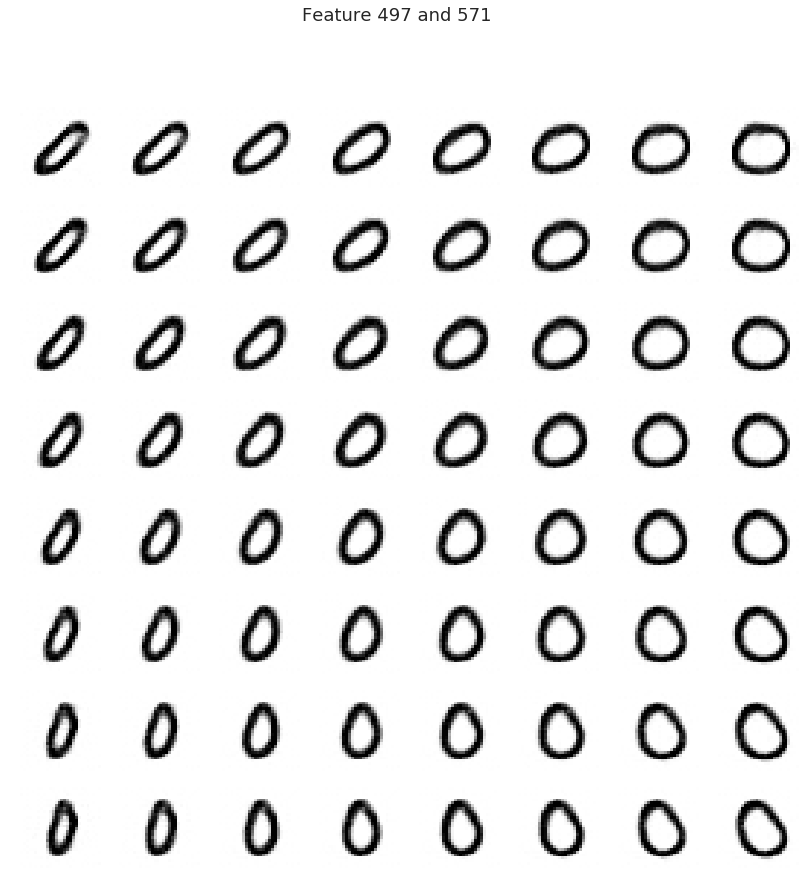

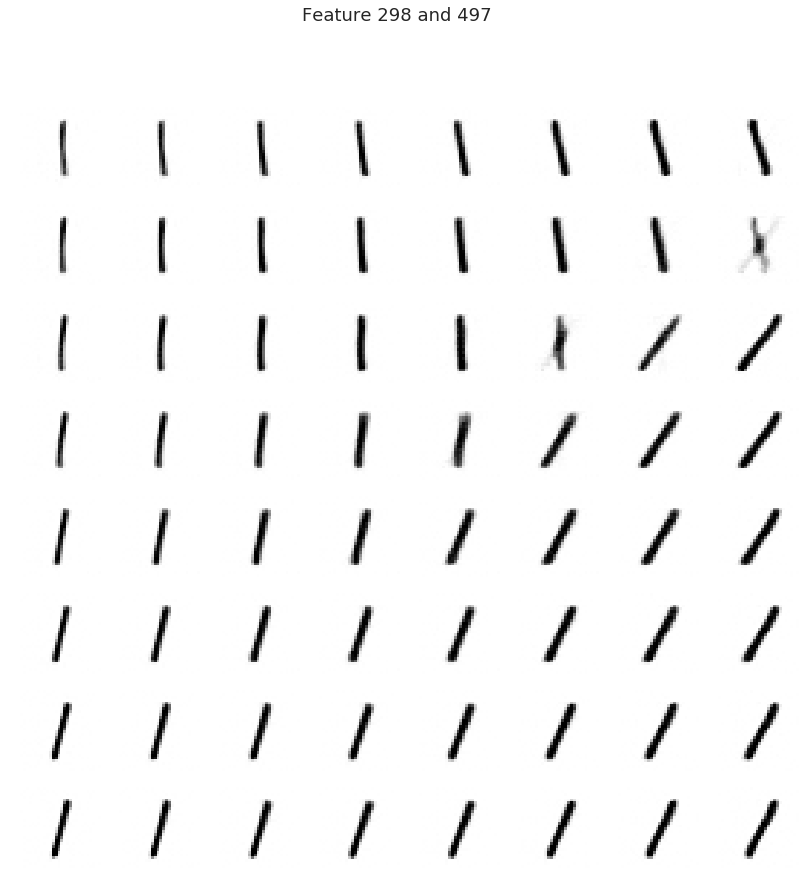

In [14]:
for i_cluster in range(len(means_per_dim)):
    stds = np.std(all_outs[y == i_cluster], axis=0)
    sorted_stds = np.argsort(stds)[::-1]
    feature_combinations = [sorted_stds[:2]]
    #if i_cluster == 1:
    #    feature_combinations = [sorted_stds[:2], (sorted_stds[0], sorted_stds[2]),
    #                            (sorted_stds[1], sorted_stds[2])]
    for i_feature_a, i_feature_b in feature_combinations:
        mean = means_per_dim[i_cluster]
        std = stds_per_dim[i_cluster]

        feature_a_values = th.linspace(float(mean[i_feature_a].data - 2 * std[i_feature_a].data),
                                       float(mean[i_feature_a].data + 2 * std[i_feature_a].data), 8)
        feature_b_values = th.linspace(float(mean[i_feature_b].data - 2 * std[i_feature_b].data),
                                       float(mean[i_feature_b].data + 2 * std[i_feature_b].data), 8)

        image_grid = np.zeros((len(feature_a_values), len(feature_b_values), 28,28))

        for i_f_a_val, f_a_val in enumerate(feature_a_values):
            for i_f_b_val, f_b_val in enumerate(feature_b_values):
                this_out = mean.clone()
                this_out.data[i_feature_a] = f_a_val
                this_out.data[i_feature_b] = f_b_val
                inverted = var_to_np(invert(feature_model, this_out.unsqueeze(0))[0,0])

                image_grid[i_f_a_val, i_f_b_val] = np.copy(inverted)
        fig, axes = plt.subplots(len(feature_a_values), len(feature_b_values), figsize=(14,14))
        for i_f_a_val, _ in enumerate(feature_a_values):
            for i_f_b_val, _ in enumerate(feature_b_values):
                axes[i_f_a_val][i_f_b_val].imshow(image_grid[i_f_a_val, i_f_b_val], vmin=0, vmax=1,
                                                  cmap=cm.Greys)
                axes[i_f_a_val][i_f_b_val].axis('off')
        fig.suptitle("Feature {:d} and {:d}".format(i_feature_a, i_feature_b), fontsize=18, y=0.98)
        display(fig)
        plt.close(fig)
